In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn 
import statsmodels

import sys
import os
import time

# Sparkling Dataset

In [2]:
df = pd.read_csv('Sparkling.csv', parse_dates=True)
df.head()

YearMonth  Sparkling
0   1980-01       1686
1   1980-02       1591
2   1980-03       2304
3   1980-04       1712
4   1980-05       1471

In [3]:
df['YearMonth'] = pd.to_datetime(df['YearMonth'],
                                 format='%Y-%m')
df.head()

YearMonth  Sparkling
0 1980-01-01       1686
1 1980-02-01       1591
2 1980-03-01       2304
3 1980-04-01       1712
4 1980-05-01       1471

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   YearMonth  187 non-null    datetime64[ns]
 1   Sparkling  187 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.0 KB


In [5]:
df = df.set_index('YearMonth')
df = df.asfreq('MS')
df.head()

Sparkling
YearMonth            
1980-01-01       1686
1980-02-01       1591
1980-03-01       2304
1980-04-01       1712
1980-05-01       1471

In [6]:
df.shape

(187, 1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 187 entries, 1980-01-01 to 1995-07-01
Freq: MS
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Sparkling  187 non-null    int64
dtypes: int64(1)
memory usage: 2.9 KB


## EDA

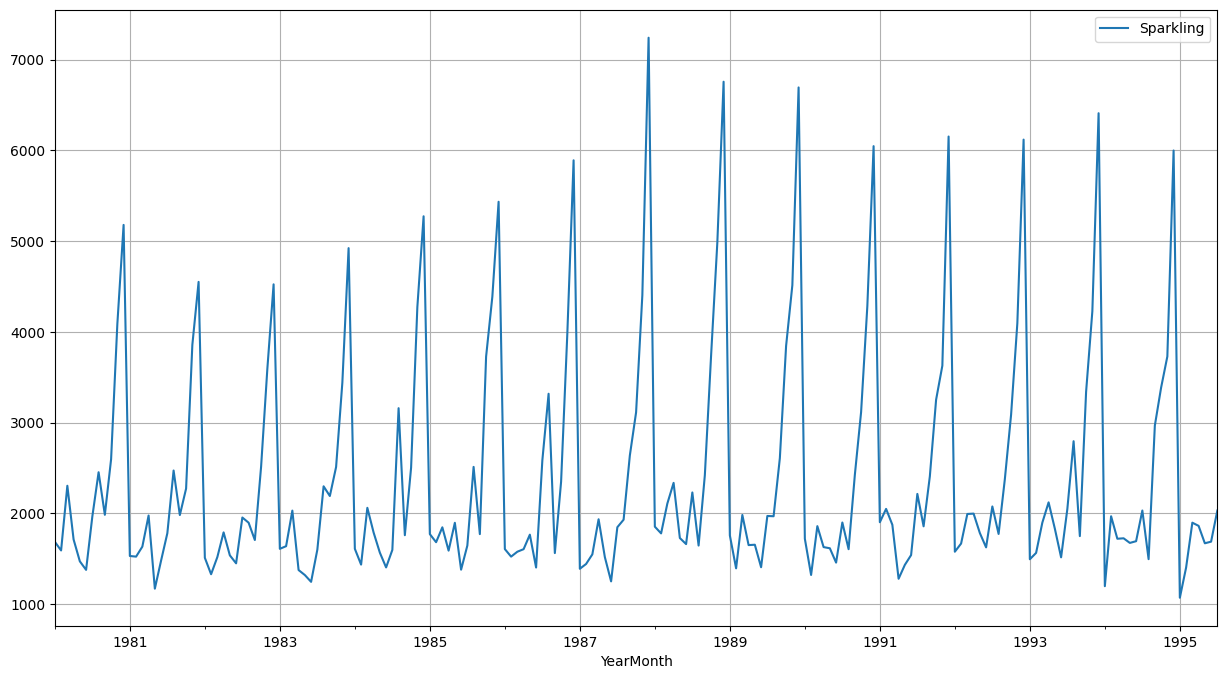

In [8]:
from pylab import rcParams

rcParams['figure.figsize'] = 15,8
df.plot();
plt.grid()
plt.savefig('tsl.png')

In [9]:
df.isnull().sum()

Sparkling    0
dtype: int64

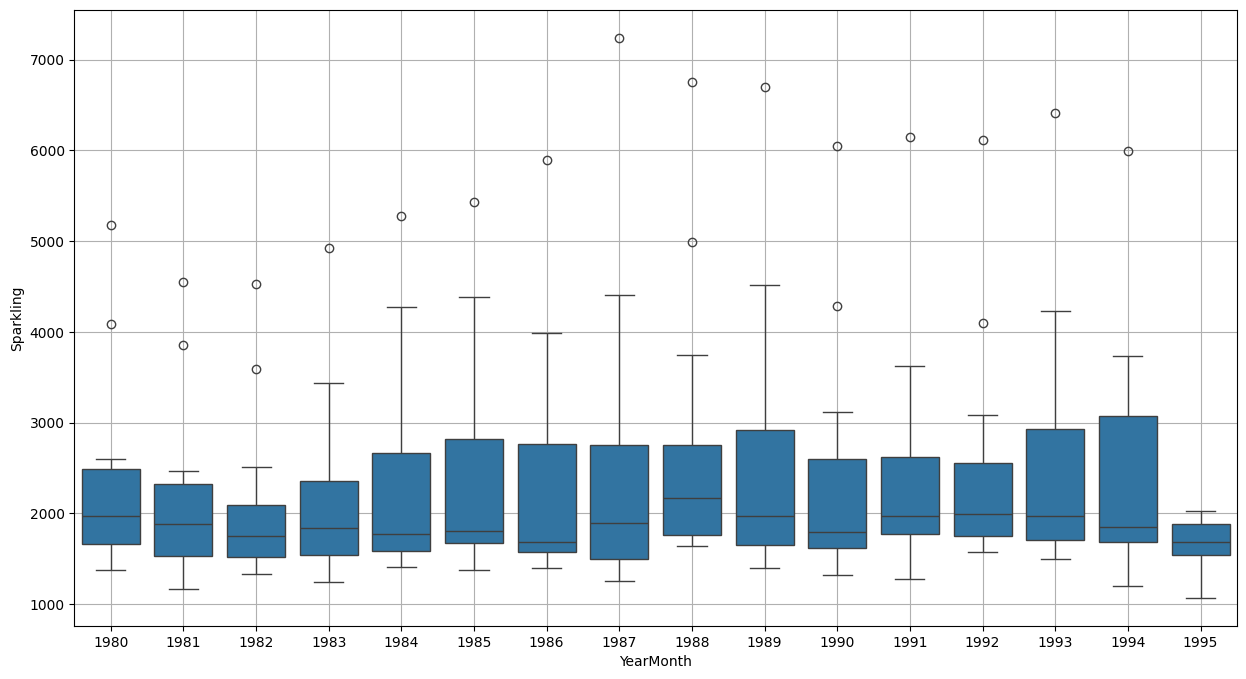

In [10]:
# Yearly Boxplot
sns.boxplot(x = df.index.year,y = df['Sparkling'])
plt.grid();

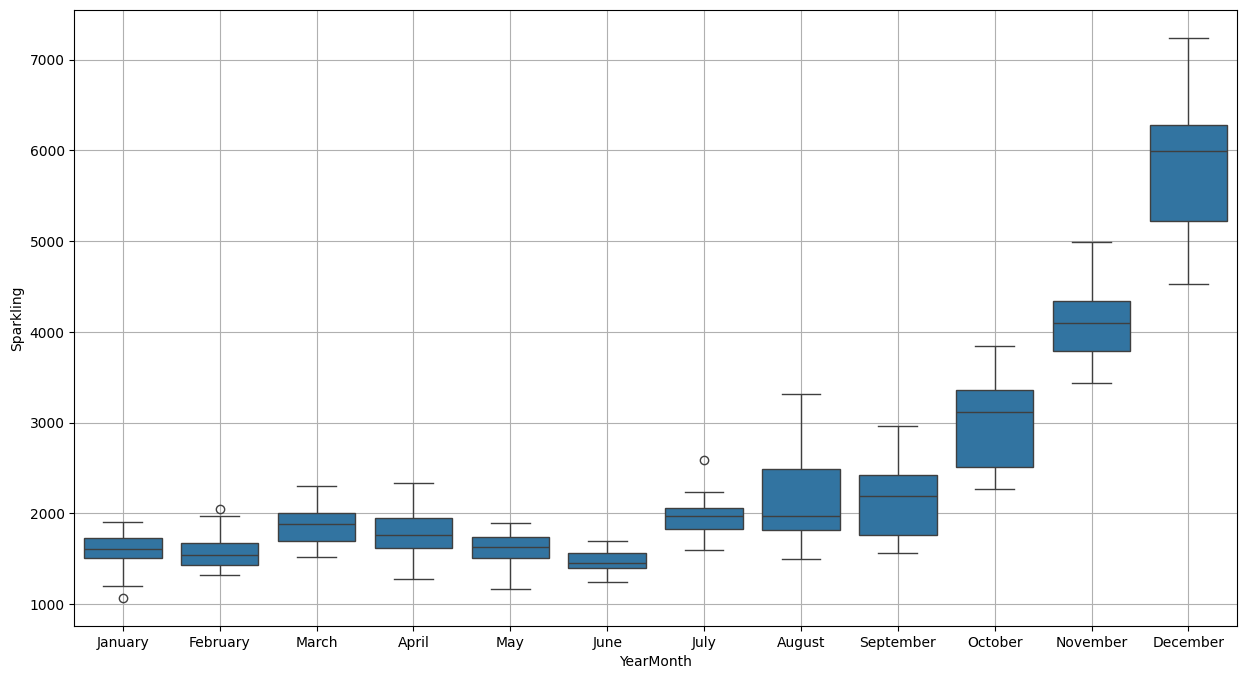

In [11]:
#Monthly Boxplot
sns.boxplot(x = df.index.month_name(),y = df['Sparkling'])
plt.grid();

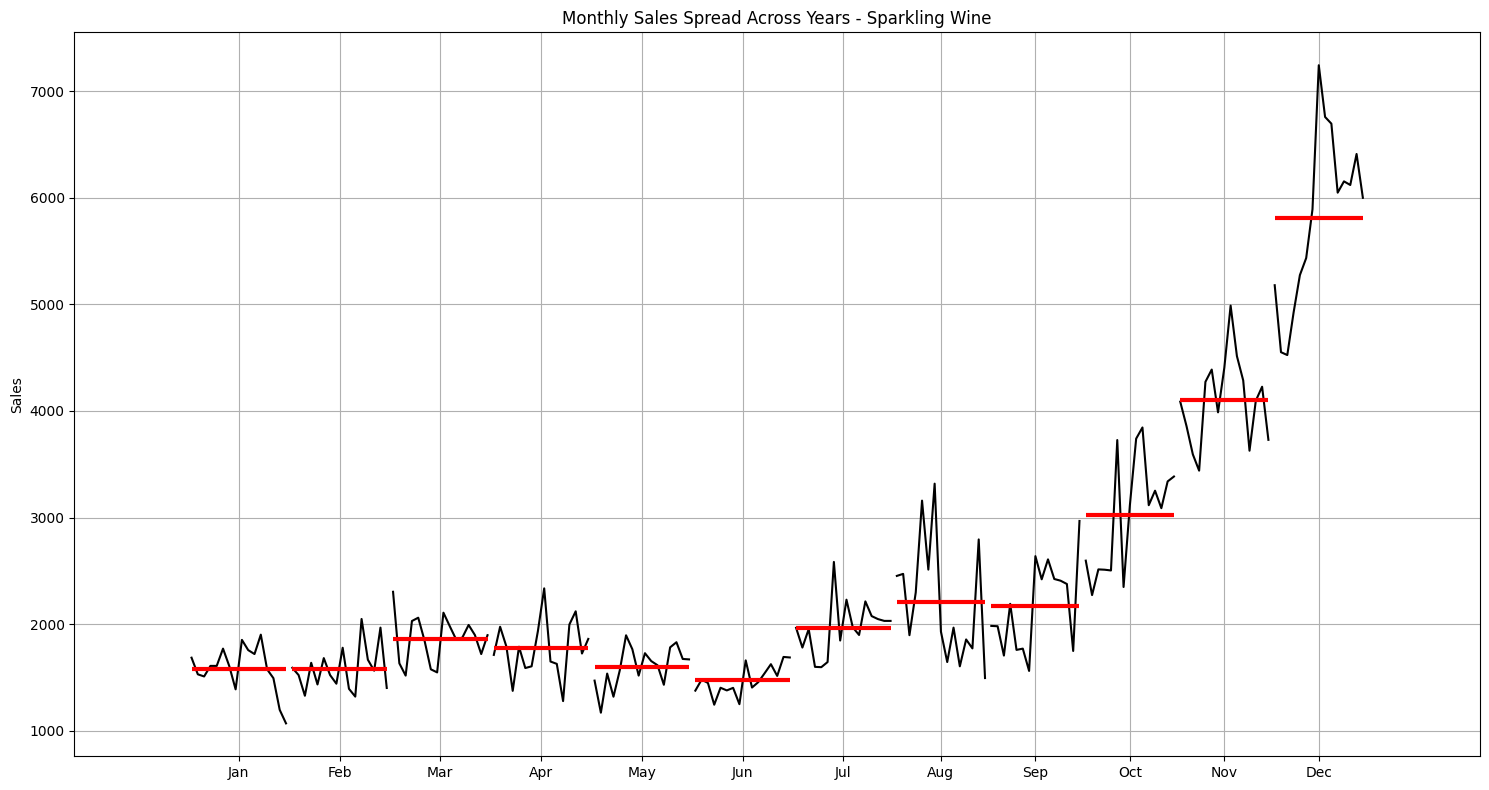

In [12]:
from statsmodels.graphics.tsaplots import month_plot

# Plot the month-wise breakdown across years
month_plot(df['Sparkling'], ylabel='Sales')
plt.grid(True)
plt.title("Monthly Sales Spread Across Years - Sparkling Wine")
plt.tight_layout()
plt.show()

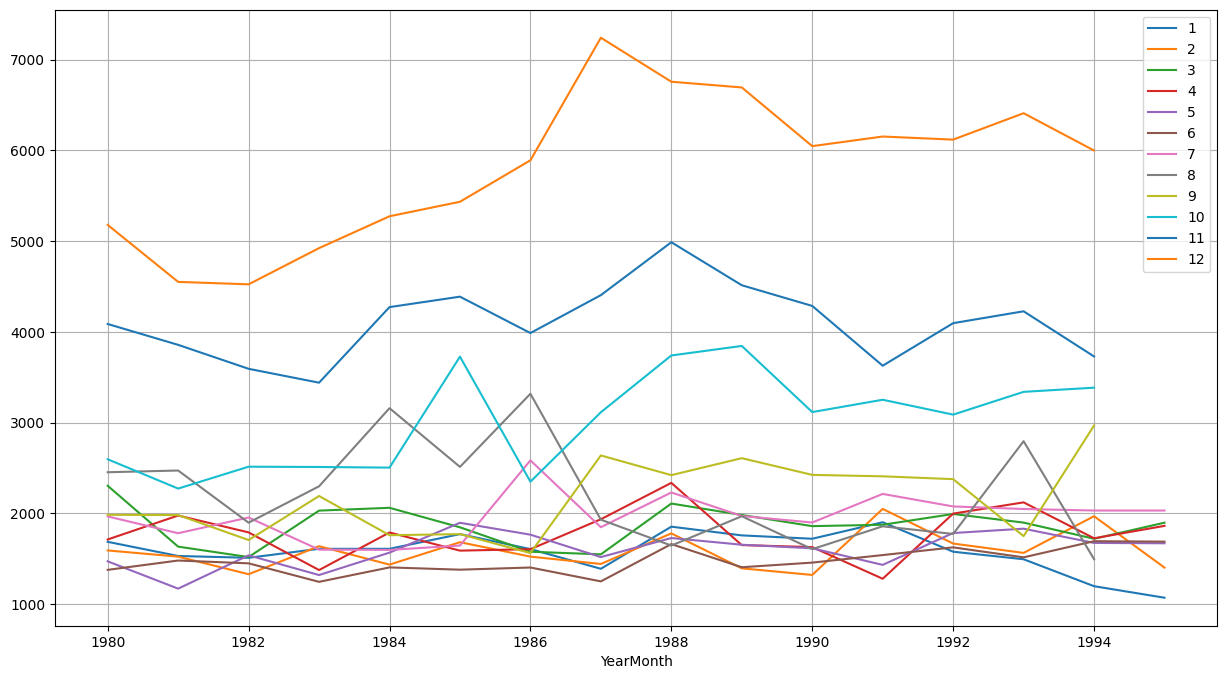

In [13]:
monthly_sales_across_years = pd.pivot_table(df,
                                            values = 'Sparkling',
                                            columns = df.index.month,
                                            index = df.index.year)
monthly_sales_across_years

monthly_sales_across_years.plot()
plt.grid()
plt.legend(loc='best');

In [14]:
# #Empirical Cummulative Distribution Curve 
# from statsmodels.distributions.empirical_distribution import ECDF

# plt.figure(figsize = (18, 8))
# cdf = ECDF(df['Sparkling'])
# plt.plot(cdf.x, cdf.y, label = "statmodels");
# plt.grid()
# plt.xlabel('Sales');

In [15]:
df['Sparkling'].min()

np.int64(1070)

In [16]:
df['Sparkling'].max()

np.int64(7242)

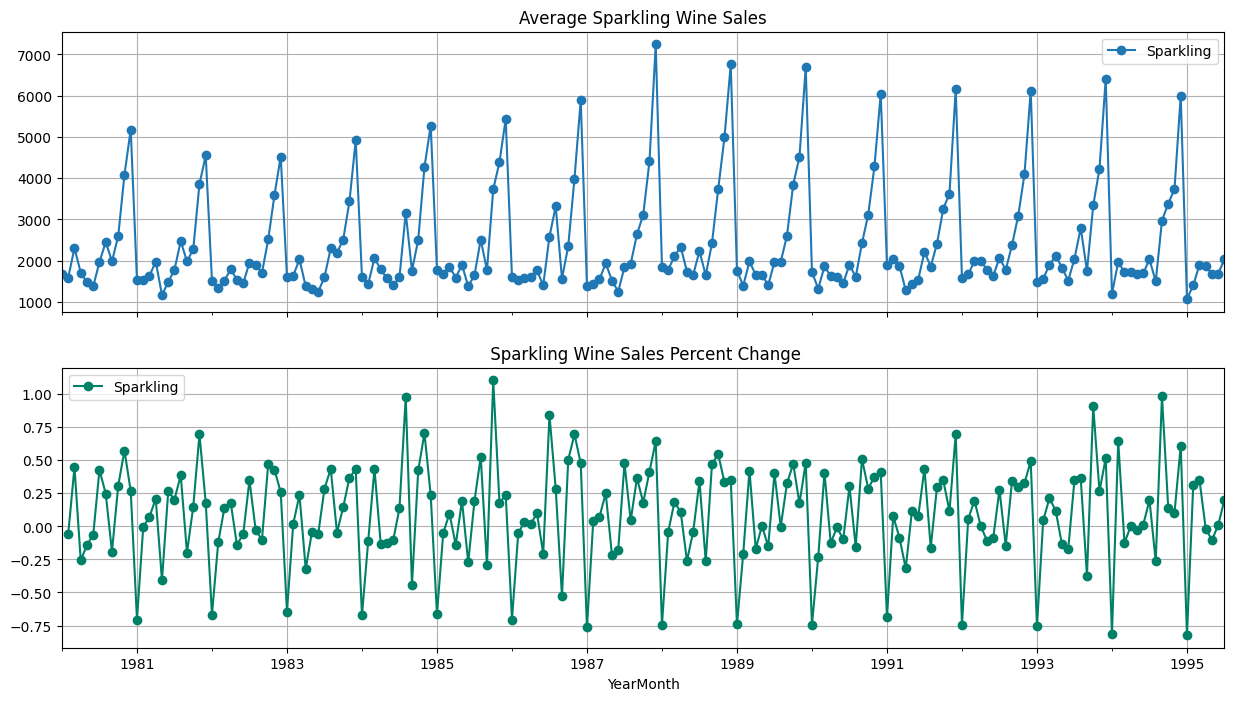

In [17]:
# Plot the average RetailSales per month and the month on month percentage change of RetailSales
# group by date and get average Sales, and precent change

average    = df.groupby(df.index)["Sparkling"].mean()
pct_change = df.groupby(df.index)["Sparkling"].sum().pct_change()

fig, (axis1,axis2) = plt.subplots(2,1,sharex=True,figsize=(15,8))

# plot average Sales over time(year-month)
ax1 = average.plot(legend=True,
                   ax=axis1,
                   marker='o',
                   title="Average Sparkling Wine Sales",
                   grid=True)
ax1.set_xticks(range(len(average)))
ax1.set_xticklabels(average.index.tolist())


# plot precent change for RetailSales over time(year-month)
ax2 = pct_change.plot(legend=True,
                      ax=axis2,
                      marker='o',
                      colormap="summer",
                      title=" Sparkling Wine Sales Percent Change",
                      grid=True)

In [18]:
# Decomposing The Time Series
from    statsmodels.tsa.seasonal import   seasonal_decompose

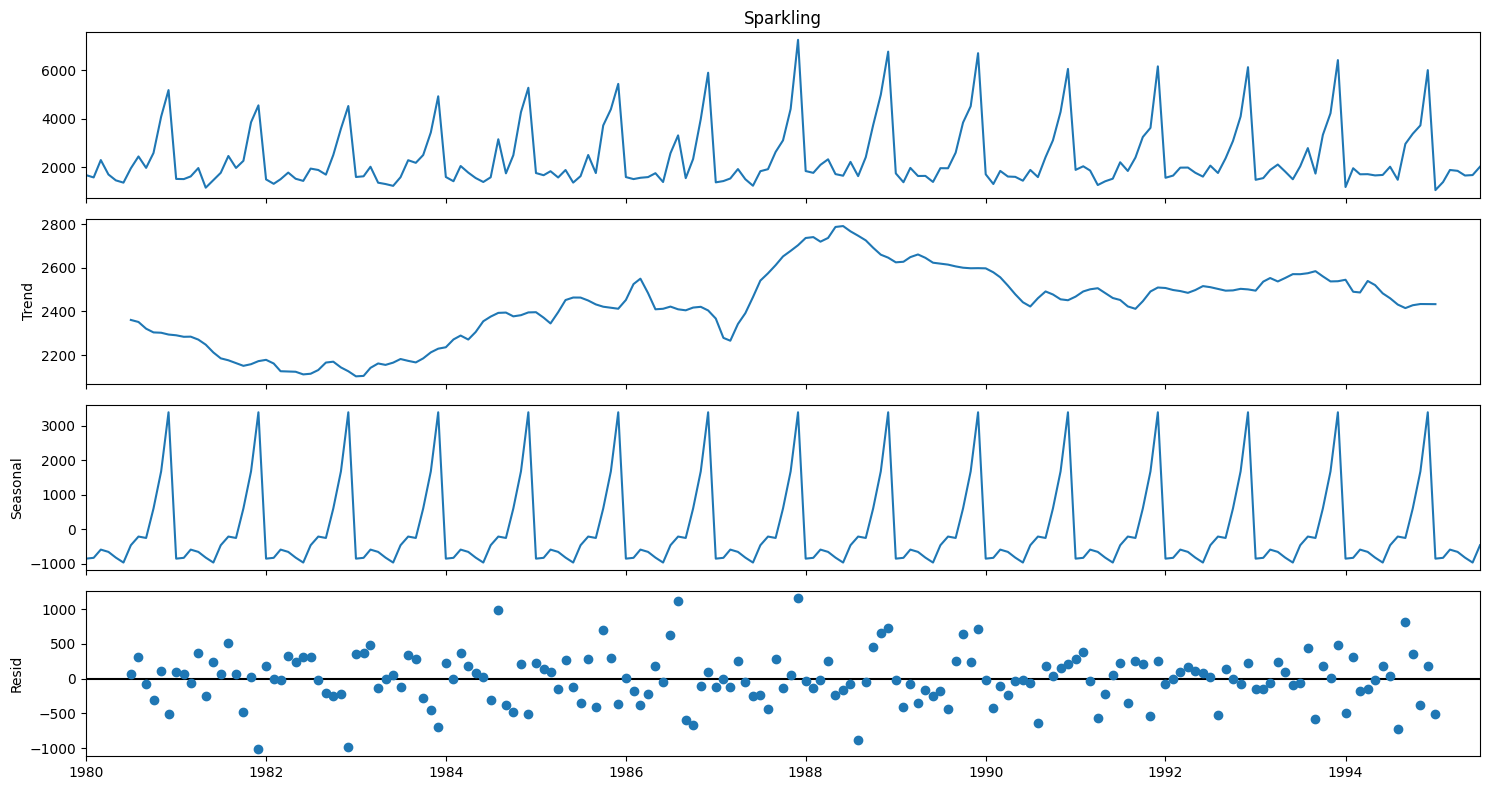

In [19]:
decomposition = seasonal_decompose(df['Sparkling'],model='additive')
decomposition.plot();

In [20]:
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

print('Trend','\n',trend.head(12),'\n')
print('Seasonality','\n',seasonality.head(12),'\n')
print('Residual','\n',residual.head(12),'\n')

Trend 
 YearMonth
1980-01-01            NaN
1980-02-01            NaN
1980-03-01            NaN
1980-04-01            NaN
1980-05-01            NaN
1980-06-01            NaN
1980-07-01    2360.666667
1980-08-01    2351.333333
1980-09-01    2320.541667
1980-10-01    2303.583333
1980-11-01    2302.041667
1980-12-01    2293.791667
Freq: MS, Name: trend, dtype: float64 

Seasonality 
 YearMonth
1980-01-01    -854.260599
1980-02-01    -830.350678
1980-03-01    -592.356630
1980-04-01    -658.490559
1980-05-01    -824.416154
1980-06-01    -967.434011
1980-07-01    -465.502265
1980-08-01    -214.332821
1980-09-01    -254.677265
1980-10-01     599.769957
1980-11-01    1675.067179
1980-12-01    3386.983846
Freq: MS, Name: seasonal, dtype: float64 

Residual 
 YearMonth
1980-01-01           NaN
1980-02-01           NaN
1980-03-01           NaN
1980-04-01           NaN
1980-05-01           NaN
1980-06-01           NaN
1980-07-01     70.835599
1980-08-01    315.999487
1980-09-01    -81.864401
1980-

## Stationarity Test

In [21]:
from statsmodels.tsa.stattools import adfuller


def test_stationarity(timeseries, window=6):
    # Rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std Dev')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.grid(True)
    plt.show()

    # Dickey-Fuller Test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=[
        'Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used'
    ])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    # print(dfoutput, '\n')

    # Decision
    if dftest[1] <= 0.05:
        print("The series is **stationary** (p-value <= 0.05)")
    else:
        print("The series is **not stationary** (p-value > 0.05)")
        
    return dfoutput

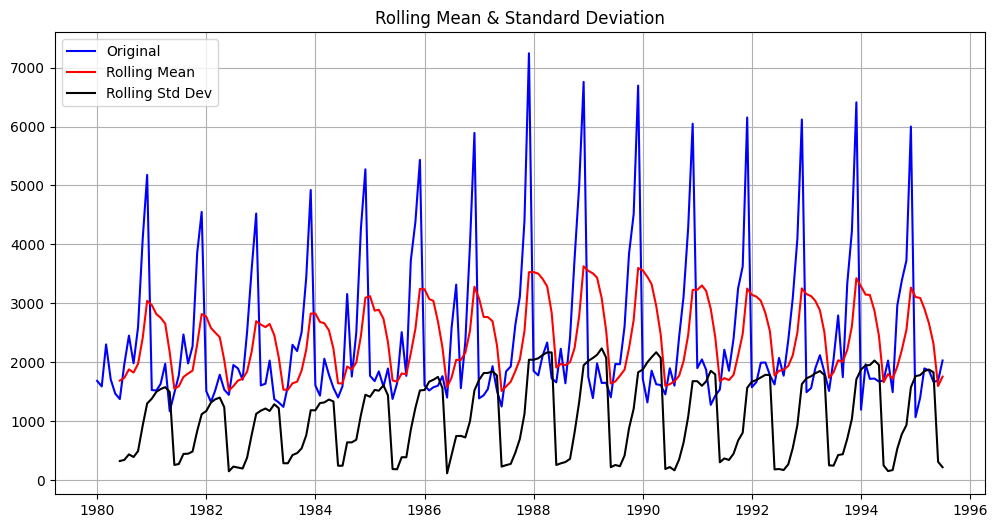

Results of Dickey-Fuller Test:
The series is **not stationary** (p-value > 0.05)


Test Statistic                  -1.360497
p-value                          0.601061
# Lags Used                     11.000000
Number of Observations Used    175.000000
Critical Value (1%)             -3.468280
Critical Value (5%)             -2.878202
Critical Value (10%)            -2.575653
dtype: float64

In [22]:
test_stationarity(df['Sparkling'])

### Retest after 1st differencing

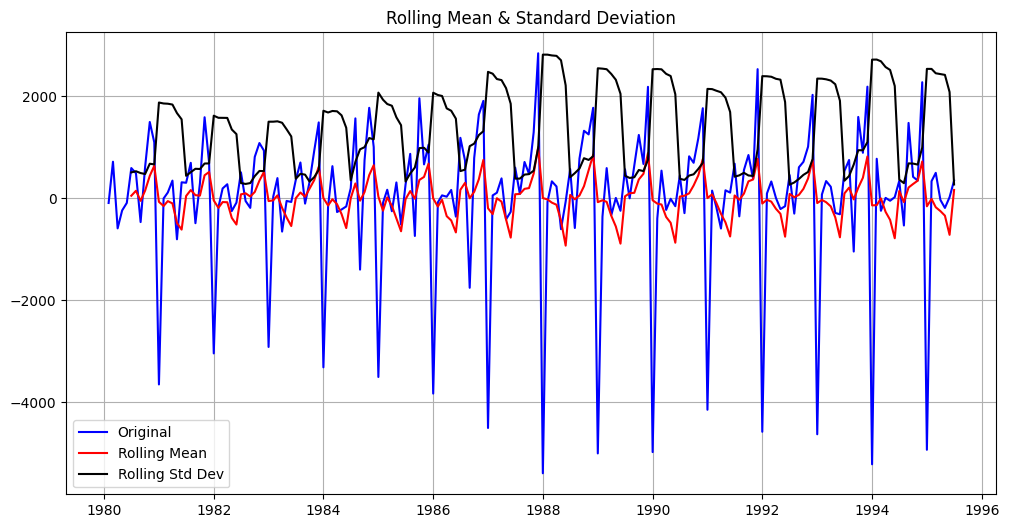

Results of Dickey-Fuller Test:
The series is **stationary** (p-value <= 0.05)


Test Statistic                 -45.050301
p-value                          0.000000
# Lags Used                     10.000000
Number of Observations Used    175.000000
Critical Value (1%)             -3.468280
Critical Value (5%)             -2.878202
Critical Value (10%)            -2.575653
dtype: float64

In [23]:
test_stationarity(df['Sparkling'].diff().dropna())

## AutoCorrelation Plot

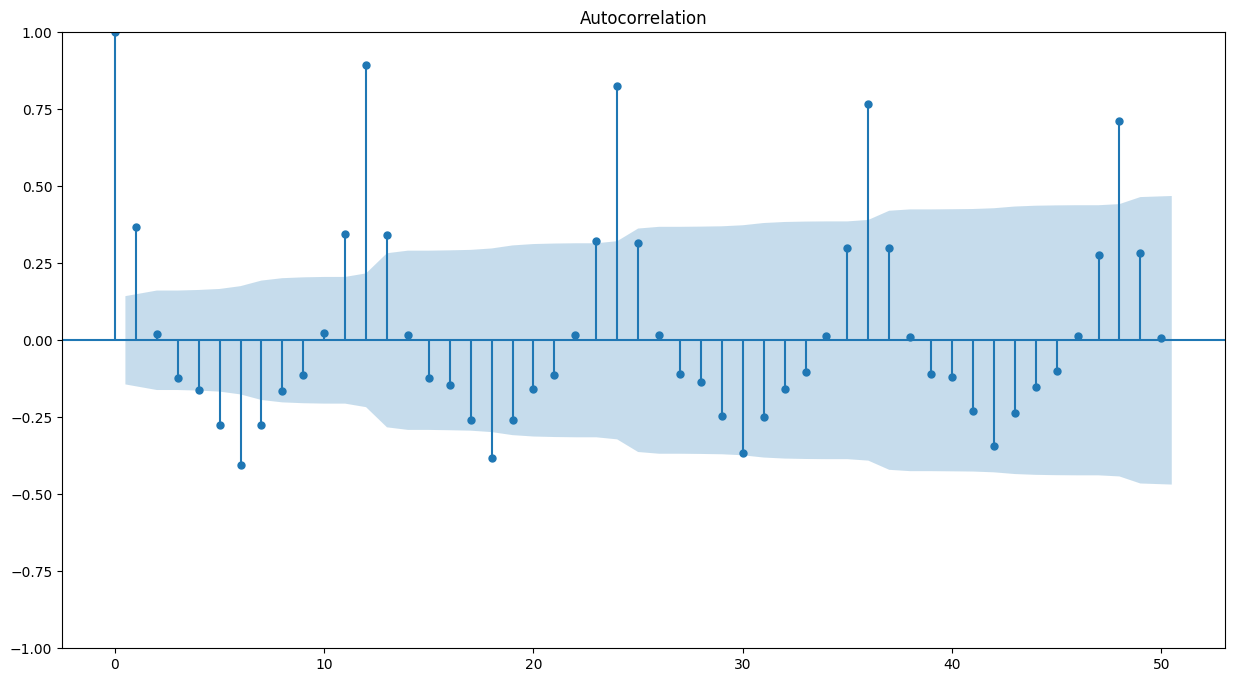

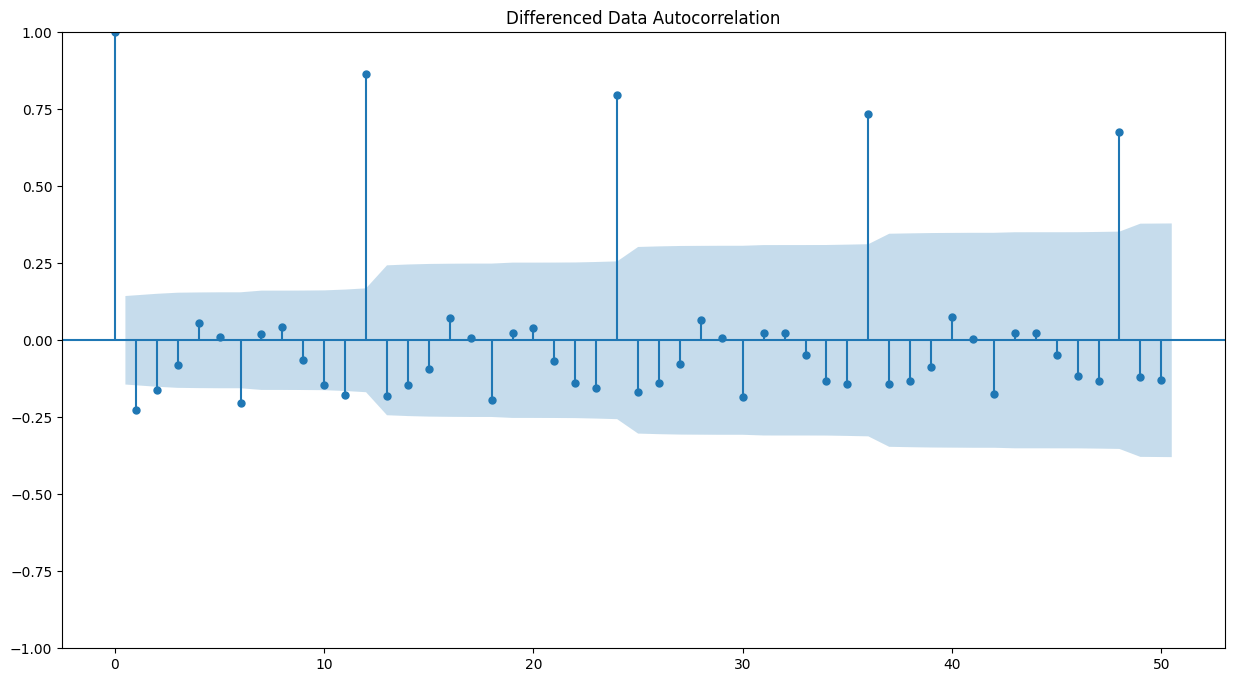

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_acf(df['Sparkling'],lags=50)
plot_acf(df['Sparkling'].diff(1).dropna(),lags=50,title='Differenced Data Autocorrelation')
plt.show()

## Partial AutoCorrelation Function

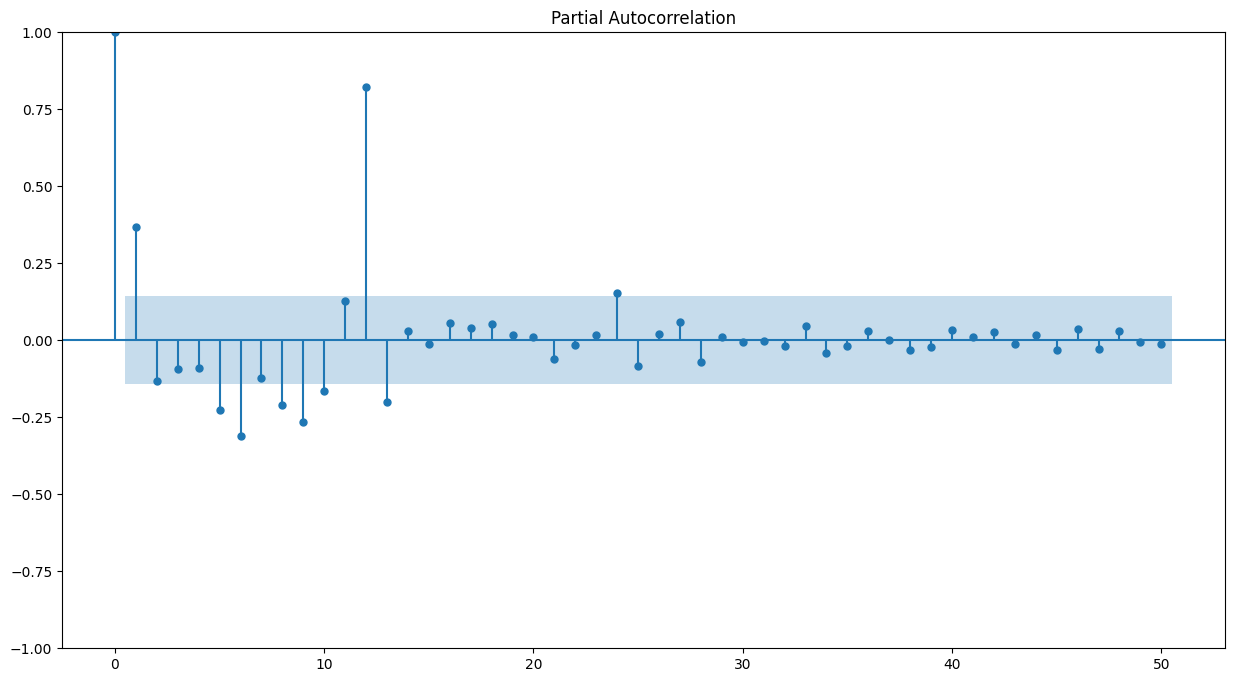

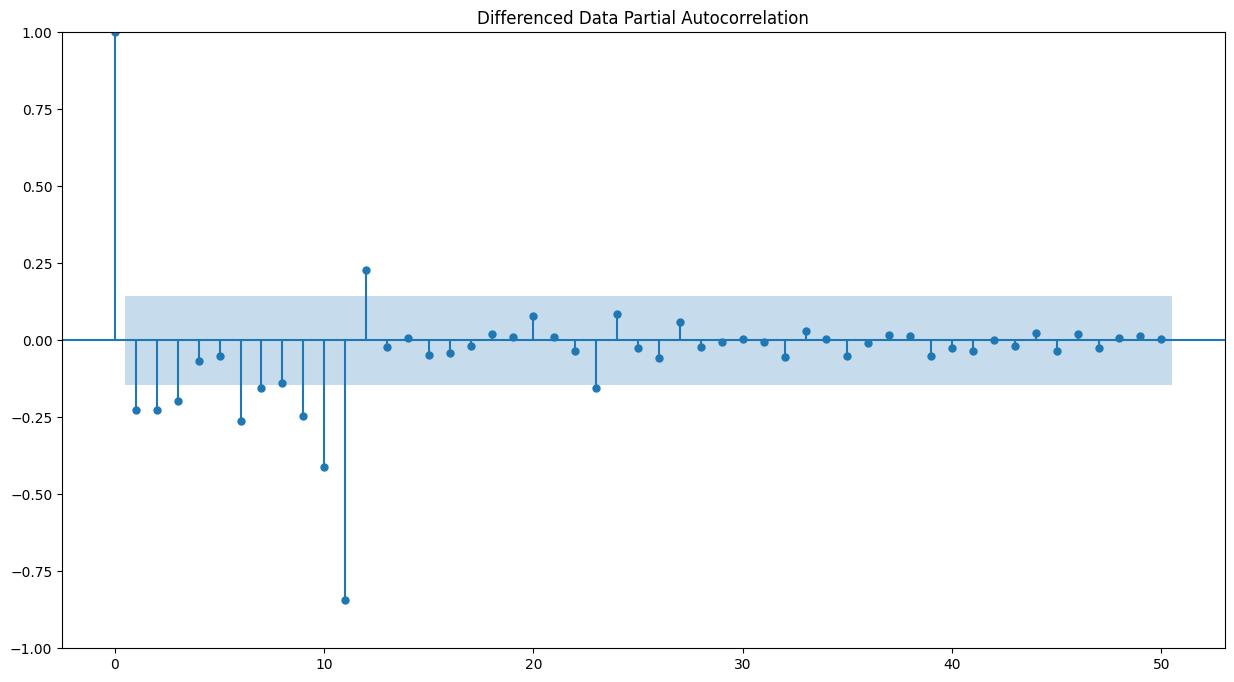

In [25]:
plot_pacf(df['Sparkling'],lags=50)
plot_pacf(df['Sparkling'].diff(1).dropna(),lags=50,title='Differenced Data Partial Autocorrelation')
plt.show()

## Train Test Split

In [26]:
# train-test on the original data
train = df[df.index.year < 1991]
test = df[df.index.year >= 1991]

In [27]:
differenced_df = df.copy()
differenced_df['Sparkling'] = df['Sparkling'].diff().dropna()
differenced_df = differenced_df.dropna()

In [28]:
# train-test sets on the differenced data
train_diff = differenced_df[differenced_df.index.year < 1991]
test_diff = differenced_df[differenced_df.index.year >= 1991]

In [29]:
DATASETS = {
    'original': (train, test),
    'differenced': (train_diff, test_diff)
}

In [30]:
print(train.shape)
print(test.shape)

(132, 1)
(55, 1)


In [31]:
print('First few rows of Training Data','\n',train.head(),'\n')
print('Last few rows of Training Data','\n',train.tail(),'\n')
print('First few rows of Test Data','\n',test.head(),'\n')
print('Last few rows of Test Data','\n',test.tail(),'\n')

First few rows of Training Data 
             Sparkling
YearMonth            
1980-01-01       1686
1980-02-01       1591
1980-03-01       2304
1980-04-01       1712
1980-05-01       1471 

Last few rows of Training Data 
             Sparkling
YearMonth            
1990-08-01       1605
1990-09-01       2424
1990-10-01       3116
1990-11-01       4286
1990-12-01       6047 

First few rows of Test Data 
             Sparkling
YearMonth            
1991-01-01       1902
1991-02-01       2049
1991-03-01       1874
1991-04-01       1279
1991-05-01       1432 

Last few rows of Test Data 
             Sparkling
YearMonth            
1995-03-01       1897
1995-04-01       1862
1995-05-01       1670
1995-06-01       1688
1995-07-01       2031 



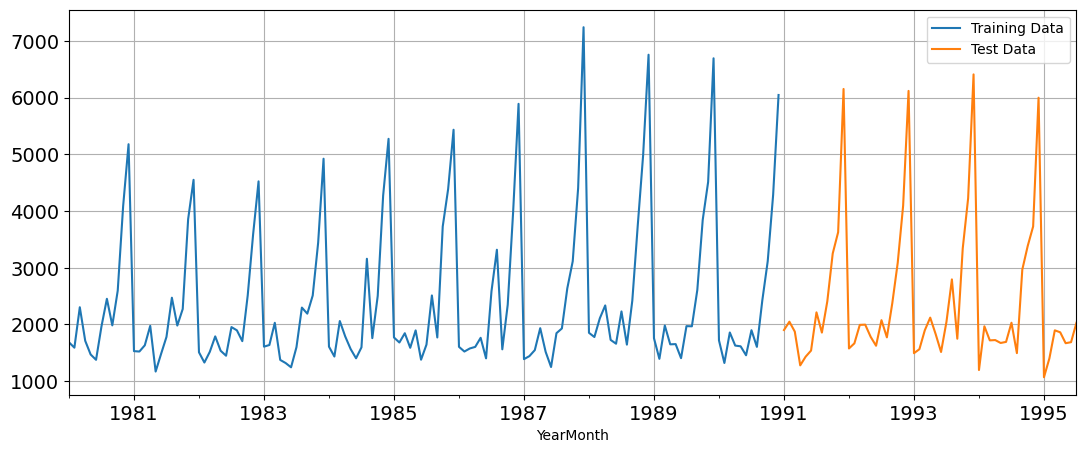

In [32]:
train['Sparkling'].plot(figsize=(13,5), fontsize=14)
test['Sparkling'].plot(figsize=(13,5), fontsize=14)
plt.grid()
plt.legend(['Training Data','Test Data'])
plt.show()

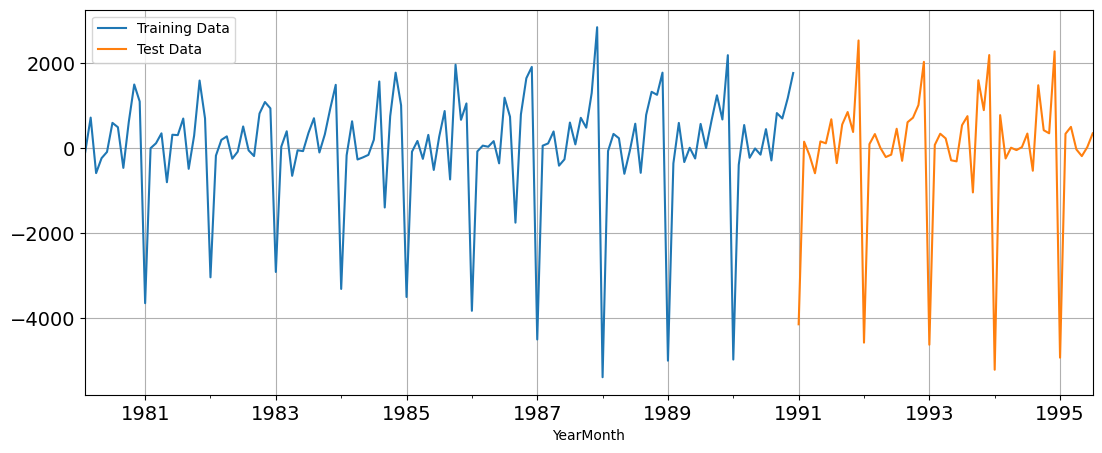

In [33]:
train_diff['Sparkling'].plot(figsize=(13,5), fontsize=14)
test_diff['Sparkling'].plot(figsize=(13,5), fontsize=14)
plt.grid()
plt.legend(['Training Data','Test Data'])
plt.show()

## 1. Regression Model

In [34]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+43 for i in range(len(test))]
print('Training Time instance','\n',train_time)
print('\n')
print('Test Time instance','\n',test_time)

Training Time instance 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132]


Test Time instance 
 [43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97]


In [35]:
LinearRegression_train = train.copy()
LinearRegression_test = test.copy()

LinearRegression_train['time'] = train_time
LinearRegression_test['time'] = test_time

In [36]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(LinearRegression_train[['time']],
      LinearRegression_train['Sparkling'].values)


LinearRegression()

In [37]:
#predictions on train data
train_predictions_model1 = lr.predict(LinearRegression_train[['time']])
LinearRegression_train['RegOnTime'] = train_predictions_model1

#predictions on test data
test_predictions_model1 = lr.predict(LinearRegression_test[['time']])
LinearRegression_test['RegOnTime'] = test_predictions_model1

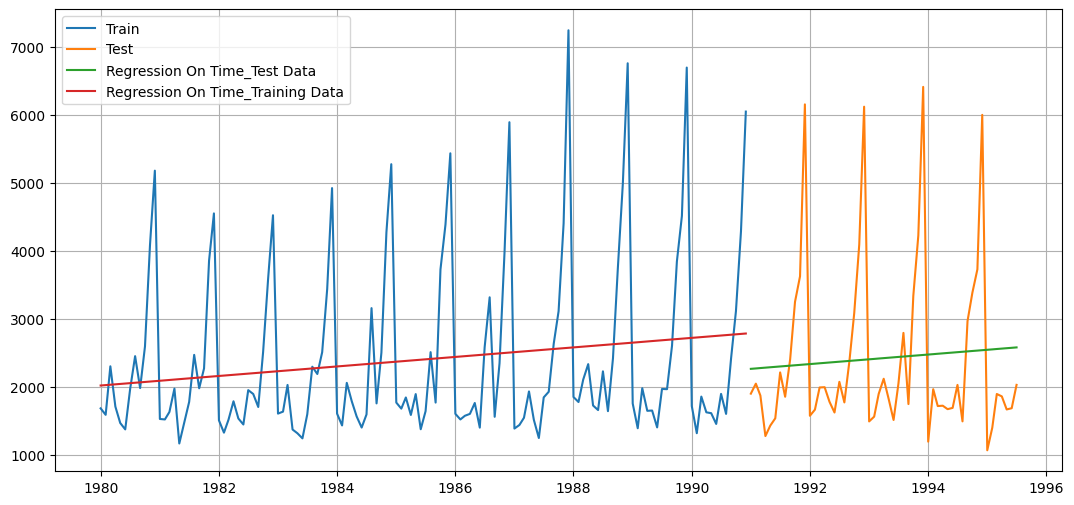

In [38]:
plt.figure(figsize=(13,6))
plt.plot( train['Sparkling'], label='Train')
plt.plot(test['Sparkling'], label='Test')
plt.plot(LinearRegression_test['RegOnTime'], label='Regression On Time_Test Data')
plt.plot(LinearRegression_train['RegOnTime'], label='Regression On Time_Training Data')
plt.legend(loc='best')
plt.grid();

In [39]:
# from sklearn import metrics

# def MAPE(y, yhat): 
#     y, yhat = np.array(y), np.array(yhat)
#     try:
#         mape =  round(np.sum(np.abs(yhat - y)) / np.sum(y) * 100,2)
#     except:
#         print("Observed values are empty")
#         mape = np.nan
#     return mape

In [40]:
from sklearn import metrics


# Custom RMSE function
def RMSE(y, yhat):
    y, yhat = np.array(y), np.array(yhat)
    try:
        rmse = round(np.sqrt(np.mean((y - yhat) ** 2)), 2)
    except:
        print("Observed values are empty or invalid")
        rmse = np.nan
    return rmse


# Custom MAPE function (your version)
def MAPE(y, yhat): 
    y, yhat = np.array(y), np.array(yhat)
    try:
        mape = round(np.sum(np.abs(yhat - y)) / np.sum(y) * 100, 2)
    except:
        print("Observed values are empty")
        mape = np.nan
    return mape

In [41]:
## MODEL1 - Training RMSE & MAPE
rmse_model1_train = RMSE(train['Sparkling'], train_predictions_model1)
mape_model1_train = MAPE(train['Sparkling'], train_predictions_model1)

print(f"For Model 1, Training RMSE is {rmse_model1_train} and MAPE is {mape_model1_train}")

For Model 1, Training RMSE is 1279.32 and MAPE is 40.05


In [42]:
## MODEL1 - Testing RMSE & MAPE
rmse_model1_test = RMSE(test['Sparkling'], test_predictions_model1)
mape_model1_test = MAPE(test['Sparkling'], test_predictions_model1)

print(f"For Model 1, Testing RMSE is {rmse_model1_test} and MAPE is {mape_model1_test}")

For Model 1, Testing RMSE is 1275.87 and MAPE is 39.16


In [43]:
resultsDF = pd.DataFrame({
    'Model': pd.Series(dtype='str'),
    'Train RMSE': pd.Series(dtype='float'),
    'Train MAPE': pd.Series(dtype='float'),
    'Test RMSE': pd.Series(dtype='float'),
    'Test MAPE': pd.Series(dtype='float')
})


# model logging function
def log_results(model, train_rmse, train_mape, test_rmse, test_mape, data_source):
    global resultsDF

    new_row = pd.DataFrame({
        'Model': [model],
        'Train RMSE': [train_rmse],
        'Train MAPE': [train_mape],
        'Test RMSE': [test_rmse],
        'Test MAPE': [test_mape],
        'Data Source': [data_source]  # <--- NEW COLUMN
    })

    resultsDF = pd.concat([resultsDF, new_row], ignore_index=True)

In [44]:
log_results(model="RegressionModel_Model1",
            train_rmse=rmse_model1_train,
            train_mape=mape_model1_train,
            test_rmse=rmse_model1_test,
            test_mape=mape_model1_test,
            data_source="original")

In [45]:
resultsDF

Model  Train RMSE  Train MAPE  Test RMSE  Test MAPE  \
0  RegressionModel_Model1     1279.32       40.05    1275.87      39.16   

  Data Source  
0    original

## 2. Naive Model

In [46]:
NaiveModel_train = train.copy()
NaiveModel_test = test.copy()

In [47]:
NaiveModel_train['naive'] = np.asarray(train['Sparkling'])[len(np.asarray(train['Sparkling']))-1]
NaiveModel_train['naive'].head()

YearMonth
1980-01-01    6047
1980-02-01    6047
1980-03-01    6047
1980-04-01    6047
1980-05-01    6047
Freq: MS, Name: naive, dtype: int64

In [48]:
NaiveModel_test['naive'] = np.asarray(train['Sparkling'])[len(np.asarray(train['Sparkling']))-1]
NaiveModel_test['naive'].head()

YearMonth
1991-01-01    6047
1991-02-01    6047
1991-03-01    6047
1991-04-01    6047
1991-05-01    6047
Freq: MS, Name: naive, dtype: int64

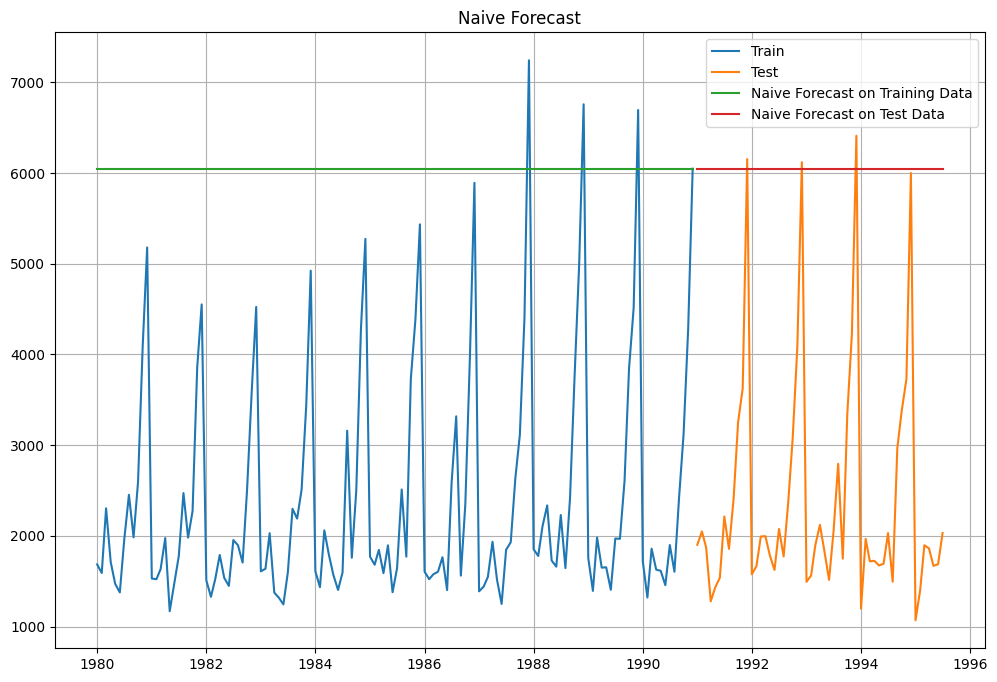

In [49]:
plt.figure(figsize=(12,8))
plt.plot(NaiveModel_train['Sparkling'], label='Train')
plt.plot(test['Sparkling'], label='Test')
plt.plot(NaiveModel_train['naive'], label='Naive Forecast on Training Data')
plt.plot(NaiveModel_test['naive'], label='Naive Forecast on Test Data')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.grid();

In [50]:
# MODEL2 - Evaluate Naive Model on training data
rmse_model2_train = RMSE(train['Sparkling'], NaiveModel_train['naive'])
mape_model2_train = MAPE(train['Sparkling'], NaiveModel_train['naive'])

print(f"For Model 2, Training RMSE is {rmse_model2_train} and MAPE is {mape_model2_train}")

For Model 2, Training RMSE is 3867.7 and MAPE is 153.17


In [51]:
# MODEL2 -  Evaluate Naive Model on Testa Data
rmse_model2_test = RMSE(test['Sparkling'], NaiveModel_test['naive'])
mape_model2_test = MAPE(test['Sparkling'], NaiveModel_test['naive'])

print(f"For Model 2, Testing RMSE is {rmse_model2_test} and MAPE is {mape_model2_test}")

For Model 2, Testing RMSE is 3864.28 and MAPE is 152.87


In [52]:
log_results(model = "Naive_Model2",
            train_rmse = rmse_model2_train,
            train_mape = mape_model2_train,
            test_rmse = rmse_model2_test,
            test_mape = mape_model2_test,
           data_source = "original")

resultsDF

Model  Train RMSE  Train MAPE  Test RMSE  Test MAPE  \
0  RegressionModel_Model1     1279.32       40.05    1275.87      39.16   
1            Naive_Model2     3867.70      153.17    3864.28     152.87   

  Data Source  
0    original  
1    original

## 3. Simple Average Model

In [53]:
SimpleAverage_train = train.copy()
SimpleAverage_test = test.copy()

In [54]:
SimpleAverage_train['mean_forecast'] = train['Sparkling'].mean()
SimpleAverage_train.head()

Sparkling  mean_forecast
YearMonth                           
1980-01-01       1686    2403.780303
1980-02-01       1591    2403.780303
1980-03-01       2304    2403.780303
1980-04-01       1712    2403.780303
1980-05-01       1471    2403.780303

In [55]:
SimpleAverage_test['mean_forecast'] = train['Sparkling'].mean()
SimpleAverage_test.head()

Sparkling  mean_forecast
YearMonth                           
1991-01-01       1902    2403.780303
1991-02-01       2049    2403.780303
1991-03-01       1874    2403.780303
1991-04-01       1279    2403.780303
1991-05-01       1432    2403.780303

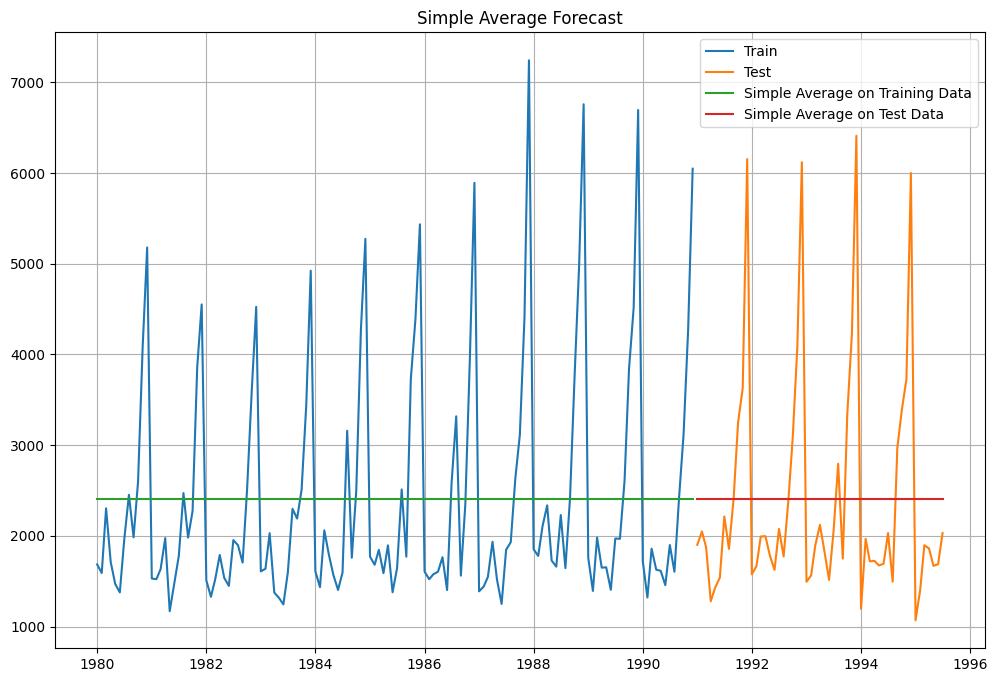

In [56]:
plt.figure(figsize=(12,8))
plt.plot(SimpleAverage_train['Sparkling'], label='Train')
plt.plot(SimpleAverage_test['Sparkling'], label='Test')
plt.plot(SimpleAverage_train['mean_forecast'], label='Simple Average on Training Data')
plt.plot(SimpleAverage_test['mean_forecast'], label='Simple Average on Test Data')
plt.legend(loc='best')
plt.title("Simple Average Forecast")
plt.grid();

In [57]:
# MODEL3 - Evaluate Simple Average Model on Training Data
rmse_model3_train = RMSE(train['Sparkling'], SimpleAverage_train['mean_forecast'])
mape_model3_train = MAPE(train['Sparkling'], SimpleAverage_train['mean_forecast'])

print(f"For Model 3, Training RMSE is {rmse_model3_train} and MAPE is {mape_model3_train}")

For Model 3, Training RMSE is 1298.48 and MAPE is 40.36


In [58]:
# MODEL3 - Evaluate Simple Average Model on Training Data
rmse_model3_test = RMSE(test['Sparkling'], SimpleAverage_test['mean_forecast'])
mape_model3_test = MAPE(test['Sparkling'], SimpleAverage_test['mean_forecast'])

print(f"For Model 3, Test RMSE is {rmse_model3_test} and MAPE is {mape_model3_test}")

For Model 3, Test RMSE is 1275.08 and MAPE is 38.9


In [59]:
log_results("SimpleAveraging_Model3",
            rmse_model3_train,
            mape_model3_train,
            rmse_model3_test,
            mape_model3_test,
           "original")

resultsDF

Model  Train RMSE  Train MAPE  Test RMSE  Test MAPE  \
0  RegressionModel_Model1     1279.32       40.05    1275.87      39.16   
1            Naive_Model2     3867.70      153.17    3864.28     152.87   
2  SimpleAveraging_Model3     1298.48       40.36    1275.08      38.90   

  Data Source  
0    original  
1    original  
2    original

## 4. Moving Average Model

In [60]:
MovingAverage = df.copy()

# Add trailing moving average columns
for w in [2, 4, 6, 9]:
    MovingAverage[f'Trailing_{w}'] = MovingAverage['Sparkling'].rolling(w).mean()

In [61]:
# Step 2: Train-Test Split
train_size = int(len(MovingAverage) * 0.71)
trailing_MA_train = MovingAverage.iloc[:train_size]
trailing_MA_test = MovingAverage.iloc[train_size:]

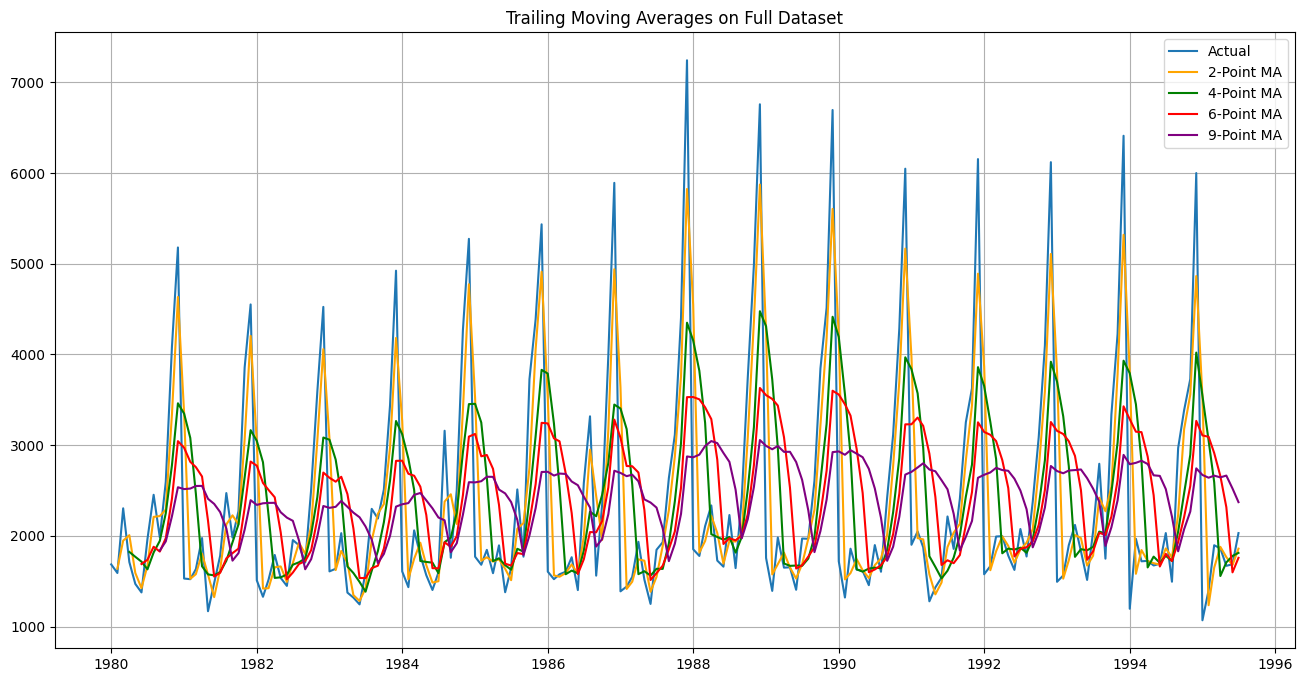

In [62]:
plt.figure(figsize=(16, 8))
plt.plot(MovingAverage['Sparkling'], label='Actual')

colors = ['orange', 'green', 'red', 'purple']
for w, c in zip([2, 4, 6, 9], colors):
    plt.plot(MovingAverage[f'Trailing_{w}'], label=f'{w}-Point MA', color=c)

plt.legend()
plt.title('Trailing Moving Averages on Full Dataset')
plt.grid(True)
plt.show()

In [63]:
# Step 4: Loop over MA windows and evaluate each
for w in [2, 4, 6, 9]:
    model_name = f'{w}-Point Trailing MA_Model4'

    # Drop NaNs from rolling to get valid forecast points
    train_ma = trailing_MA_train[f'Trailing_{w}'].dropna()
    test_ma = trailing_MA_test[f'Trailing_{w}'].dropna()

    # Align targets with available forecast indices
    train_true = train.loc[train_ma.index, 'Sparkling']
    test_true = test.loc[test_ma.index, 'Sparkling']

    # Evaluate
    train_rmse = RMSE(train_true, train_ma)
    train_mape = MAPE(train_true, train_ma)
    test_rmse = RMSE(test_true, test_ma)
    test_mape = MAPE(test_true, test_ma)

    # Print evaluation
    print(f"{model_name} → Train RMSE: {train_rmse}, MAPE: {train_mape}% | Test RMSE: {test_rmse}, MAPE: {test_mape}%")

    # Log results
    log_results(model_name, train_rmse, train_mape, test_rmse, test_mape, data_source="original")


2-Point Trailing MA_Model4 → Train RMSE: 689.16, MAPE: 18.01% | Test RMSE: 813.4, MAPE: 19.7%
4-Point Trailing MA_Model4 → Train RMSE: 1106.4, MAPE: 34.28% | Test RMSE: 1156.59, MAPE: 35.96%
6-Point Trailing MA_Model4 → Train RMSE: 1261.79, MAPE: 42.11% | Test RMSE: 1283.93, MAPE: 43.86%
9-Point Trailing MA_Model4 → Train RMSE: 1372.84, MAPE: 45.99% | Test RMSE: 1346.28, MAPE: 46.86%


In [64]:
resultsDF

Model  Train RMSE  Train MAPE  Test RMSE  Test MAPE  \
0      RegressionModel_Model1     1279.32       40.05    1275.87      39.16   
1                Naive_Model2     3867.70      153.17    3864.28     152.87   
2      SimpleAveraging_Model3     1298.48       40.36    1275.08      38.90   
3  2-Point Trailing MA_Model4      689.16       18.01     813.40      19.70   
4  4-Point Trailing MA_Model4     1106.40       34.28    1156.59      35.96   
5  6-Point Trailing MA_Model4     1261.79       42.11    1283.93      43.86   
6  9-Point Trailing MA_Model4     1372.84       45.99    1346.28      46.86   

  Data Source  
0    original  
1    original  
2    original  
3    original  
4    original  
5    original  
6    original

## Model 5: Simple Exponential Smoothing (Auto)

In [65]:
from statsmodels.tsa.api import SimpleExpSmoothing

# Fit Simple Exponential Smoothing 
model_SES = SimpleExpSmoothing(train['Sparkling'])
model_SES_fit = model_SES.fit(optimized=True)

In [66]:
print(model_SES_fit.summary())

                       SimpleExpSmoothing Model Results                       
Dep. Variable:              Sparkling   No. Observations:                  132
Model:             SimpleExpSmoothing   SSE                      228998251.534
Optimized:                       True   AIC                           1900.368
Trend:                           None   BIC                           1906.133
Seasonal:                        None   AICC                          1900.683
Seasonal Periods:                None   Date:                 Sat, 12 Apr 2025
Box-Cox:                        False   Time:                         19:00:35
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.0395349                alpha                 True
initial_level              1686.0000                

In [67]:
model_SES_fit.params

{'smoothing_level': np.float64(0.03953488372093023),
 'smoothing_trend': np.float64(nan),
 'smoothing_seasonal': np.float64(nan),
 'damping_trend': nan,
 'initial_level': np.float64(1686.0),
 'initial_trend': np.float64(nan),
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [68]:
# Predictions
train_preds_SES = model_SES_fit.fittedvalues
test_preds_SES = model_SES_fit.forecast(steps=len(test))

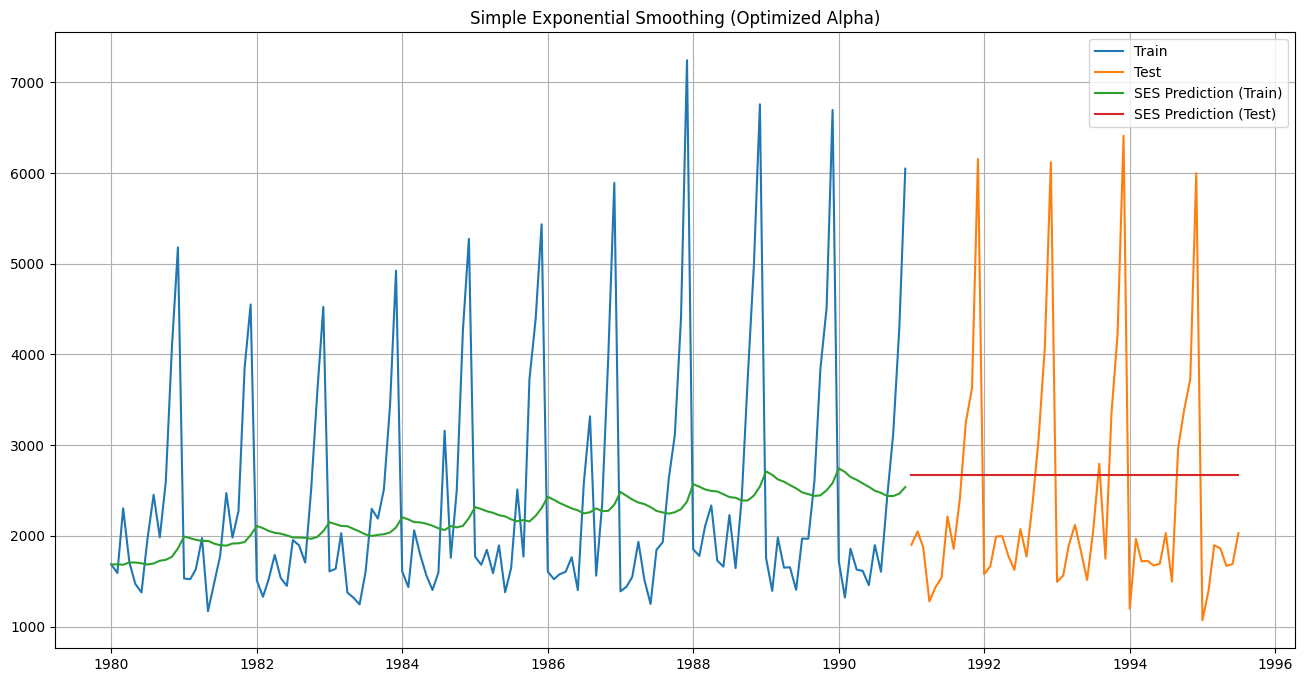

In [69]:
# Plot predictions
plt.figure(figsize=(16, 8))
plt.plot(train['Sparkling'], label='Train')
plt.plot(test['Sparkling'], label='Test')
plt.plot(train_preds_SES, label='SES Prediction (Train)')
plt.plot(test.index, test_preds_SES, label='SES Prediction (Test)')

plt.title('Simple Exponential Smoothing (Optimized Alpha)')
plt.legend()
plt.grid(True)
plt.show()

In [70]:
# Evaluate
rmse_model5_train = RMSE(train['Sparkling'], train_preds_SES)
mape_model5_train = MAPE(train['Sparkling'], train_preds_SES)

rmse_model5_test = RMSE(test['Sparkling'], test_preds_SES)
mape_model5_test = MAPE(test['Sparkling'], test_preds_SES)

print(f"Model5 Simple Exponential Smoothing - Train RMSE: {rmse_model5_train}, Train MAPE: {mape_model5_train}% | Test RMSE: {rmse_model5_test}, Test MAPE: {mape_model5_test}%")

Model5 Simple Exponential Smoothing - Train RMSE: 1317.13, Train MAPE: 39.05% | Test RMSE: 1304.93, Test MAPE: 44.48%


In [71]:
log_results(
    model="SimpleExpSmoothing_Model5",
    train_rmse=rmse_model5_train,
    train_mape=mape_model5_train,
    test_rmse=rmse_model5_test,
    test_mape=mape_model5_test,
    data_source="original"
)

In [72]:
resultsDF

Model  Train RMSE  Train MAPE  Test RMSE  Test MAPE  \
0      RegressionModel_Model1     1279.32       40.05    1275.87      39.16   
1                Naive_Model2     3867.70      153.17    3864.28     152.87   
2      SimpleAveraging_Model3     1298.48       40.36    1275.08      38.90   
3  2-Point Trailing MA_Model4      689.16       18.01     813.40      19.70   
4  4-Point Trailing MA_Model4     1106.40       34.28    1156.59      35.96   
5  6-Point Trailing MA_Model4     1261.79       42.11    1283.93      43.86   
6  9-Point Trailing MA_Model4     1372.84       45.99    1346.28      46.86   
7   SimpleExpSmoothing_Model5     1317.13       39.05    1304.93      44.48   

  Data Source  
0    original  
1    original  
2    original  
3    original  
4    original  
5    original  
6    original  
7    original

## Model 6: Simple Exponential Model with alpha in range of 0.01 to 0.1

In [73]:
resultsDf_6_model = pd.DataFrame(columns=[
    'Alpha', 'Train RMSE', 'Train MAPE', 'Test RMSE', 'Test MAPE'
])

In [74]:
from statsmodels.tsa.api import SimpleExpSmoothing

best_model = None
best_alpha = None
best_rmse = float('inf')

# Re-fit SES model each time with fixed alpha
for alpha in np.arange(0.01, 1.01, 0.01):
    model = SimpleExpSmoothing(train['Sparkling'], initialization_method='estimated')
    model_fit = model.fit(smoothing_level=alpha, optimized=False)  # disable optimization for fixed alpha

    train_preds = model_fit.fittedvalues
    test_preds = model_fit.forecast(steps=len(test))

    train_rmse = RMSE(train['Sparkling'], train_preds)
    train_mape = MAPE(train['Sparkling'], train_preds)

    test_rmse = RMSE(test['Sparkling'], test_preds)
    test_mape = MAPE(test['Sparkling'], test_preds)

    # Save results
    resultsDf_6_model.loc[len(resultsDf_6_model)] = [alpha, train_rmse, train_mape, test_rmse, test_mape]

    # Track best model
    if test_rmse < best_rmse:
        best_model = model_fit
        best_alpha = alpha
        best_train_preds = train_preds
        best_test_preds = test_preds
        best_rmse = test_rmse


In [75]:
resultsDf_6_model = resultsDf_6_model.sort_values(by='Test RMSE', ascending=True)
display(resultsDf_6_model.head())

Alpha  Train RMSE  Train MAPE  Test RMSE  Test MAPE
1   0.02     1346.26       37.13    1278.50      40.71
0   0.01     1397.99       35.69    1286.65      35.78
2   0.03     1329.88       38.24    1292.57      43.14
3   0.04     1324.94       39.13    1305.28      44.51
4   0.05     1324.40       39.84    1316.36      45.49

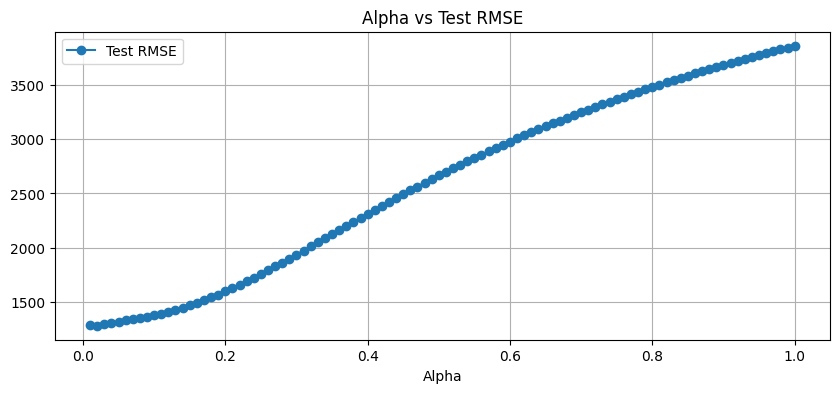

In [76]:
## View the Smoothing Effect (alpha vs RMSE plot)
resultsDf_6_model.plot(x='Alpha', y='Test RMSE', figsize=(10, 4), title="Alpha vs Test RMSE", marker='o')
plt.grid()
plt.show()

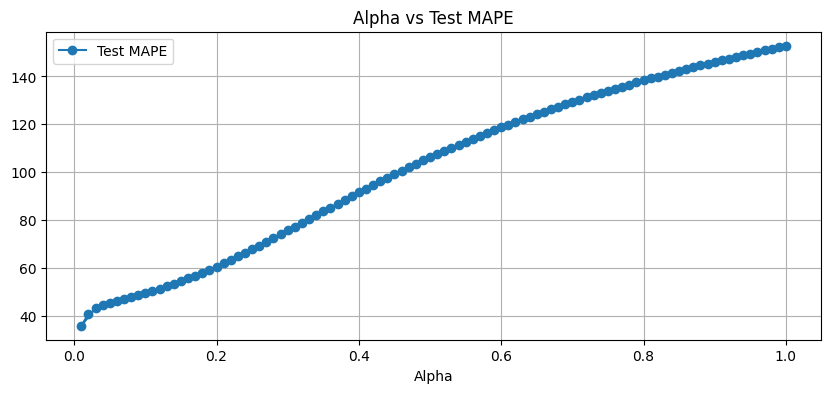

In [77]:
resultsDf_6_model.plot(x='Alpha', y='Test MAPE', figsize=(10, 4), title="Alpha vs Test MAPE", marker='o')
plt.grid()
plt.show()

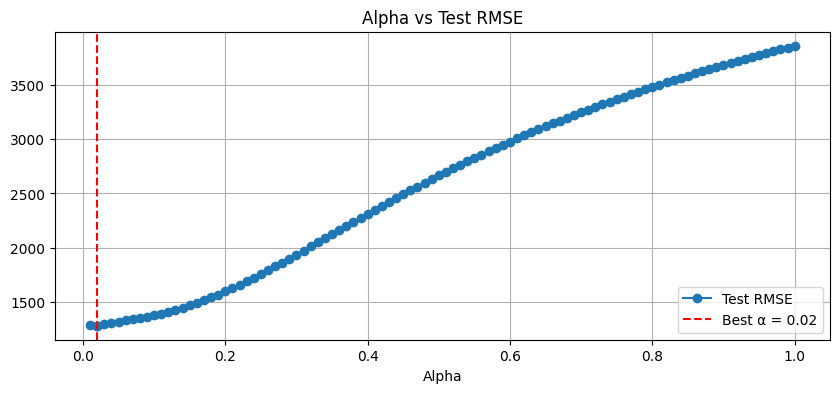

In [78]:
best_row = resultsDf_6_model.loc[resultsDf_6_model['Test RMSE'].idxmin()]
best_alpha = best_row['Alpha']
best_rmse = best_row['Test RMSE']

# Plot with marker for best alpha
ax = resultsDf_6_model.plot(x='Alpha', y='Test RMSE', figsize=(10, 4), title="Alpha vs Test RMSE", marker='o')
plt.axvline(best_alpha, color='red', linestyle='--', label=f'Best α = {best_alpha:.2f}')
plt.scatter(best_alpha, best_rmse, color='red')
plt.legend()
plt.grid()
plt.show()

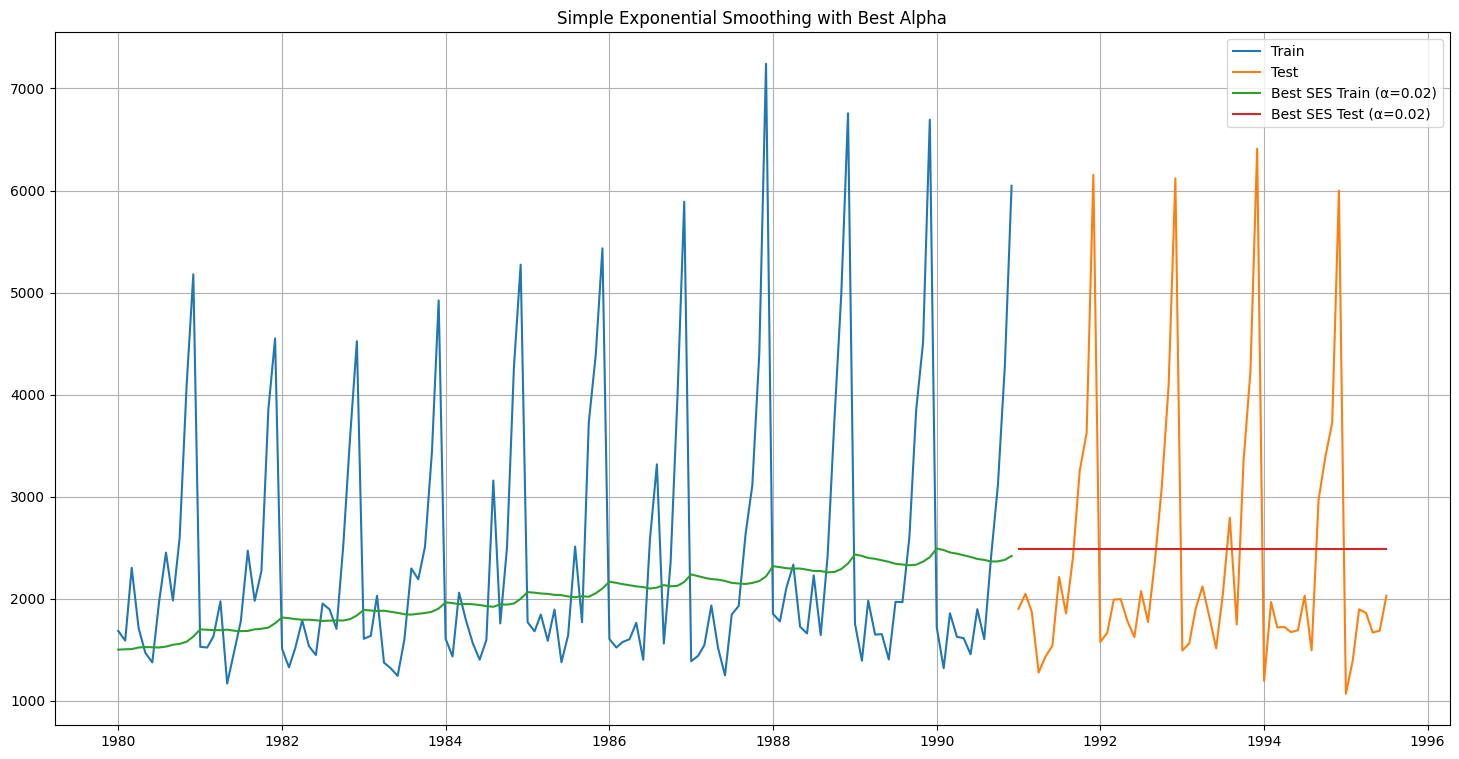

In [79]:
plt.figure(figsize=(18, 9))
plt.plot(train['Sparkling'], label='Train')
plt.plot(test['Sparkling'], label='Test')

plt.plot(best_train_preds, label=f'Best SES Train (α={best_alpha:.2f})')
plt.plot(test.index, best_test_preds, label=f'Best SES Test (α={best_alpha:.2f})')

plt.title('Simple Exponential Smoothing with Best Alpha')
plt.legend()
plt.grid()
plt.show()

In [80]:
log_results(
    f'SES_FixedAlpha={best_alpha:.2f}_Model6',
    RMSE(train['Sparkling'], best_train_preds),
    MAPE(train['Sparkling'], best_train_preds),
    RMSE(test['Sparkling'], best_test_preds),
    MAPE(test['Sparkling'], best_test_preds),
    data_source="original"
)

In [81]:
resultsDF

Model  Train RMSE  Train MAPE  Test RMSE  Test MAPE  \
0      RegressionModel_Model1     1279.32       40.05    1275.87      39.16   
1                Naive_Model2     3867.70      153.17    3864.28     152.87   
2      SimpleAveraging_Model3     1298.48       40.36    1275.08      38.90   
3  2-Point Trailing MA_Model4      689.16       18.01     813.40      19.70   
4  4-Point Trailing MA_Model4     1106.40       34.28    1156.59      35.96   
5  6-Point Trailing MA_Model4     1261.79       42.11    1283.93      43.86   
6  9-Point Trailing MA_Model4     1372.84       45.99    1346.28      46.86   
7   SimpleExpSmoothing_Model5     1317.13       39.05    1304.93      44.48   
8  SES_FixedAlpha=0.02_Model6     1346.26       37.13    1278.50      40.71   

  Data Source  
0    original  
1    original  
2    original  
3    original  
4    original  
5    original  
6    original  
7    original  
8    original

## Model 7: Double Exponential Smoothing (Auto)

In [82]:
from statsmodels.tsa.holtwinters import Holt

# Fitting the model with auto-optimized alpha & beta
model_DES = Holt(train['Sparkling'])
model_DES_fit = model_DES.fit(optimized=True, use_brute=True)

/home/anmol/miniconda3/envs/timeseries/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [83]:
print(model_DES_fit.mle_retvals)

 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: 240445440.04092687
       x: [ 6.886e-01  1.000e-04]
     nit: 1
     jac: [-2.513e+06 -2.076e+08]
    nfev: 3
    njev: 1


**Let's scale the time series and see if it converges**

In [84]:
from sklearn.preprocessing import MinMaxScaler

DES_train = train.copy()
DES_test = test.copy()

# Scale the 'Sparkling' column
scaler = MinMaxScaler()
DES_train['Sparkling_Scaled'] = scaler.fit_transform(DES_train[['Sparkling']])
DES_test['Sparkling_Scaled'] = scaler.transform(DES_test[['Sparkling']])

In [85]:
# Fit the Holt model
model_DES = Holt(DES_train['Sparkling_Scaled'], initialization_method='estimated')
model_DES_fit = model_DES.fit(optimized=True)

# Store alpha & beta
alpha = round(model_DES_fit.params['smoothing_level'], 2)
beta = round(model_DES_fit.params['smoothing_trend'], 2)
print(f" DES Model fitted on scaled data → α={alpha}, β={beta}")

 DES Model fitted on scaled data → α=0.65, β=0.0


In [86]:
print(model_DES_fit.summary())

                              Holt Model Results                              
Dep. Variable:       Sparkling_Scaled   No. Observations:                  132
Model:                           Holt   SSE                              6.405
Optimized:                       True   AIC                           -391.405
Trend:                       Additive   BIC                           -379.874
Seasonal:                        None   AICC                          -390.733
Seasonal Periods:                None   Date:                 Sat, 12 Apr 2025
Box-Cox:                        False   Time:                         19:00:37
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.6478965                alpha                 True
smoothing_trend           2.6641e-15                

In [87]:
model_DES_fit.params_formatted

name         param  optimized
smoothing_level  alpha  6.478965e-01       True
smoothing_trend   beta  2.664053e-15       True
initial_level      l.0  8.246345e-02       True
initial_trend      b.0  4.457434e-03       True

In [88]:
# Predictions In Scaled Form
DES_train['DES_Pred_Scaled'] = model_DES_fit.fittedvalues
DES_test['DES_Pred_Scaled'] = model_DES_fit.forecast(steps=len(DES_test))

In [89]:
# Inverse Transform the Predictions
DES_train['DES_Pred'] = scaler.inverse_transform(DES_train[['DES_Pred_Scaled']])
DES_test['DES_Pred'] = scaler.inverse_transform(DES_test[['DES_Pred_Scaled']])

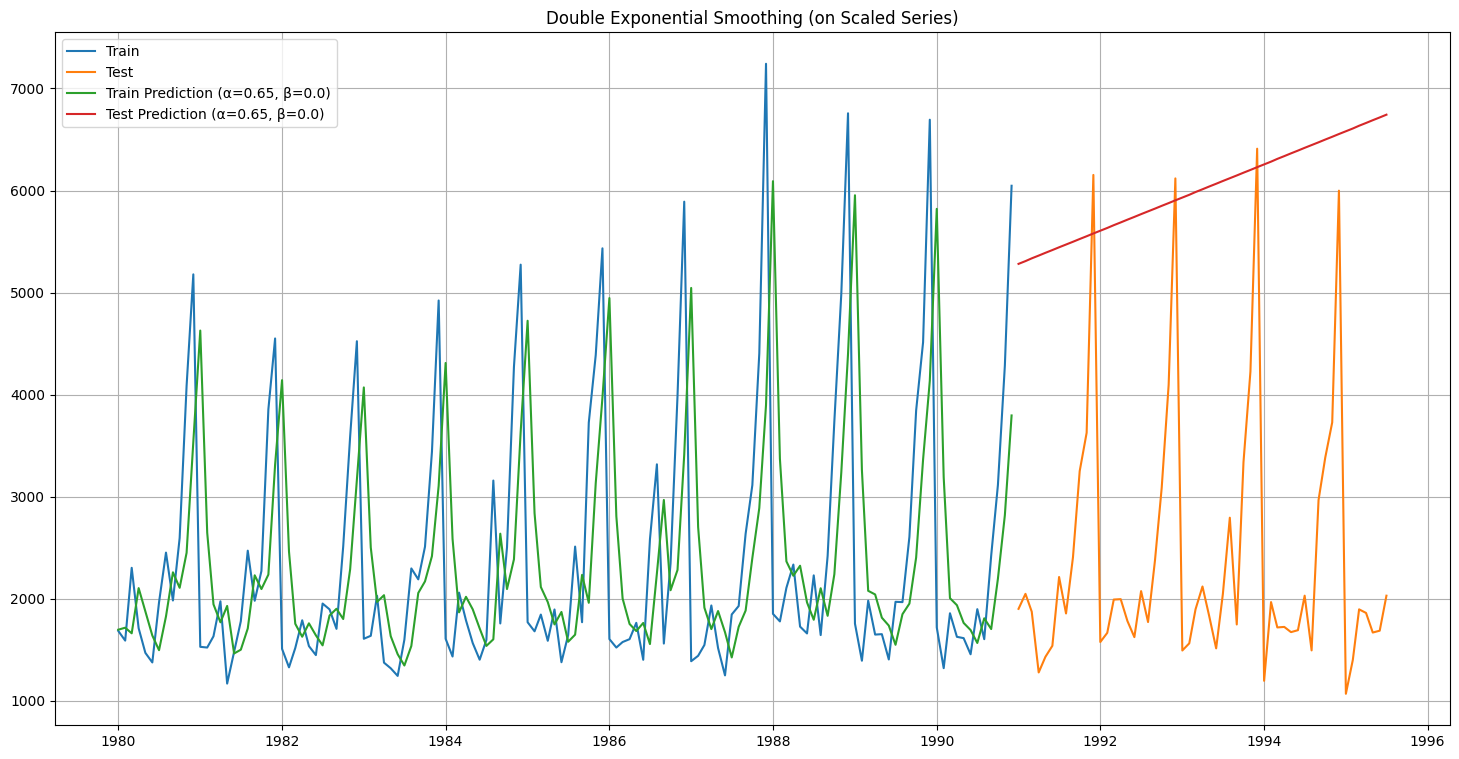

In [90]:
plt.figure(figsize=(18, 9))
plt.plot(DES_train['Sparkling'], label='Train')
plt.plot(DES_test['Sparkling'], label='Test')
plt.plot(DES_train['DES_Pred'], label=f'Train Prediction (α={alpha}, β={beta})')
plt.plot(DES_test['DES_Pred'], label=f'Test Prediction (α={alpha}, β={beta})')
plt.title('Double Exponential Smoothing (on Scaled Series)')
plt.legend()
plt.grid()
plt.show()

In [91]:
rmse_model7_train = RMSE(DES_train['Sparkling'], DES_train['DES_Pred'])
mape_model7_train = MAPE(DES_train['Sparkling'], DES_train['DES_Pred'])

rmse_model7_test = RMSE(DES_test['Sparkling'], DES_test['DES_Pred'])
mape_model7_test = MAPE(DES_test['Sparkling'], DES_test['DES_Pred'])

print(f"Model 7 (DES) - Train RMSE: {rmse_model7_train}, Train MAPE: {mape_model7_train}% | Test RMSE: {rmse_model7_test}, Test MAPE: {mape_model7_test}%")

Model 7 (DES) - Train RMSE: 1337.48, Train MAPE: 39.11% | Test RMSE: 3851.44, Test MAPE: 152.08%


In [92]:
log_results(
    f'DoubleExpSmoothing_Alpha={alpha}_Beta={beta}_Model7',
    rmse_model7_train, mape_model7_train,
    rmse_model7_test, mape_model7_test,
    data_source="original"
)

In [93]:
resultsDF

Model  Train RMSE  Train MAPE  \
0                         RegressionModel_Model1     1279.32       40.05   
1                                   Naive_Model2     3867.70      153.17   
2                         SimpleAveraging_Model3     1298.48       40.36   
3                     2-Point Trailing MA_Model4      689.16       18.01   
4                     4-Point Trailing MA_Model4     1106.40       34.28   
5                     6-Point Trailing MA_Model4     1261.79       42.11   
6                     9-Point Trailing MA_Model4     1372.84       45.99   
7                      SimpleExpSmoothing_Model5     1317.13       39.05   
8                     SES_FixedAlpha=0.02_Model6     1346.26       37.13   
9  DoubleExpSmoothing_Alpha=0.65_Beta=0.0_Model7     1337.48       39.11   

   Test RMSE  Test MAPE Data Source  
0    1275.87      39.16    original  
1    3864.28     152.87    original  
2    1275.08      38.90    original  
3     813.40      19.70    original  
4    1156.59      35.96    original  
5    1283.93      43.86    original  
6    1346.28      46.86    original  
7    1304.93      44.48    original  
8    1278.50      40.71    original  
9    3851.44     152.08    original

## Model 8: Double Exponential Smoothing Model (0.01 to 1)

In [94]:
## Getting the Scaled Dataset
DES_train = train.copy()
DES_test = test.copy()

# Scale 'Sparkling' column
scaler = MinMaxScaler()
DES_train['Sparkling_Scaled'] = scaler.fit_transform(DES_train[['Sparkling']])
DES_test['Sparkling_Scaled'] = scaler.transform(DES_test[['Sparkling']])

In [95]:
grid_results = []

best_rmse = float('inf')
best_model = None
best_alpha, best_beta = None, None
best_train_preds, best_test_preds = None, None

In [96]:
for alpha in np.arange(0.1, 1.1, 0.1):
    for beta in np.arange(0.1, 1.1, 0.1):
        try:
            model = Holt(DES_train['Sparkling_Scaled'], initialization_method='estimated')
            model_fit = model.fit(
                smoothing_level=alpha,
                smoothing_trend=beta,
                optimized=False
            )
            
            train_preds_scaled = model_fit.fittedvalues
            test_preds_scaled = model_fit.forecast(steps=len(DES_test))

            # Inverse transform predictions
            train_preds = scaler.inverse_transform(train_preds_scaled.to_frame())
            test_preds = scaler.inverse_transform(test_preds_scaled.to_frame())

            # Evaluate
            rmse_train = RMSE(DES_train['Sparkling'], train_preds.flatten())
            mape_train = MAPE(DES_train['Sparkling'], train_preds.flatten())
            rmse_test = RMSE(DES_test['Sparkling'], test_preds.flatten())
            mape_test = MAPE(DES_test['Sparkling'], test_preds.flatten())

            # Store results
            grid_results.append({
                'Alpha': alpha,
                'Beta': beta,
                'Train RMSE': rmse_train,
                'Train MAPE': mape_train,
                'Test RMSE': rmse_test,
                'Test MAPE': mape_test
            })

            # Track best model
            if rmse_test < best_rmse:
                best_rmse = rmse_test
                best_model = model_fit
                best_alpha, best_beta = alpha, beta
                best_train_preds = train_preds
                best_test_preds = test_preds

        except:
            continue


In [97]:
resultsDf_8 = pd.DataFrame(grid_results)
resultsDf_8 = resultsDf_8.sort_values(by='Test RMSE', ascending=True).reset_index(drop=True)
display(resultsDf_8.head())

Alpha  Beta  Train RMSE  Train MAPE  Test RMSE  Test MAPE
0    0.1   0.1     1373.32       45.10    1777.73      67.16
1    0.1   0.2     1403.49       45.78    2599.31      95.42
2    0.2   0.1     1413.42       46.70    3611.77     135.41
3    0.1   0.3     1434.78       46.87    4287.47     155.22
4    0.3   0.1     1428.61       46.95    5908.19     223.50

In [98]:
best_row = resultsDf_8.sort_values('Test RMSE').iloc[0]
best_alpha = best_row['Alpha']
best_beta = best_row['Beta']

print(f"Best Parameters from Grid Search - α: {best_alpha}, β: {best_beta}")

Best Parameters from Grid Search - α: 0.1, β: 0.1


In [99]:
final_model_DES = Holt(DES_train['Sparkling_Scaled'], initialization_method='estimated')
final_model_fit = final_model_DES.fit(
    smoothing_level=best_alpha,
    smoothing_trend=best_beta)

In [100]:
# Full summary
print(final_model_fit.summary())

                              Holt Model Results                              
Dep. Variable:       Sparkling_Scaled   No. Observations:                  132
Model:                           Holt   SSE                              6.656
Optimized:                       True   AIC                           -386.324
Trend:                       Additive   BIC                           -374.793
Seasonal:                        None   AICC                          -385.652
Seasonal Periods:                None   Date:                 Sat, 12 Apr 2025
Box-Cox:                        False   Time:                         19:00:38
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.1000000                alpha                False
smoothing_trend            0.1000000                

In [101]:
# Clean param printout
final_model_fit.params_formatted

name     param  optimized
smoothing_level  alpha  0.100000      False
smoothing_trend   beta  0.100000      False
initial_level      l.0  0.151281       True
initial_trend      b.0  0.002099       True

In [102]:
final_model_fit.sse

np.float64(6.655859426695498)

In [103]:
# Scaled predictions
train_preds_scaled = final_model_fit.fittedvalues
test_preds_scaled = final_model_fit.forecast(steps=len(DES_test))

In [104]:
# Inverse transform
train_preds = scaler.inverse_transform(train_preds_scaled.to_frame())
test_preds = scaler.inverse_transform(test_preds_scaled.to_frame())

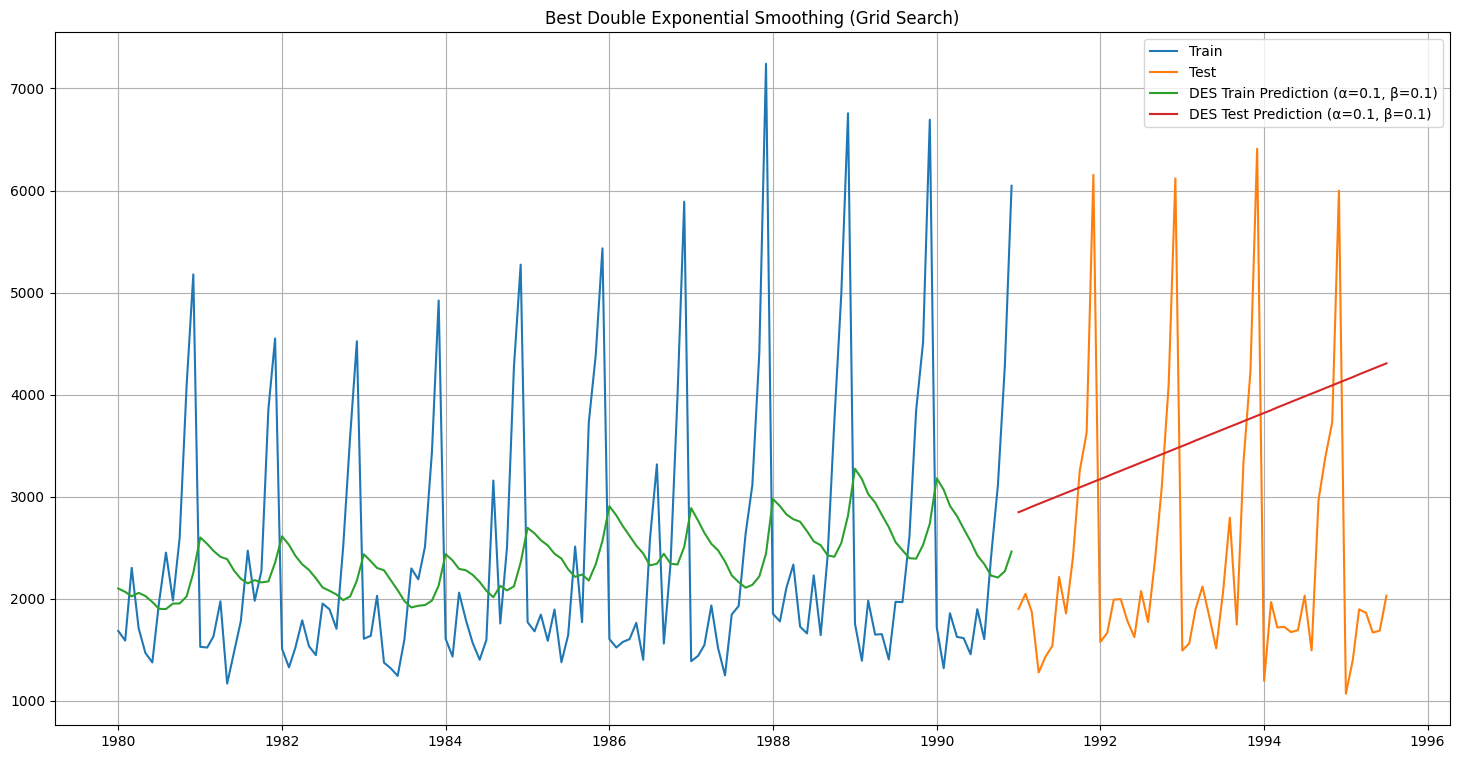

In [105]:
plt.figure(figsize=(18, 9))
plt.plot(DES_train['Sparkling'], label='Train')
plt.plot(DES_test['Sparkling'], label='Test')

plt.plot(DES_train.index, train_preds, label=f'DES Train Prediction (α={best_alpha}, β={best_beta})')
plt.plot(DES_test.index, test_preds, label=f'DES Test Prediction (α={best_alpha}, β={best_beta})')


plt.title('Best Double Exponential Smoothing (Grid Search)')
plt.legend()
plt.grid()
plt.show()

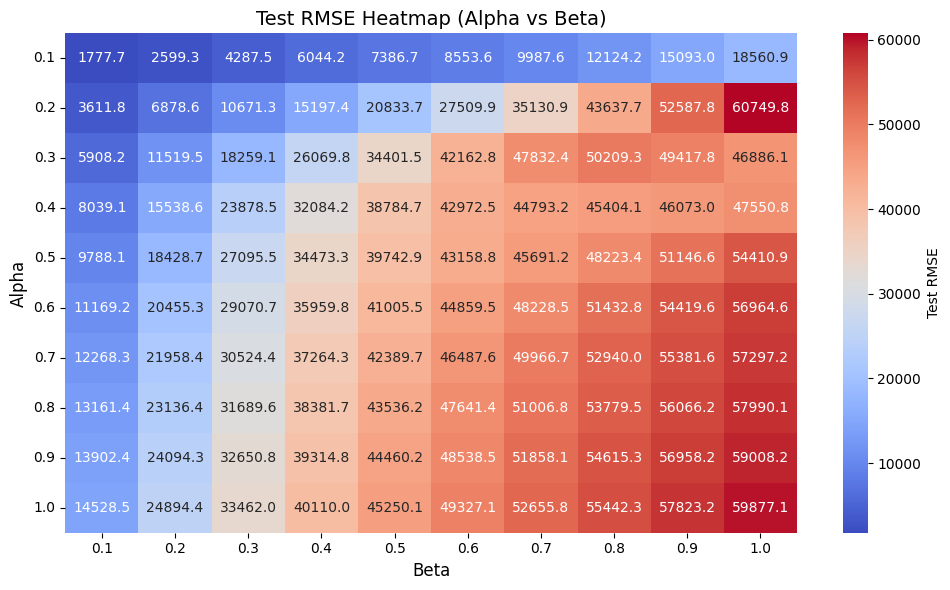

In [106]:
# Recreate pivot table from resultsDf_8
pivot_rmse = resultsDf_8.pivot(index='Alpha', columns='Beta', values='Test RMSE')
pivot_rmse.index = pivot_rmse.index.round(1)
pivot_rmse.columns = pivot_rmse.columns.round(1)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_rmse, annot=True, fmt='.1f', cmap='coolwarm', cbar_kws={'label': 'Test RMSE'})
plt.title('Test RMSE Heatmap (Alpha vs Beta)', fontsize=14)
plt.xlabel('Beta', fontsize=12)
plt.ylabel('Alpha', fontsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [107]:
log_results(
    f'DES_GridSearch_Alpha={best_alpha}_Beta={best_beta}_Model8',
    RMSE(DES_train['Sparkling'], train_preds.flatten()),
    MAPE(DES_train['Sparkling'], train_preds.flatten()),
    RMSE(DES_test['Sparkling'], test_preds.flatten()),
    MAPE(DES_test['Sparkling'], test_preds.flatten()),
    data_source="original" 
)

In [108]:
resultsDF

Model  Train RMSE  Train MAPE  \
0                          RegressionModel_Model1     1279.32       40.05   
1                                    Naive_Model2     3867.70      153.17   
2                          SimpleAveraging_Model3     1298.48       40.36   
3                      2-Point Trailing MA_Model4      689.16       18.01   
4                      4-Point Trailing MA_Model4     1106.40       34.28   
5                      6-Point Trailing MA_Model4     1261.79       42.11   
6                      9-Point Trailing MA_Model4     1372.84       45.99   
7                       SimpleExpSmoothing_Model5     1317.13       39.05   
8                      SES_FixedAlpha=0.02_Model6     1346.26       37.13   
9   DoubleExpSmoothing_Alpha=0.65_Beta=0.0_Model7     1337.48       39.11   
10       DES_GridSearch_Alpha=0.1_Beta=0.1_Model8     1363.47       44.26   

    Test RMSE  Test MAPE Data Source  
0     1275.87      39.16    original  
1     3864.28     152.87    original  
2     1275.08      38.90    original  
3      813.40      19.70    original  
4     1156.59      35.96    original  
5     1283.93      43.86    original  
6     1346.28      46.86    original  
7     1304.93      44.48    original  
8     1278.50      40.71    original  
9     3851.44     152.08    original  
10    1779.42      67.23    original

## Model 9: Triple Exponential Smoothing (Auto)

In [109]:
# scaling the train and test data
TES_train = train.copy()
TES_test = test.copy()

scaler = MinMaxScaler()
TES_train['Sparkling_Scaled'] = scaler.fit_transform(TES_train[['Sparkling']])
TES_test['Sparkling_Scaled'] = scaler.transform(TES_test[['Sparkling']])

In [110]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_TES = ExponentialSmoothing(
    TES_train['Sparkling_Scaled'],
    trend='add',
    seasonal='add',
    seasonal_periods=12,
    initialization_method='estimated'
)

model_TES_fit = model_TES.fit(optimized=True)

In [111]:
print(model_TES_fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:         Sparkling_Scaled   No. Observations:                  132
Model:             ExponentialSmoothing   SSE                              0.493
Optimized:                         True   AIC                           -705.928
Trend:                         Additive   BIC                           -659.804
Seasonal:                      Additive   AICC                          -699.875
Seasonal Periods:                    12   Date:                 Sat, 12 Apr 2025
Box-Cox:                          False   Time:                         19:00:39
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0822175                alpha                 True
smoothing_trend          

In [112]:
model_TES_fit.params

{'smoothing_level': np.float64(0.08221752240836347),
 'smoothing_trend': np.float64(0.0),
 'smoothing_seasonal': np.float64(0.4739686334961928),
 'damping_trend': nan,
 'initial_level': np.float64(0.19470079131454532),
 'initial_trend': np.float64(4.473156699822993e-05),
 'initial_seasons': array([-0.11379323, -0.12612954, -0.04929607, -0.08447161, -0.1437464 ,
        -0.14449936, -0.06514733,  0.02132671, -0.05264532,  0.04064388,
         0.27483033,  0.44221422]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [113]:
# get the predictions
train_preds_scaled = model_TES_fit.fittedvalues
test_preds_scaled = model_TES_fit.forecast(len(TES_test))

In [114]:
# Inverse transform predictions
train_preds_TES = scaler.inverse_transform(train_preds_scaled.to_frame())
test_preds_TES = scaler.inverse_transform(test_preds_scaled.to_frame())

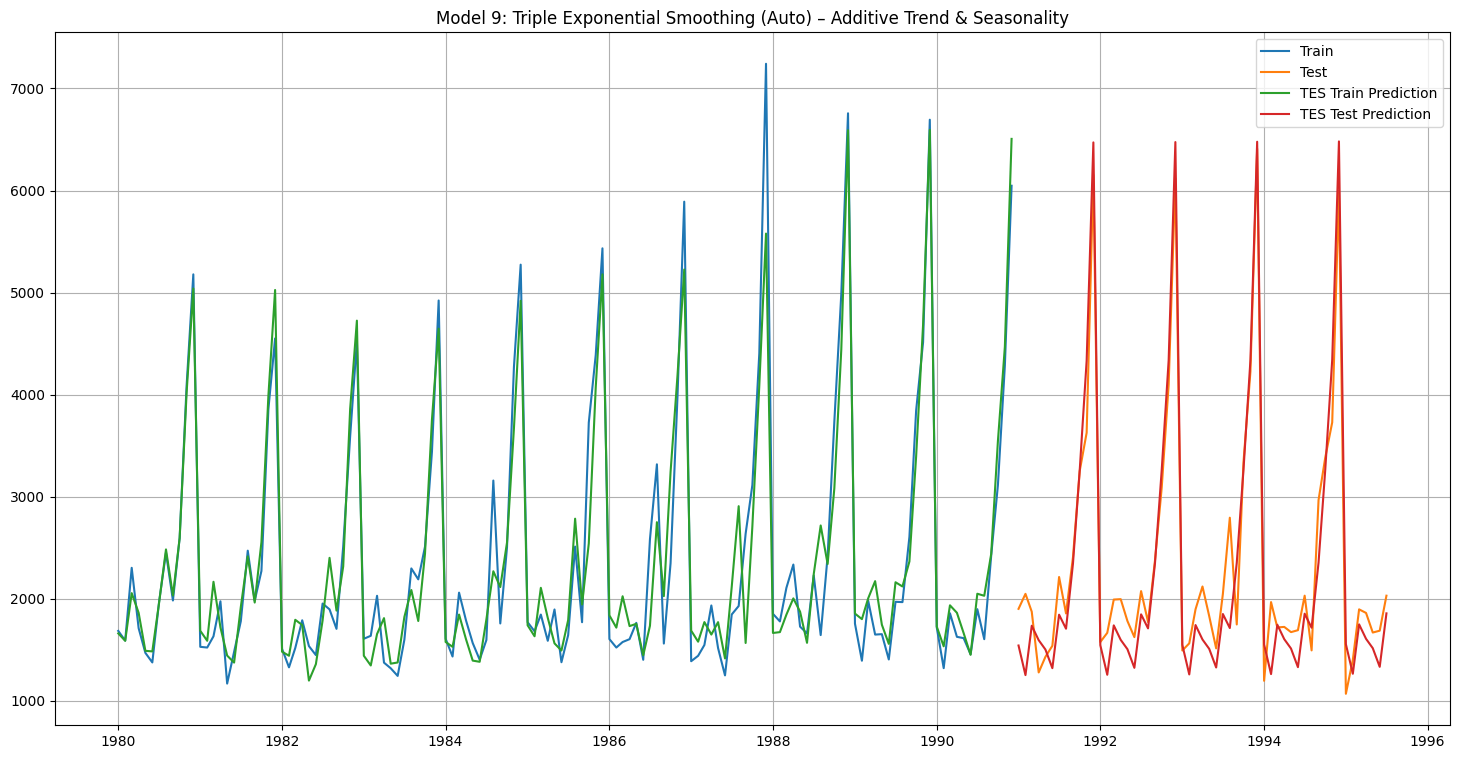

In [115]:
plt.figure(figsize=(18, 9))
plt.plot(TES_train.index, TES_train['Sparkling'], label='Train')
plt.plot(TES_test.index, TES_test['Sparkling'], label='Test')

plt.plot(TES_train.index, train_preds_TES, label='TES Train Prediction')
plt.plot(TES_test.index, test_preds_TES, label='TES Test Prediction')

plt.title('Model 9: Triple Exponential Smoothing (Auto) – Additive Trend & Seasonality')
plt.legend()
plt.grid()
plt.show()

In [116]:
rmse_model9_train = RMSE(TES_train['Sparkling'], train_preds_TES.flatten())
mape_model9_train = MAPE(TES_train['Sparkling'], train_preds_TES.flatten())

rmse_model9_test = RMSE(TES_test['Sparkling'], test_preds_TES.flatten())
mape_model9_test = MAPE(TES_test['Sparkling'], test_preds_TES.flatten())

print(f"Model 9 (TES Auto) - Train RMSE: {rmse_model9_train}, Train MAPE: {mape_model9_train}% | Test RMSE: {rmse_model9_test}, Test MAPE: {mape_model9_test}%")

Model 9 (TES Auto) - Train RMSE: 371.02, Train MAPE: 10.88% | Test RMSE: 357.89, Test MAPE: 11.83%


In [117]:
log_results(
    f'TES_Auto_AddTrend_AddSeasonality_Model9',
    rmse_model9_train, mape_model9_train,
    rmse_model9_test, mape_model9_test,
    data_source="original"
)

In [118]:
resultsDF

Model  Train RMSE  Train MAPE  \
0                          RegressionModel_Model1     1279.32       40.05   
1                                    Naive_Model2     3867.70      153.17   
2                          SimpleAveraging_Model3     1298.48       40.36   
3                      2-Point Trailing MA_Model4      689.16       18.01   
4                      4-Point Trailing MA_Model4     1106.40       34.28   
5                      6-Point Trailing MA_Model4     1261.79       42.11   
6                      9-Point Trailing MA_Model4     1372.84       45.99   
7                       SimpleExpSmoothing_Model5     1317.13       39.05   
8                      SES_FixedAlpha=0.02_Model6     1346.26       37.13   
9   DoubleExpSmoothing_Alpha=0.65_Beta=0.0_Model7     1337.48       39.11   
10       DES_GridSearch_Alpha=0.1_Beta=0.1_Model8     1363.47       44.26   
11        TES_Auto_AddTrend_AddSeasonality_Model9      371.02       10.88   

    Test RMSE  Test MAPE Data Source  
0     1275.87      39.16    original  
1     3864.28     152.87    original  
2     1275.08      38.90    original  
3      813.40      19.70    original  
4     1156.59      35.96    original  
5     1283.93      43.86    original  
6     1346.28      46.86    original  
7     1304.93      44.48    original  
8     1278.50      40.71    original  
9     3851.44     152.08    original  
10    1779.42      67.23    original  
11     357.89      11.83    original

## 10. Triple Exponential Smoothing (0.3 - 1.1)

In [119]:
# 1. Create scaled train/test
TES_train = train.copy()
TES_test = test.copy()

scaler = MinMaxScaler()
TES_train['Sparkling_Scaled'] = scaler.fit_transform(TES_train[['Sparkling']])
TES_test['Sparkling_Scaled'] = scaler.transform(TES_test[['Sparkling']])

In [120]:
grid_results = []
best_rmse = float('inf')
best_model = None
best_params = {}

In [121]:
alphas = betas = gammas = np.arange(0.3, 1.1, 0.1)

for alpha in alphas:
    for beta in betas:
        for gamma in gammas:
            try:
                model = ExponentialSmoothing(
                    TES_train['Sparkling_Scaled'],
                    trend='add',
                    seasonal='add',
                    seasonal_periods=12,
                    initialization_method='estimated'
                )
                model_fit = model.fit(
                    smoothing_level=alpha,
                    smoothing_trend=beta,
                    smoothing_seasonal=gamma,
                    optimized=False
                )

                # Scaled predictions
                train_preds_scaled = model_fit.fittedvalues
                test_preds_scaled = model_fit.forecast(len(TES_test))

                # Inverse transform
                train_preds = scaler.inverse_transform(train_preds_scaled.to_frame())
                test_preds = scaler.inverse_transform(test_preds_scaled.to_frame())

                # Evaluate
                rmse_train = RMSE(TES_train['Sparkling'], train_preds.flatten())
                mape_train = MAPE(TES_train['Sparkling'], train_preds.flatten())
                rmse_test = RMSE(TES_test['Sparkling'], test_preds.flatten())
                mape_test = MAPE(TES_test['Sparkling'], test_preds.flatten())

                # Save result
                grid_results.append({
                    'Alpha': alpha, 'Beta': beta, 'Gamma': gamma,
                    'Train RMSE': rmse_train, 'Train MAPE': mape_train,
                    'Test RMSE': rmse_test, 'Test MAPE': mape_test
                })

                # Track best
                if rmse_test < best_rmse:
                    best_rmse = rmse_test
                    best_model = model_fit
                    best_params = {
                        'Alpha': alpha,
                        'Beta': beta,
                        'Gamma': gamma,
                        'train_preds': train_preds,
                        'test_preds': test_preds
                    }

            except Exception as e:
                continue

In [122]:
resultsDf_10 = pd.DataFrame(grid_results)
resultsDf_10 = resultsDf_10.sort_values(by='Test RMSE').reset_index(drop=True)
display(resultsDf_10.head())

Alpha  Beta  Gamma  Train RMSE  Train MAPE  Test RMSE  Test MAPE
0    0.5   0.3    0.4      477.40       14.36     649.20      21.59
1    0.3   0.3    1.0      538.86       16.51     687.21      23.95
2    0.4   0.3    0.3      464.06       14.10     734.72      26.26
3    1.0   0.5    0.3      660.10       20.14     769.36      27.82
4    0.6   0.3    0.7      569.84       17.84     926.41      31.62

In [123]:
# extract the best model params
best_row = resultsDf_10.iloc[0]
best_alpha = best_row['Alpha']
best_beta = best_row['Beta']
best_gamma = best_row['Gamma']

print(f"Best TES Grid Params - α={best_alpha}, β={best_beta}, γ={best_gamma}")


Best TES Grid Params - α=0.5, β=0.3, γ=0.4


In [124]:
# best model with optimized=False on scaled data
final_model_TES = ExponentialSmoothing(
    TES_train['Sparkling_Scaled'],
    trend='add',
    seasonal='add',
    seasonal_periods=12,
    initialization_method='estimated'
)


final_model_fit_TES = final_model_TES.fit(
    smoothing_level=best_alpha,
    smoothing_trend=best_beta,
    smoothing_seasonal=best_gamma,
    optimized=False
)

In [125]:
print(final_model_fit_TES.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:         Sparkling_Scaled   No. Observations:                  132
Model:             ExponentialSmoothing   SSE                              0.816
Optimized:                        False   AIC                           -639.374
Trend:                         Additive   BIC                           -593.249
Seasonal:                      Additive   AICC                          -633.321
Seasonal Periods:                    12   Date:                 Sat, 12 Apr 2025
Box-Cox:                          False   Time:                         19:00:43
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.5000000                alpha                False
smoothing_trend          

In [126]:
final_model_fit_TES.params

{'smoothing_level': 0.5,
 'smoothing_trend': 0.3,
 'smoothing_seasonal': 0.4,
 'damping_trend': nan,
 'initial_level': np.float64(0.1954120004391743),
 'initial_trend': np.float64(-0.0015120323791272296),
 'initial_seasons': array([-0.10477382, -0.11906243, -0.06566328, -0.07796531, -0.13313316,
        -0.13427398, -0.06327871,  0.01201396, -0.03909667,  0.04485082,
         0.25383434,  0.42654823]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [127]:
# model predictions
train_preds_scaled = final_model_fit_TES.fittedvalues
test_preds_scaled = final_model_fit_TES.forecast(len(TES_test))

In [128]:
# inverse predictions
train_preds = scaler.inverse_transform(train_preds_scaled.to_frame())
test_preds = scaler.inverse_transform(test_preds_scaled.to_frame())

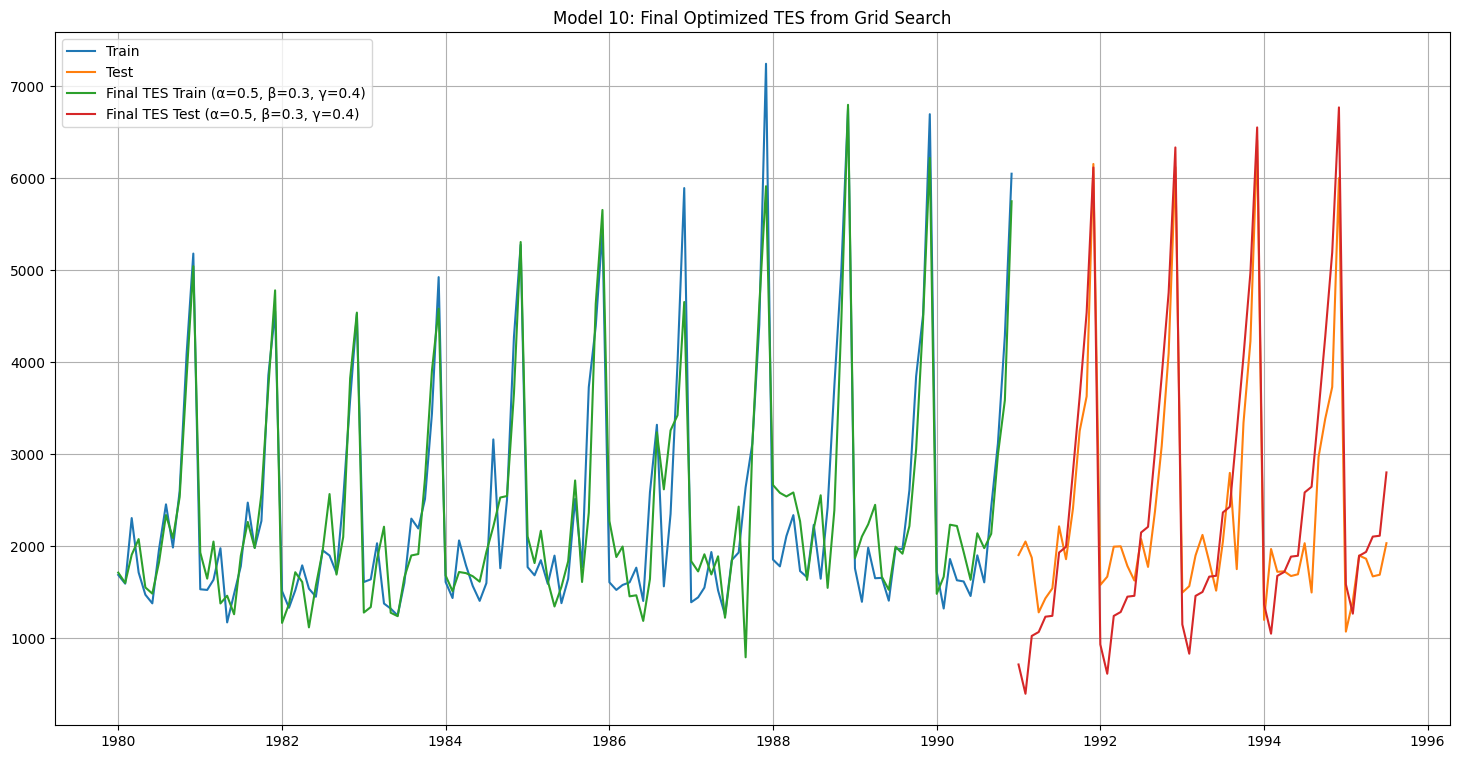

In [129]:
plt.figure(figsize=(18, 9))
plt.plot(TES_train.index, TES_train['Sparkling'], label='Train')
plt.plot(TES_test.index, TES_test['Sparkling'], label='Test')

plt.plot(TES_train.index, train_preds, label=f"Final TES Train (α={best_alpha}, β={best_beta}, γ={best_gamma})")
plt.plot(TES_test.index, test_preds, label=f"Final TES Test (α={best_alpha}, β={best_beta}, γ={best_gamma})")

plt.title('Model 10: Final Optimized TES from Grid Search')
plt.legend()
plt.grid()
plt.show()

In [130]:
rmse_model10_train = RMSE(TES_train['Sparkling'], train_preds.flatten())
mape_model10_train = MAPE(TES_train['Sparkling'], train_preds.flatten())

rmse_model10_test = RMSE(TES_test['Sparkling'], test_preds.flatten())
mape_model10_test = MAPE(TES_test['Sparkling'], test_preds.flatten())

In [131]:
print(f"Model 10 (Final TES) - Train RMSE: {rmse_model10_train}, MAPE: {mape_model10_train}%")
print(f"Model 10 (Final TES) - Test RMSE: {rmse_model10_test}, MAPE: {mape_model10_test}%")

log_results(
    f"TES_Final_Alpha={best_alpha}_Beta={best_beta}_Gamma={best_gamma}_Model10",
    rmse_model10_train, mape_model10_train,
    rmse_model10_test, mape_model10_test,
    data_source = "original"
)

Model 10 (Final TES) - Train RMSE: 477.4, MAPE: 14.36%
Model 10 (Final TES) - Test RMSE: 649.2, MAPE: 21.59%


In [132]:
resultsDF

Model  Train RMSE  Train MAPE  \
0                           RegressionModel_Model1     1279.32       40.05   
1                                     Naive_Model2     3867.70      153.17   
2                           SimpleAveraging_Model3     1298.48       40.36   
3                       2-Point Trailing MA_Model4      689.16       18.01   
4                       4-Point Trailing MA_Model4     1106.40       34.28   
5                       6-Point Trailing MA_Model4     1261.79       42.11   
6                       9-Point Trailing MA_Model4     1372.84       45.99   
7                        SimpleExpSmoothing_Model5     1317.13       39.05   
8                       SES_FixedAlpha=0.02_Model6     1346.26       37.13   
9    DoubleExpSmoothing_Alpha=0.65_Beta=0.0_Model7     1337.48       39.11   
10        DES_GridSearch_Alpha=0.1_Beta=0.1_Model8     1363.47       44.26   
11         TES_Auto_AddTrend_AddSeasonality_Model9      371.02       10.88   
12  TES_Final_Alpha=0.5_Beta=0.3_Gamma=0.4_Model10      477.40       14.36   

    Test RMSE  Test MAPE Data Source  
0     1275.87      39.16    original  
1     3864.28     152.87    original  
2     1275.08      38.90    original  
3      813.40      19.70    original  
4     1156.59      35.96    original  
5     1283.93      43.86    original  
6     1346.28      46.86    original  
7     1304.93      44.48    original  
8     1278.50      40.71    original  
9     3851.44     152.08    original  
10    1779.42      67.23    original  
11     357.89      11.83    original  
12     649.20      21.59    original

## 11. ARIMA Model based on AIC Optimization

In [133]:
p = q = range(0,4)
d = [1]

# combinations
import itertools
pdq = list(itertools.product(p,d,q))
print(f"Total ARIMA combinations to evaluate: {len(pdq)}")

Total ARIMA combinations to evaluate: 16


In [134]:
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm  # Progress bar

ARIMA_AIC = pd.DataFrame(columns=['param', 'AIC'])

for param in tqdm(pdq):
    try:
        model = ARIMA(train['Sparkling'], order=param)
        model_fit = model.fit()
        ARIMA_AIC.loc[len(ARIMA_AIC)] = [param, model_fit.aic]
    except:
        continue

# Sort by AIC
ARIMA_AIC = ARIMA_AIC.sort_values(by='AIC').reset_index(drop=True)
ARIMA_AIC

 25%|███████████                                 | 4/16 [00:00<00:00, 25.03it/s]/home/anmol/miniconda3/envs/timeseries/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 62%|██████████████████████████▉                | 10/16 [00:00<00:00, 17.41it/s]/home/anmol/miniconda3/envs/timeseries/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 88%|█████████████████████████████████████▋     | 14/16 [00:01<00:00, 10.84it/s]/home/anmol/miniconda3/envs/timeseries/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/

param          AIC
0   (2, 1, 2)  2213.509213
1   (3, 1, 3)  2221.455953
2   (3, 1, 2)  2231.362624
3   (2, 1, 3)  2232.840421
4   (2, 1, 1)  2233.777626
5   (0, 1, 3)  2233.994858
6   (0, 1, 2)  2234.408323
7   (1, 1, 2)  2234.527200
8   (3, 1, 1)  2235.500538
9   (1, 1, 3)  2235.607816
10  (1, 1, 1)  2235.755095
11  (3, 1, 0)  2257.723379
12  (2, 1, 0)  2260.365744
13  (0, 1, 1)  2263.060016
14  (1, 1, 0)  2266.608539
15  (0, 1, 0)  2267.663036

In [135]:
best_order = ARIMA_AIC.iloc[0]['param']
print(f"Best ARIMA order based on AIC: {best_order}")

Best ARIMA order based on AIC: (2, 1, 2)


In [136]:
from statsmodels.tsa.arima.model import ARIMA

final_arima_model = ARIMA(train['Sparkling'], order=best_order)
final_arima_fit = final_arima_model.fit()

In [137]:
final_arima_fit.mle_retvals

{'fopt': np.float64(8.346625808196348),
 'gopt': array([ 7.38218375e-06, -6.04689632e-06, -3.86304322e-06,  3.55271368e-10,
        -6.09290397e-08]),
 'fcalls': 330,
 'warnflag': 0,
 'converged': True,
 'iterations': 45}

In [138]:
print(final_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Sparkling   No. Observations:                  132
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1101.755
Date:                Sat, 12 Apr 2025   AIC                           2213.509
Time:                        19:00:45   BIC                           2227.885
Sample:                    01-01-1980   HQIC                          2219.351
                         - 12-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3121      0.046     28.782      0.000       1.223       1.401
ar.L2         -0.5593      0.072     -7.740      0.000      -0.701      -0.418
ma.L1         -1.9917      0.109    -18.216      0.0

In [139]:
print(final_arima_fit.params)

ar.L1     1.312096e+00
ar.L2    -5.592867e-01
ma.L1    -1.991680e+00
ma.L2     9.999310e-01
sigma2    1.098865e+06
dtype: float64


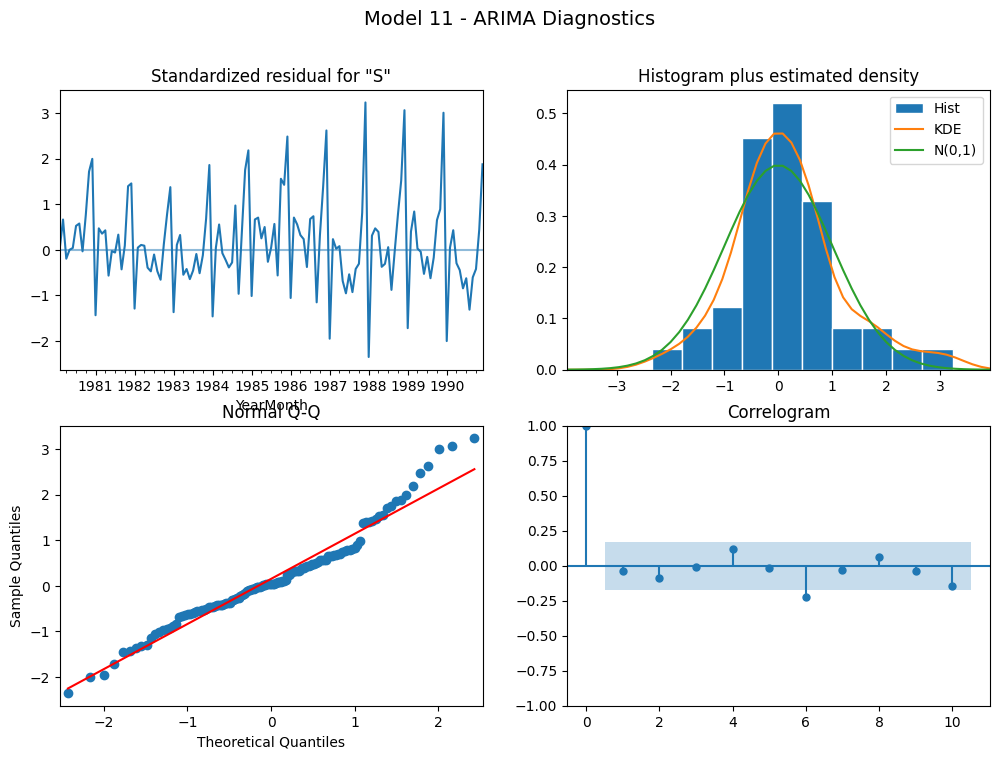

In [140]:
final_arima_fit.plot_diagnostics(figsize=(12, 8))
plt.suptitle("Model 11 - ARIMA Diagnostics", fontsize=14)
plt.show()

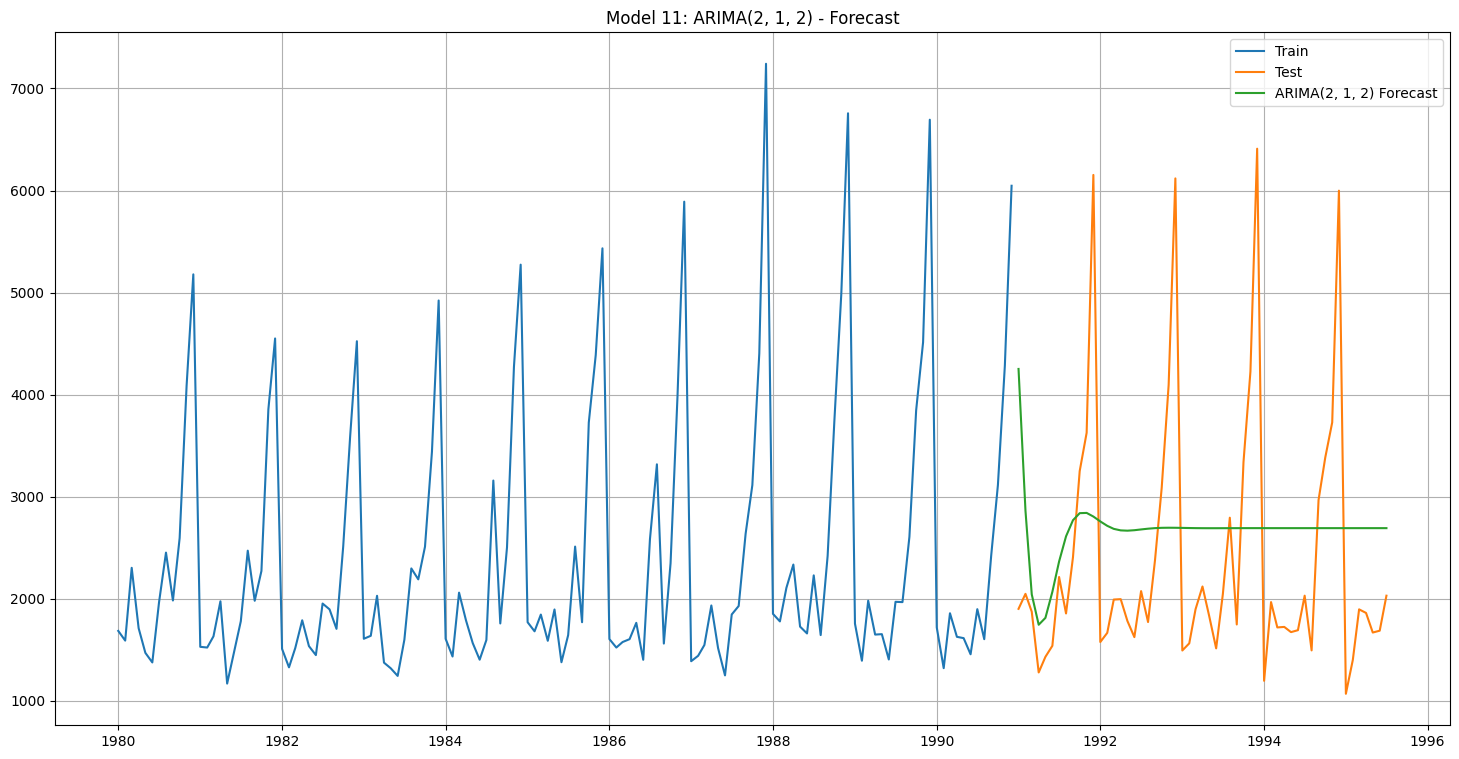

In [141]:
predicted_autoARIMA = final_arima_fit.forecast(steps=len(test))

plt.figure(figsize=(18, 9))
plt.plot(train['Sparkling'], label='Train')
plt.plot(test['Sparkling'], label='Test')
plt.plot(test.index, predicted_autoARIMA, label=f"ARIMA{best_order} Forecast")

plt.title(f"Model 11: ARIMA{best_order} - Forecast")
plt.legend()
plt.grid()
plt.show()

In [142]:
# Get in-sample predictions (on training data)
train_preds_arima = final_arima_fit.predict(start=train.index[0], end=train.index[-1])

# Evaluate
rmse_arima_train = RMSE(train['Sparkling'], train_preds_arima)
mape_arima_train = MAPE(train['Sparkling'], train_preds_arima)

print(f"Model 11 ARIMA - Train RMSE: {rmse_arima_train}, MAPE: {mape_arima_train}%")

Model 11 ARIMA - Train RMSE: 1082.42, MAPE: 32.88%


In [143]:
rmse_arima_test = RMSE(test['Sparkling'], predicted_autoARIMA)
mape_arima_test = MAPE(test['Sparkling'], predicted_autoARIMA)

print(f"Model 11 (ARIMA{best_order}) - RMSE: {rmse_arima_test}, MAPE: {mape_arima_test}%")

Model 11 (ARIMA(2, 1, 2)) - RMSE: 1299.98, MAPE: 43.2%


In [144]:
log_results(
    f'ARIMA_{best_order}_Model11',
    rmse_arima_train, mape_arima_train, 
    rmse_arima_test, mape_arima_test,
    data_source='original data | 1st diff in Model' 
)

In [145]:
resultsDF

Model  Train RMSE  Train MAPE  \
0                           RegressionModel_Model1     1279.32       40.05   
1                                     Naive_Model2     3867.70      153.17   
2                           SimpleAveraging_Model3     1298.48       40.36   
3                       2-Point Trailing MA_Model4      689.16       18.01   
4                       4-Point Trailing MA_Model4     1106.40       34.28   
5                       6-Point Trailing MA_Model4     1261.79       42.11   
6                       9-Point Trailing MA_Model4     1372.84       45.99   
7                        SimpleExpSmoothing_Model5     1317.13       39.05   
8                       SES_FixedAlpha=0.02_Model6     1346.26       37.13   
9    DoubleExpSmoothing_Alpha=0.65_Beta=0.0_Model7     1337.48       39.11   
10        DES_GridSearch_Alpha=0.1_Beta=0.1_Model8     1363.47       44.26   
11         TES_Auto_AddTrend_AddSeasonality_Model9      371.02       10.88   
12  TES_Final_Alpha=0.5_Beta=0.3_Gamma=0.4_Model10      477.40       14.36   
13                         ARIMA_(2, 1, 2)_Model11     1082.42       32.88   

    Test RMSE  Test MAPE                        Data Source  
0     1275.87      39.16                           original  
1     3864.28     152.87                           original  
2     1275.08      38.90                           original  
3      813.40      19.70                           original  
4     1156.59      35.96                           original  
5     1283.93      43.86                           original  
6     1346.28      46.86                           original  
7     1304.93      44.48                           original  
8     1278.50      40.71                           original  
9     3851.44     152.08                           original  
10    1779.42      67.23                           original  
11     357.89      11.83                           original  
12     649.20      21.59                           original  
13    1299.98      43.20  original data | 1st diff in Model

## Automated SARIM model (seasonality of 12)

In [146]:
p = q = range(0, 3)
d = [1]  # will turn the data to 1st differencing internally in model
P = Q = range(0, 3)
D = [0] # we are not doing seasonal stationarity
s = 12  # seasonal period

# all combinations
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q))

print(f"Total combinations: {len(pdq) * len(seasonal_pdq)}")

Total combinations: 81


In [147]:
import warnings
import statsmodels.api as sm

SARIMA_AIC = pd.DataFrame(columns=['param', 'seasonal', 'AIC'])

for param in tqdm(pdq):
    for seasonal in seasonal_pdq:
        seasonal_order = (seasonal[0], seasonal[1], seasonal[2], s)
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                model = sm.tsa.statespace.SARIMAX(train['Sparkling'],
                                                  order=param,
                                                  seasonal_order=seasonal_order,
                                                  enforce_stationarity=False,
                                                  enforce_invertibility=False)
                model_fit = model.fit(disp=False)
                SARIMA_AIC.loc[len(SARIMA_AIC)] = [param, seasonal_order, model_fit.aic]
        except Exception as e:
            print(f"Failed for {param} x {seasonal_order} → {e}")

SARIMA_AIC = SARIMA_AIC.sort_values(by='AIC').reset_index(drop=True)
display(SARIMA_AIC.head())

100%|█████████████████████████████████████████████| 9/9 [00:32<00:00,  3.61s/it]


param       seasonal          AIC
0  (1, 1, 2)  (1, 0, 2, 12)  1555.584318
1  (0, 1, 2)  (1, 0, 2, 12)  1557.160507
2  (0, 1, 2)  (2, 0, 2, 12)  1557.299430
3  (2, 1, 2)  (1, 0, 2, 12)  1559.099197
4  (1, 1, 2)  (2, 0, 2, 12)  1562.134335

In [148]:
best_order = SARIMA_AIC.iloc[0]['param']
best_seasonal = SARIMA_AIC.iloc[0]['seasonal']

print(f"Best SARIMA Order: {best_order} x {best_seasonal}")

final_sarima = sm.tsa.statespace.SARIMAX(train['Sparkling'],
                                         order=best_order,
                                         seasonal_order=best_seasonal,
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)
final_sarima_fit = final_sarima.fit(maxiter=2000)

Best SARIMA Order: (1, 1, 2) x (1, 0, 2, 12)


In [149]:
final_sarima_fit.mle_retvals

{'fopt': np.float64(5.839334268892778),
 'gopt': array([ 6.68629596e-06, -1.51514357e-06,  1.17355903e-05, -5.28366684e-05,
        -1.01655573e-05, -1.77461601e-05,  4.32542891e-08]),
 'fcalls': 592,
 'warnflag': 0,
 'converged': True,
 'iterations': 53}

In [150]:
print(final_sarima_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Sparkling   No. Observations:                  132
Model:             SARIMAX(1, 1, 2)x(1, 0, 2, 12)   Log Likelihood                -770.792
Date:                            Sat, 12 Apr 2025   AIC                           1555.584
Time:                                    19:01:20   BIC                           1574.095
Sample:                                01-01-1980   HQIC                          1563.083
                                     - 12-01-1990                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6281      0.255     -2.463      0.014      -1.128      -0.128
ma.L1         -0.1041      0.225   

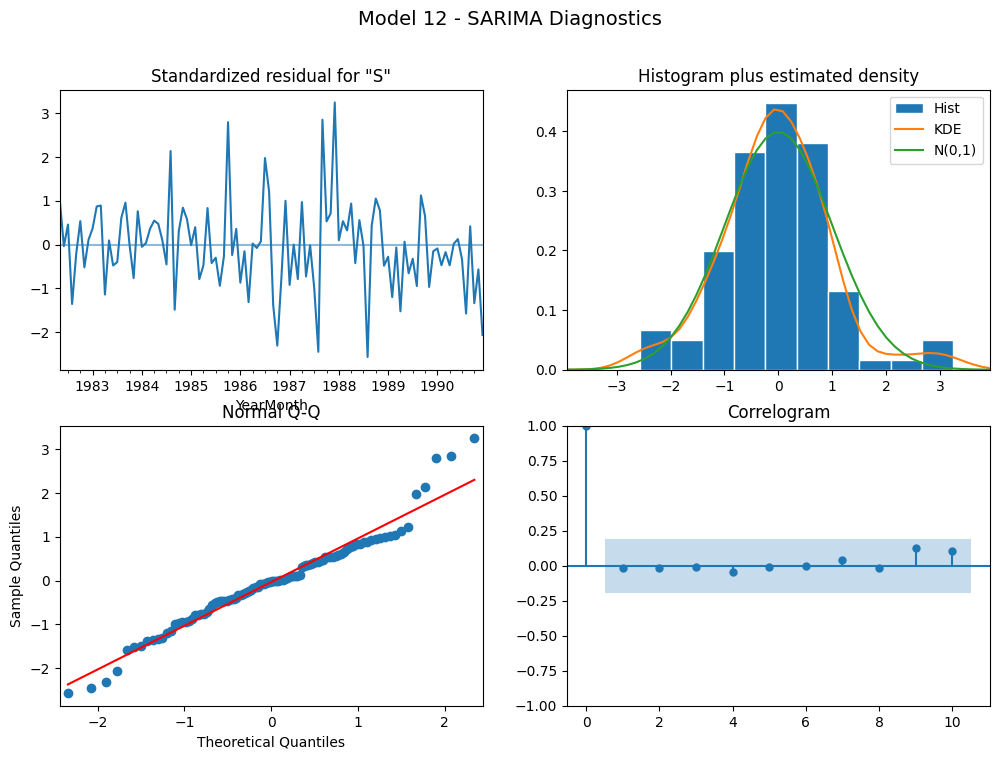

In [151]:
final_sarima_fit.plot_diagnostics(figsize=(12, 8))
plt.suptitle("Model 12 - SARIMA Diagnostics", fontsize=14)
plt.show()

In [152]:
# get the predictions
train_preds_sarima = final_sarima_fit.predict(start=train.index[0], end=train.index[-1], typ='levels')
test_preds_sarima = final_sarima_fit.forecast(steps=len(test))

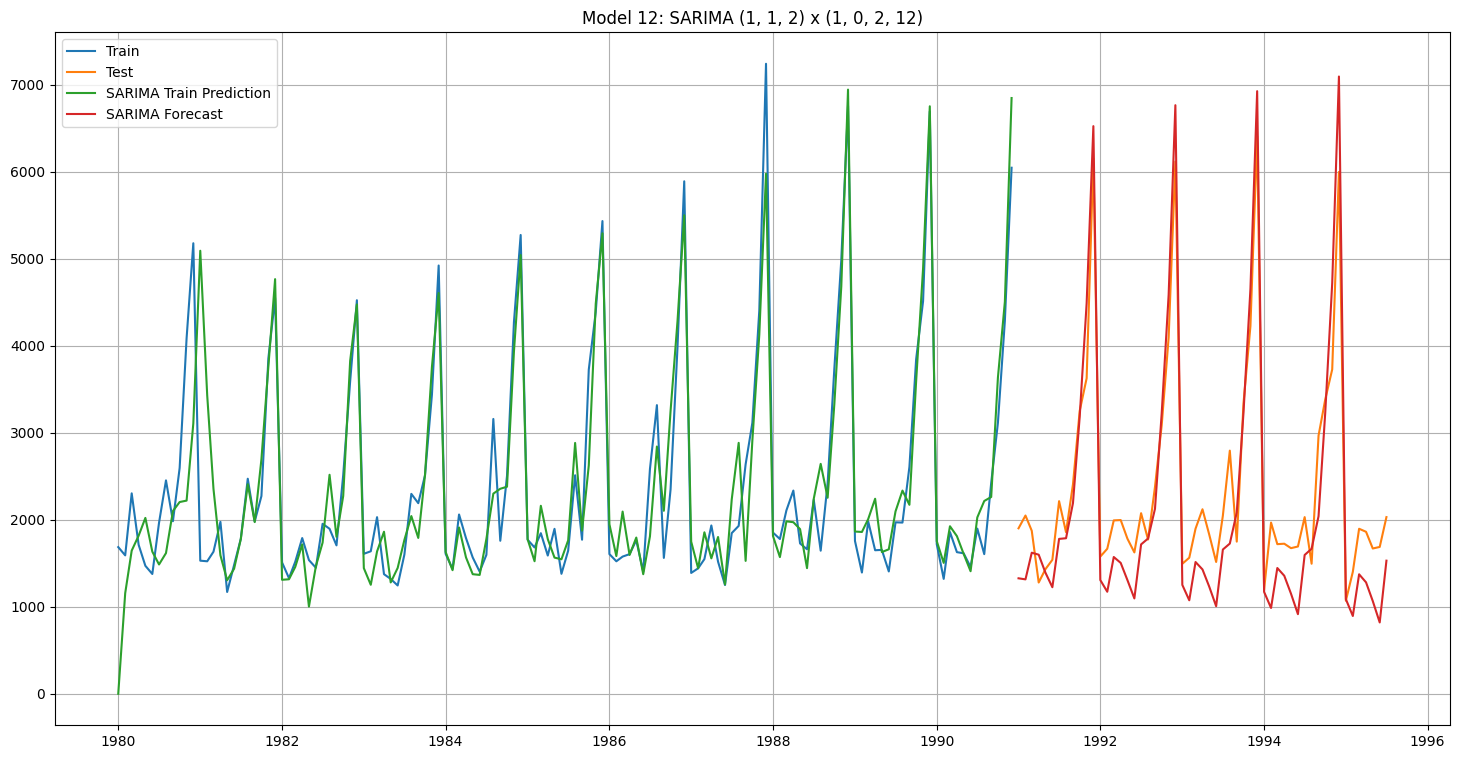

In [153]:
plt.figure(figsize=(18, 9))
plt.plot(train['Sparkling'], label='Train')
plt.plot(test['Sparkling'], label='Test')

plt.plot(train.index, train_preds_sarima, label='SARIMA Train Prediction')
plt.plot(test.index, test_preds_sarima, label='SARIMA Forecast')

plt.title(f"Model 12: SARIMA {best_order} x {best_seasonal}")
plt.legend()
plt.grid()
plt.show()

In [154]:
rmse_sarima_train = RMSE(train['Sparkling'], train_preds_sarima)
mape_sarima_train = MAPE(train['Sparkling'], train_preds_sarima)

rmse_sarima_test = RMSE(test['Sparkling'], test_preds_sarima)
mape_sarima_test = MAPE(test['Sparkling'], test_preds_sarima)

print(f"Model 12 (SARIMA) - Train RMSE: {rmse_sarima_train}, MAPE: {mape_sarima_train}%")
print(f"Model 12 (SARIMA) - Test RMSE: {rmse_sarima_test}, MAPE: {mape_sarima_test}%")

Model 12 (SARIMA) - Train RMSE: 592.29, MAPE: 15.04%
Model 12 (SARIMA) - Test RMSE: 528.59, MAPE: 18.89%


In [155]:
log_results(
    f"SARIMA_{best_order}_x_{best_seasonal}_Model12",
    rmse_sarima_train, mape_sarima_train,
    rmse_sarima_test, mape_sarima_test,
    data_source = "original data | 1st diff Model"
)

In [156]:
resultsDF

Model  Train RMSE  Train MAPE  \
0                           RegressionModel_Model1     1279.32       40.05   
1                                     Naive_Model2     3867.70      153.17   
2                           SimpleAveraging_Model3     1298.48       40.36   
3                       2-Point Trailing MA_Model4      689.16       18.01   
4                       4-Point Trailing MA_Model4     1106.40       34.28   
5                       6-Point Trailing MA_Model4     1261.79       42.11   
6                       9-Point Trailing MA_Model4     1372.84       45.99   
7                        SimpleExpSmoothing_Model5     1317.13       39.05   
8                       SES_FixedAlpha=0.02_Model6     1346.26       37.13   
9    DoubleExpSmoothing_Alpha=0.65_Beta=0.0_Model7     1337.48       39.11   
10        DES_GridSearch_Alpha=0.1_Beta=0.1_Model8     1363.47       44.26   
11         TES_Auto_AddTrend_AddSeasonality_Model9      371.02       10.88   
12  TES_Final_Alpha=0.5_Beta=0.3_Gamma=0.4_Model10      477.40       14.36   
13                         ARIMA_(2, 1, 2)_Model11     1082.42       32.88   
14        SARIMA_(1, 1, 2)_x_(1, 0, 2, 12)_Model12      592.29       15.04   

    Test RMSE  Test MAPE                        Data Source  
0     1275.87      39.16                           original  
1     3864.28     152.87                           original  
2     1275.08      38.90                           original  
3      813.40      19.70                           original  
4     1156.59      35.96                           original  
5     1283.93      43.86                           original  
6     1346.28      46.86                           original  
7     1304.93      44.48                           original  
8     1278.50      40.71                           original  
9     3851.44     152.08                           original  
10    1779.42      67.23                           original  
11     357.89      11.83                           original  
12     649.20      21.59                           original  
13    1299.98      43.20  original data | 1st diff in Model  
14     528.59      18.89     original data | 1st diff Model

## ARIMA with params using ACF and PACF

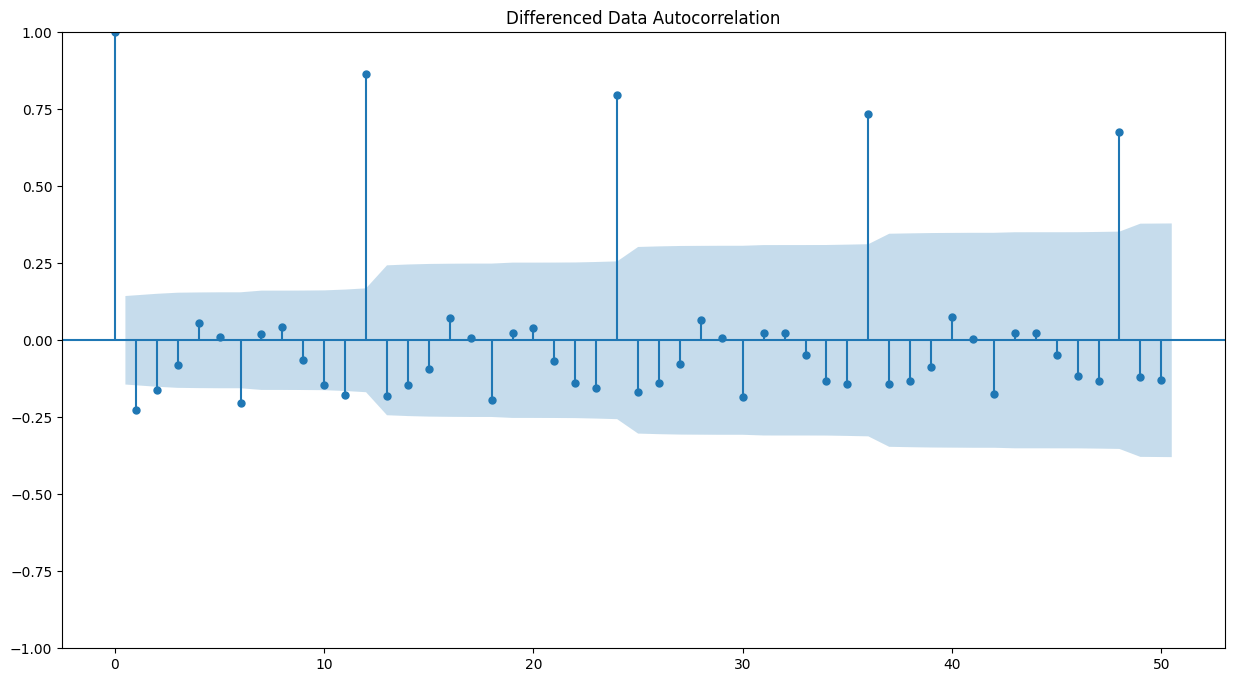

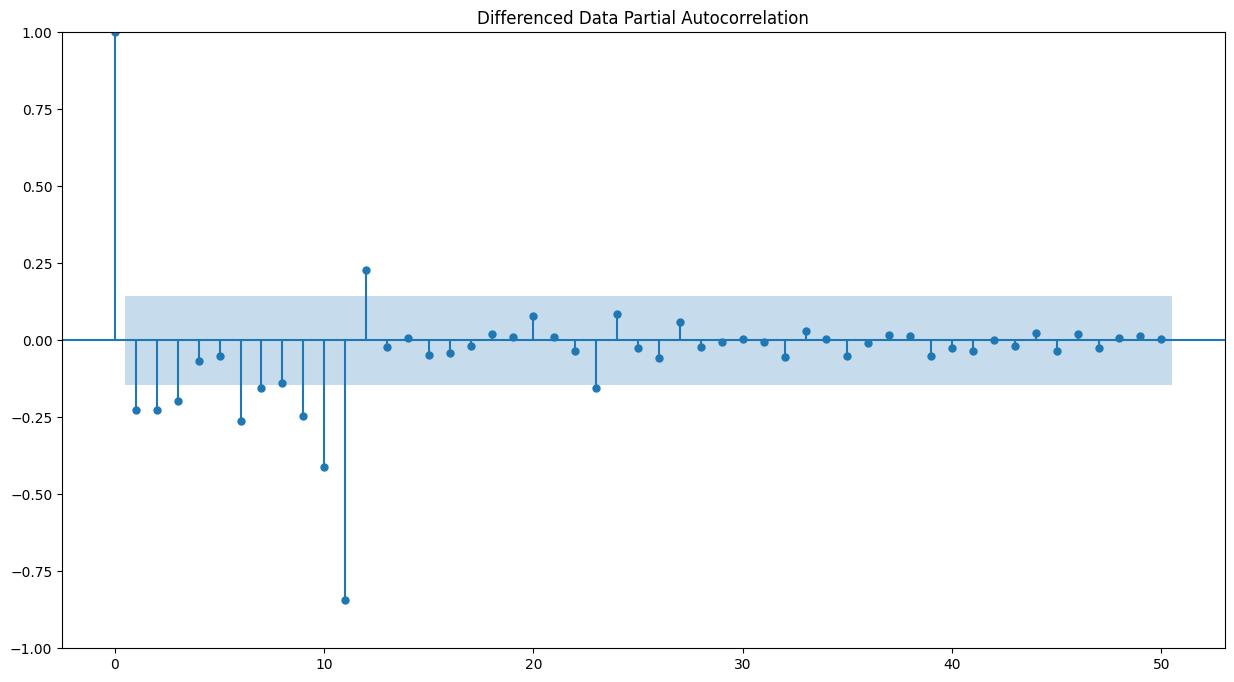

In [157]:
plot_acf(df['Sparkling'].diff(1).dropna(),lags=50,title='Differenced Data Autocorrelation')
plot_pacf(df['Sparkling'].diff(1).dropna(),lags=50,title='Differenced Data Partial Autocorrelation')
plt.show()

In [158]:
manual_train = df.iloc[:int(len(df)*0.71)]
manual_test = df.iloc[int(len(df)*0.71):]

In [159]:
def fit_and_evaluate_arima(order, model_name):
    from statsmodels.tsa.arima.model import ARIMA
    
    # Fit ARIMA on original (non-differenced) series
    model = ARIMA(df['Sparkling'], order=order)  # use your original full series
    model_fit = model.fit()

    print(f"Summary for {model_name}")
    print(model_fit.summary())
    model_fit.plot_diagnostics(figsize=(12, 8))
    plt.suptitle(f"{model_name} Diagnostics")
    plt.show()

    # model params
    print(model_fit.mle_retvals)
    print("\n")
    print(model_fit.params)
    
    # Train predictions
    train_preds = model_fit.predict(start=train.index[0], end=train.index[-1])
    
    # Test forecasts (aligned with test index)
    test_preds = model_fit.forecast(steps=len(test))
    test_preds.index = test.index  # force index match to align for plotting & metrics

    # Evaluation
    rmse_train = RMSE(train['Sparkling'], train_preds)
    mape_train = MAPE(train['Sparkling'], train_preds)

    rmse_test = RMSE(test['Sparkling'], test_preds)
    mape_test = MAPE(test['Sparkling'], test_preds)

    print(f"{model_name} → Train RMSE: {rmse_train}, MAPE: {mape_train}%")
    print(f"{model_name} → Test RMSE: {rmse_test}, MAPE: {mape_test}%")

    # Plot
    plt.figure(figsize=(18, 9))
    plt.plot(train['Sparkling'], label='Train')
    plt.plot(test['Sparkling'], label='Test')
    plt.plot(test_preds, label=f'{model_name} Forecast')
    plt.title(f"{model_name} on Original Series (Forecast Aligned)")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Log results
    log_results(
        f"{model_name}",
        rmse_train, mape_train,
        rmse_test, mape_test,
        data_source = "original data | 1st diff in Model"
    )


Summary for Manual_ARIMA_(2,1,1)_Model13
                               SARIMAX Results                                
Dep. Variable:              Sparkling   No. Observations:                  187
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1584.529
Date:                Sat, 12 Apr 2025   AIC                           3177.059
Time:                        19:01:21   BIC                           3189.962
Sample:                    01-01-1980   HQIC                          3182.288
                         - 07-01-1995                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4205      0.093      4.499      0.000       0.237       0.604
ar.L2         -0.1241      0.182     -0.683      0.494      -0.480       0.232
ma.L1      

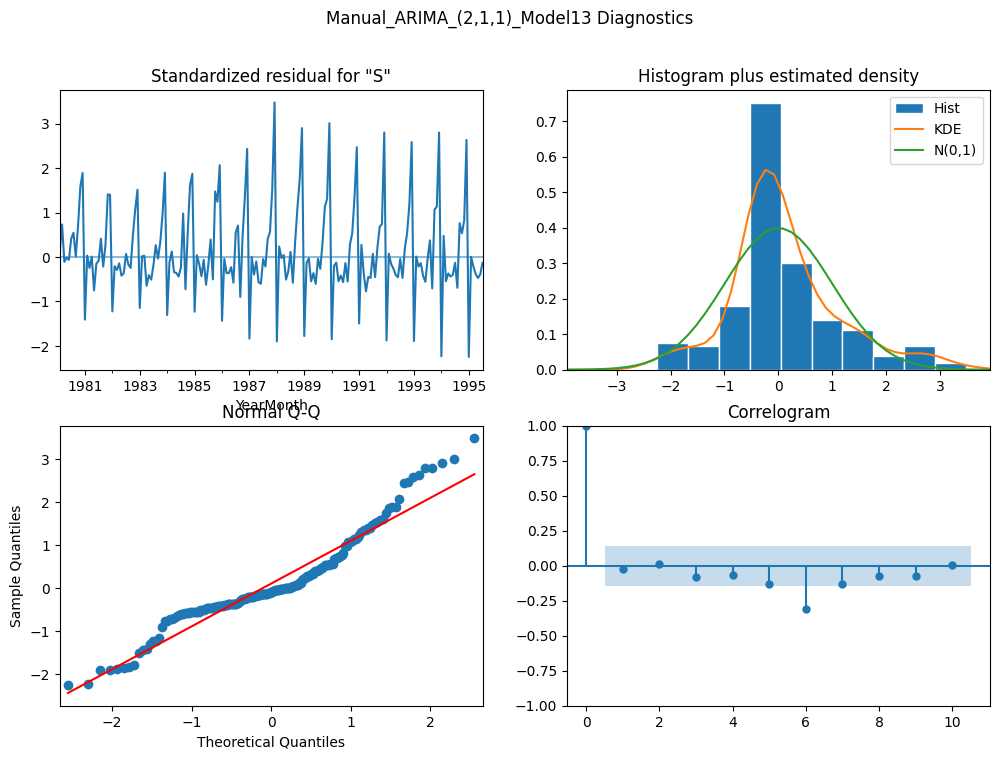

{'fopt': np.float64(8.473419229979516), 'gopt': array([-1.05693232e-06,  1.62714286e-06,  1.77635684e-10, -1.95399253e-09]), 'fcalls': 180, 'warnflag': 0, 'converged': True, 'iterations': 26}


ar.L1     4.205180e-01
ar.L2    -1.241452e-01
ma.L1    -9.999924e-01
sigma2    1.430782e+06
dtype: float64
Manual_ARIMA_(2,1,1)_Model13 → Train RMSE: 1187.82, MAPE: 34.81%
Manual_ARIMA_(2,1,1)_Model13 → Test RMSE: 1274.94, MAPE: 38.65%


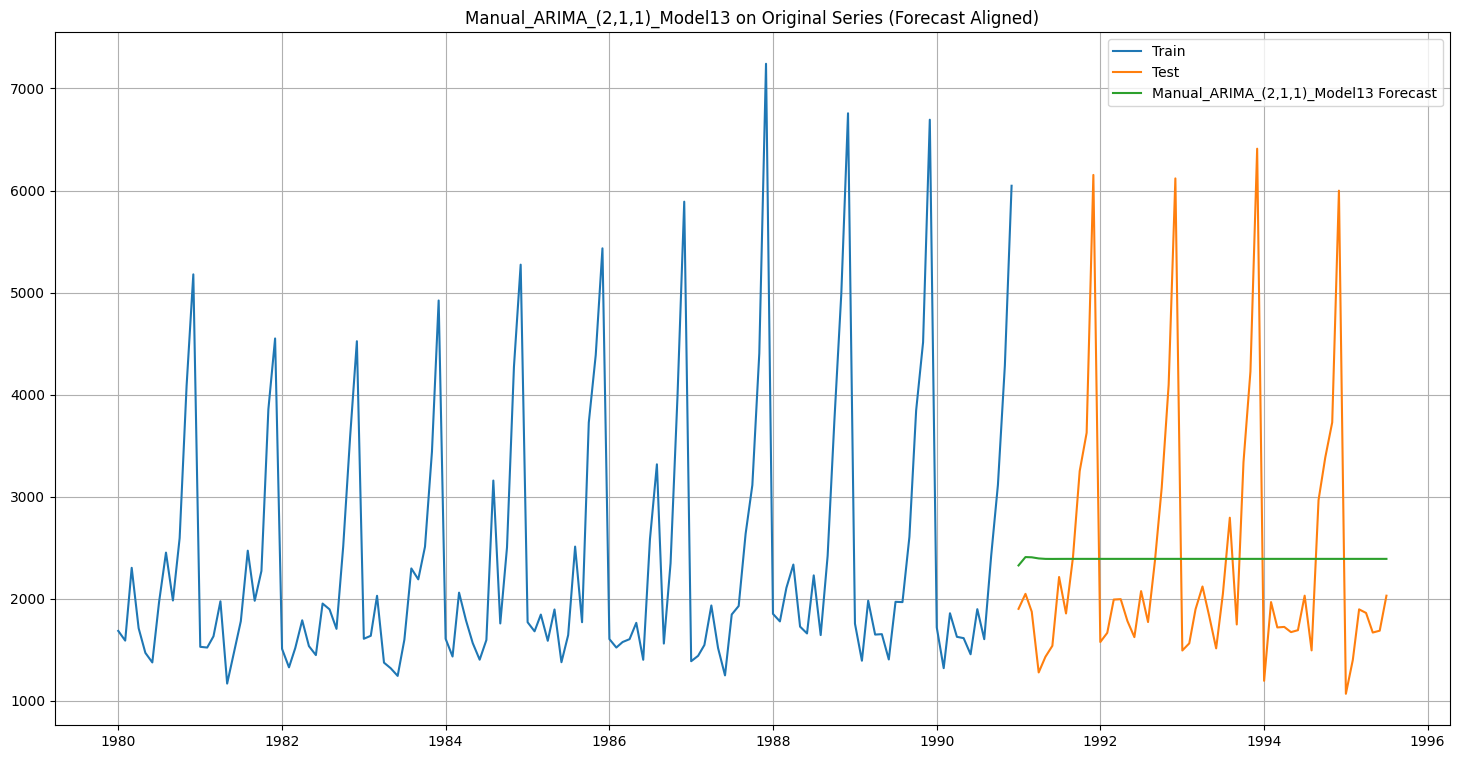

In [160]:
fit_and_evaluate_arima(order=(2,1,1), model_name='Manual_ARIMA_(2,1,1)_Model13')

Summary for Manual_ARIMA_(1,1,2)_Model13
                               SARIMAX Results                                
Dep. Variable:              Sparkling   No. Observations:                  187
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -1584.995
Date:                Sat, 12 Apr 2025   AIC                           3177.990
Time:                        19:01:21   BIC                           3190.893
Sample:                    01-01-1980   HQIC                          3183.219
                         - 07-01-1995                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1928      0.338      0.570      0.569      -0.470       0.856
ma.L1         -0.7814      0.404     -1.932      0.053      -1.574       0.011
ma.L2      

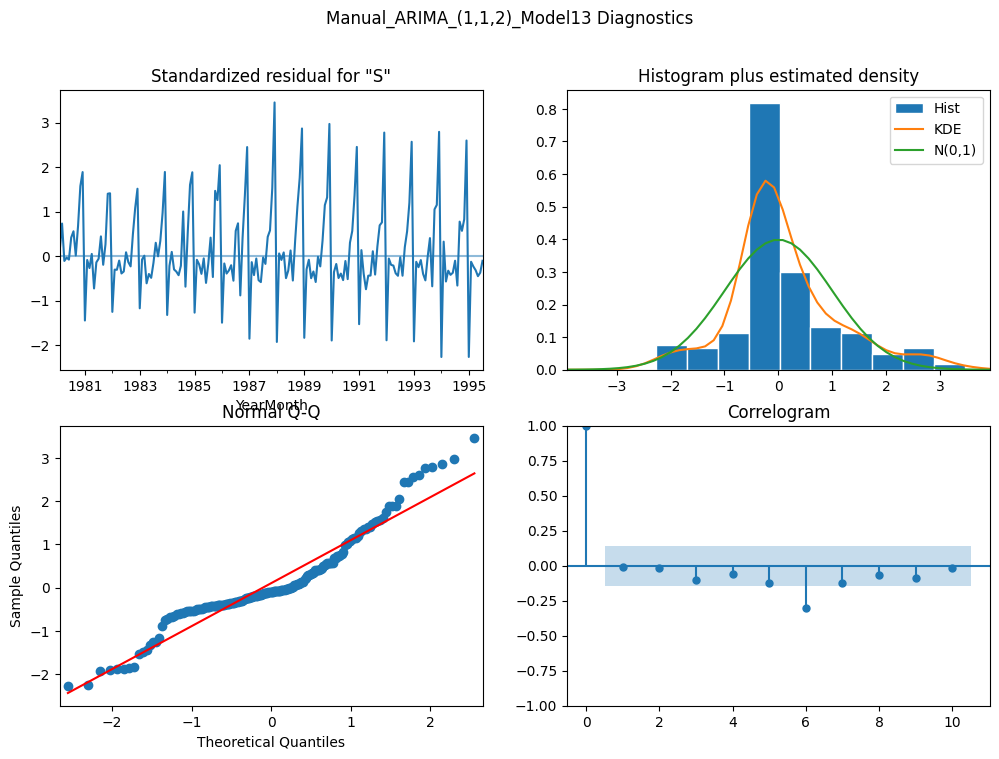

{'fopt': np.float64(8.475908716974583), 'gopt': array([-2.12114770e-06,  0.00000000e+00,  6.66506850e-06,  1.26121336e-08]), 'fcalls': 160, 'warnflag': 0, 'converged': True, 'iterations': 26}


ar.L1     1.928117e-01
ma.L1    -7.813515e-01
ma.L2    -2.186330e-01
sigma2    1.439116e+06
dtype: float64
Manual_ARIMA_(1,1,2)_Model13 → Train RMSE: 1192.36, MAPE: 35.1%
Manual_ARIMA_(1,1,2)_Model13 → Test RMSE: 1274.37, MAPE: 38.55%


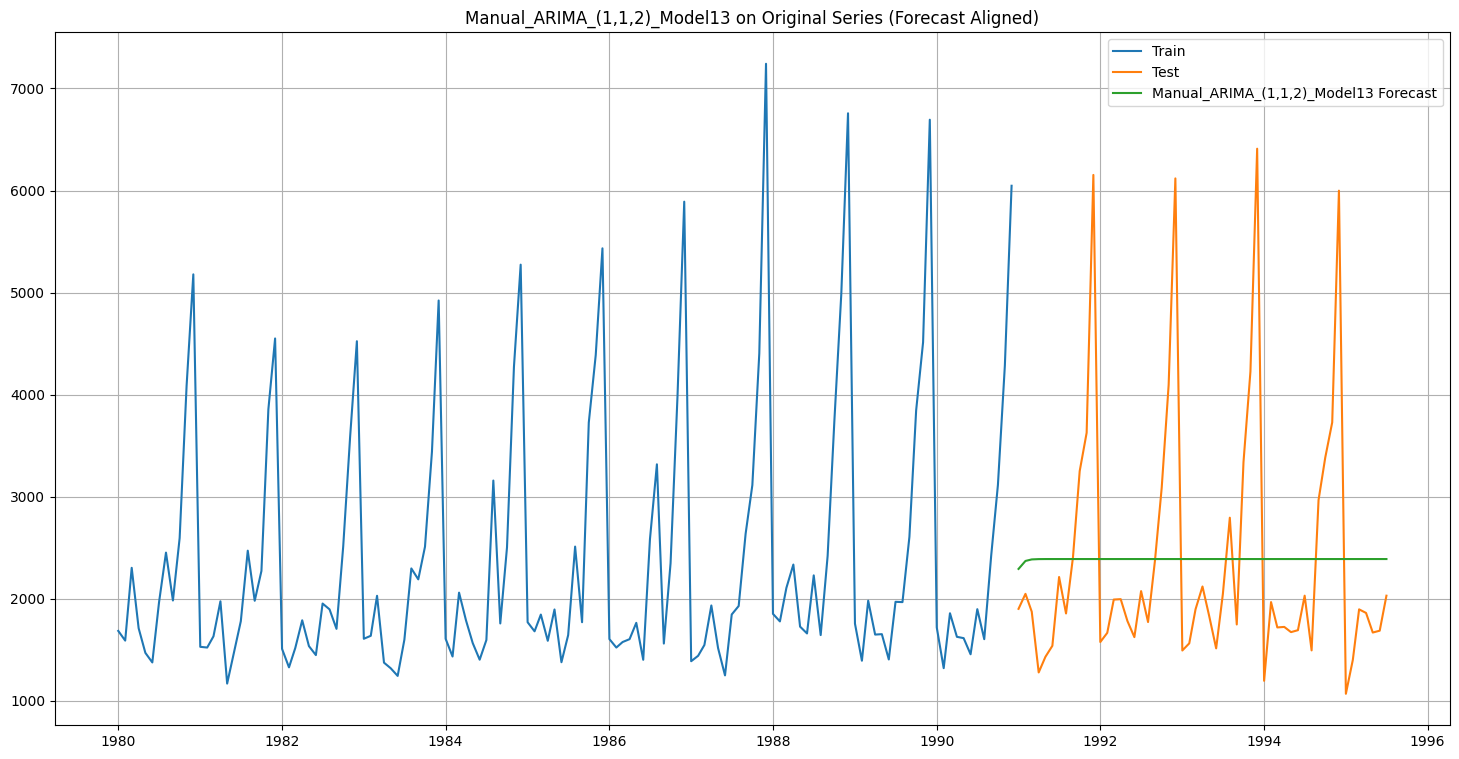

In [161]:
fit_and_evaluate_arima(order=(1,1,2), model_name='Manual_ARIMA_(1,1,2)_Model13')

In [162]:
resultsDF

Model  Train RMSE  Train MAPE  \
0                           RegressionModel_Model1     1279.32       40.05   
1                                     Naive_Model2     3867.70      153.17   
2                           SimpleAveraging_Model3     1298.48       40.36   
3                       2-Point Trailing MA_Model4      689.16       18.01   
4                       4-Point Trailing MA_Model4     1106.40       34.28   
5                       6-Point Trailing MA_Model4     1261.79       42.11   
6                       9-Point Trailing MA_Model4     1372.84       45.99   
7                        SimpleExpSmoothing_Model5     1317.13       39.05   
8                       SES_FixedAlpha=0.02_Model6     1346.26       37.13   
9    DoubleExpSmoothing_Alpha=0.65_Beta=0.0_Model7     1337.48       39.11   
10        DES_GridSearch_Alpha=0.1_Beta=0.1_Model8     1363.47       44.26   
11         TES_Auto_AddTrend_AddSeasonality_Model9      371.02       10.88   
12  TES_Final_Alpha=0.5_Beta=0.3_Gamma=0.4_Model10      477.40       14.36   
13                         ARIMA_(2, 1, 2)_Model11     1082.42       32.88   
14        SARIMA_(1, 1, 2)_x_(1, 0, 2, 12)_Model12      592.29       15.04   
15                    Manual_ARIMA_(2,1,1)_Model13     1187.82       34.81   
16                    Manual_ARIMA_(1,1,2)_Model13     1192.36       35.10   

    Test RMSE  Test MAPE                        Data Source  
0     1275.87      39.16                           original  
1     3864.28     152.87                           original  
2     1275.08      38.90                           original  
3      813.40      19.70                           original  
4     1156.59      35.96                           original  
5     1283.93      43.86                           original  
6     1346.28      46.86                           original  
7     1304.93      44.48                           original  
8     1278.50      40.71                           original  
9     3851.44     152.08                           original  
10    1779.42      67.23                           original  
11     357.89      11.83                           original  
12     649.20      21.59                           original  
13    1299.98      43.20  original data | 1st diff in Model  
14     528.59      18.89     original data | 1st diff Model  
15    1274.94      38.65  original data | 1st diff in Model  
16    1274.37      38.55  original data | 1st diff in Model

## Manual SARIMA

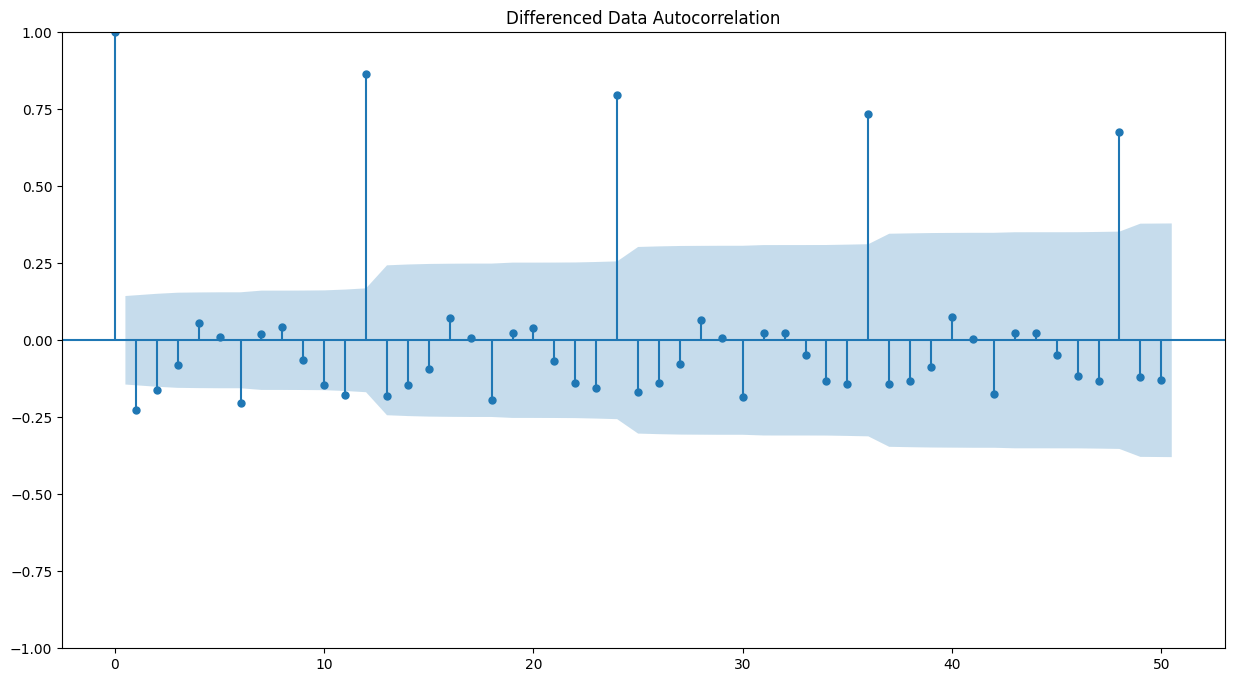

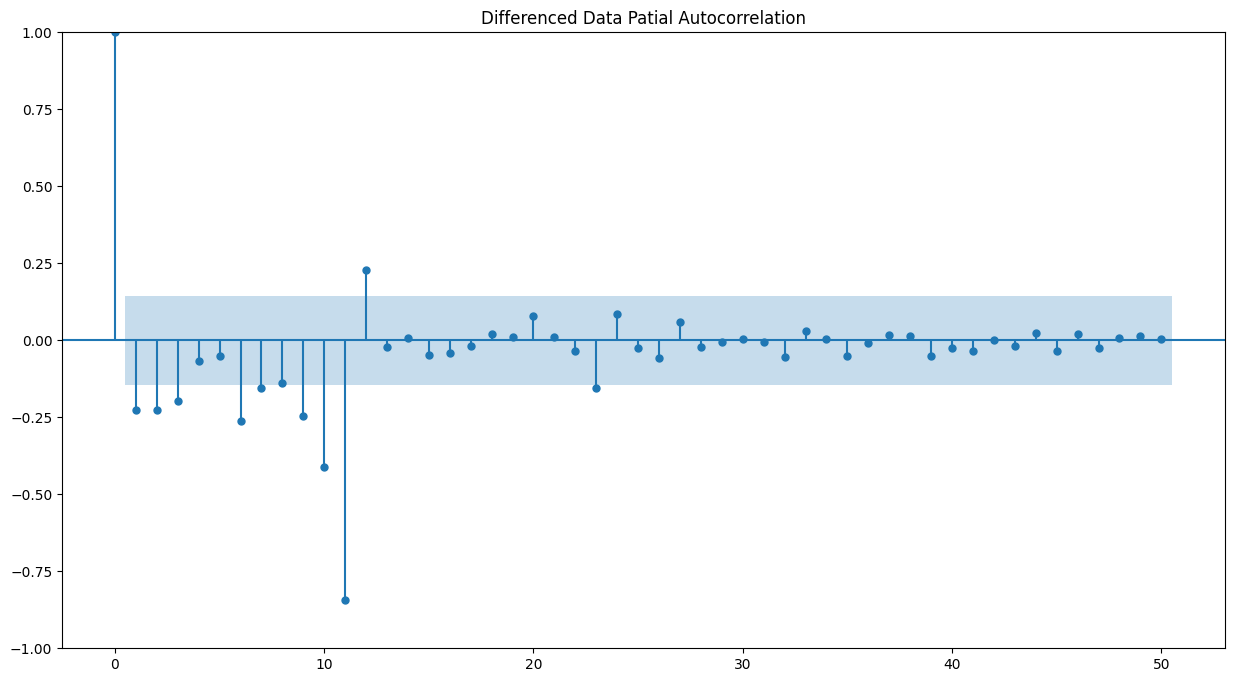

In [163]:
plot_acf(df['Sparkling'].diff().dropna(),lags=50,title='Differenced Data Autocorrelation')
plot_pacf(df['Sparkling'].diff().dropna(),lags=50,title='Differenced Data Patial Autocorrelation')
plt.show()

In [164]:
manual_SARIMA = sm.tsa.statespace.SARIMAX(
    train['Sparkling'],
    order=(3,1,2),
    seasonal_order=(3,1,2,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results_manual_SARIMA = manual_SARIMA.fit(maxiter=1000)

In [165]:
print(results_manual_SARIMA.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Sparkling   No. Observations:                  132
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 12)   Log Likelihood                -598.630
Date:                            Sat, 12 Apr 2025   AIC                           1219.260
Time:                                    19:01:25   BIC                           1245.462
Sample:                                01-01-1980   HQIC                          1229.765
                                     - 12-01-1990                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7556      0.151     -5.013      0.000      -1.051      -0.460
ar.L2          0.1169      0.185   

In [166]:
print(results_manual_SARIMA.params)

ar.L1           -0.755562
ar.L2            0.116876
ar.L3           -0.052016
ma.L1            0.033034
ma.L2           -0.966982
ar.S.L12        -0.753782
ar.S.L24        -0.637100
ar.S.L36        -0.246914
ma.S.L12         0.371941
ma.S.L24         0.346623
sigma2      179005.436813
dtype: float64


In [167]:
results_manual_SARIMA.mle_retvals

{'fopt': np.float64(4.5350756769831175),
 'gopt': array([-4.04079437e-05,  2.91158209e-05,  9.79554216e-06, -6.26543262e-05,
        -7.86792853e-06,  2.55936605e-05, -1.58569158e-05,  5.52673463e-05,
         3.88623356e-05, -3.57445629e-05, -2.81463742e-07]),
 'fcalls': 864,
 'warnflag': 0,
 'converged': True,
 'iterations': 63}

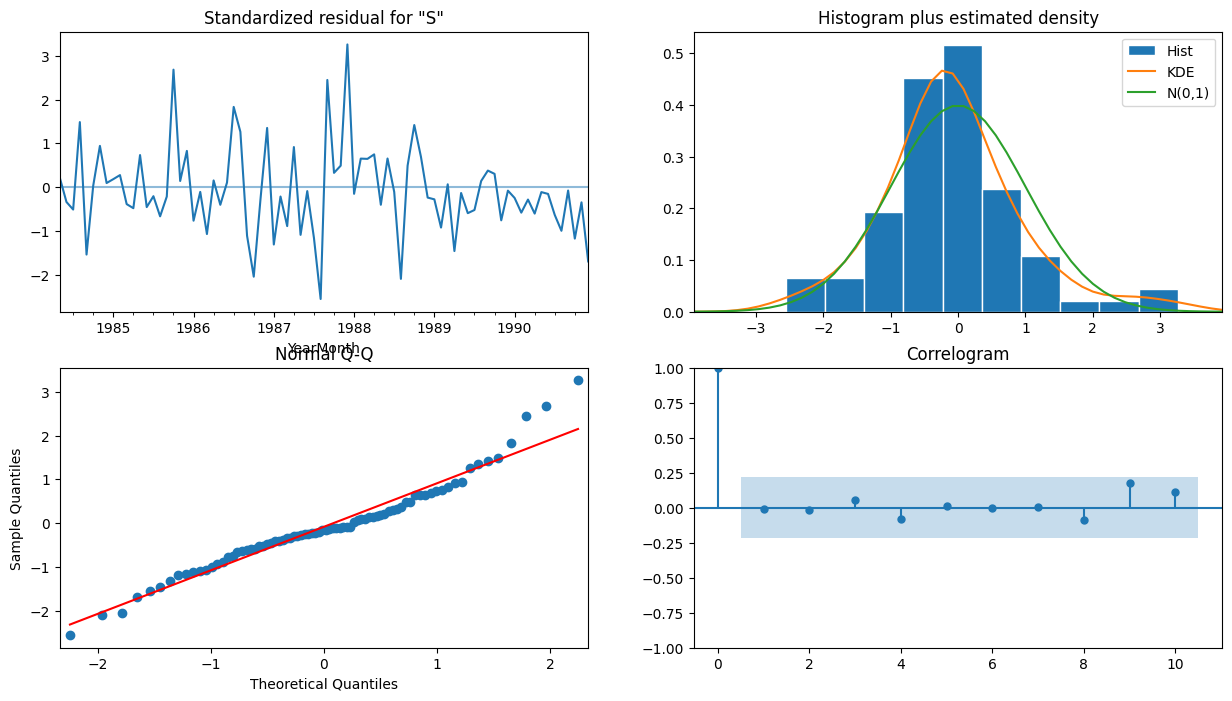

In [168]:
results_manual_SARIMA.plot_diagnostics();

In [169]:
# Predictions
train_preds_manual_sarima = results_manual_SARIMA.predict(start=train.index[0], end=train.index[-1])
test_preds_manual_sarima = results_manual_SARIMA.forecast(steps=len(test))
test_preds_manual_sarima.index = test.index  # align forecast index with test

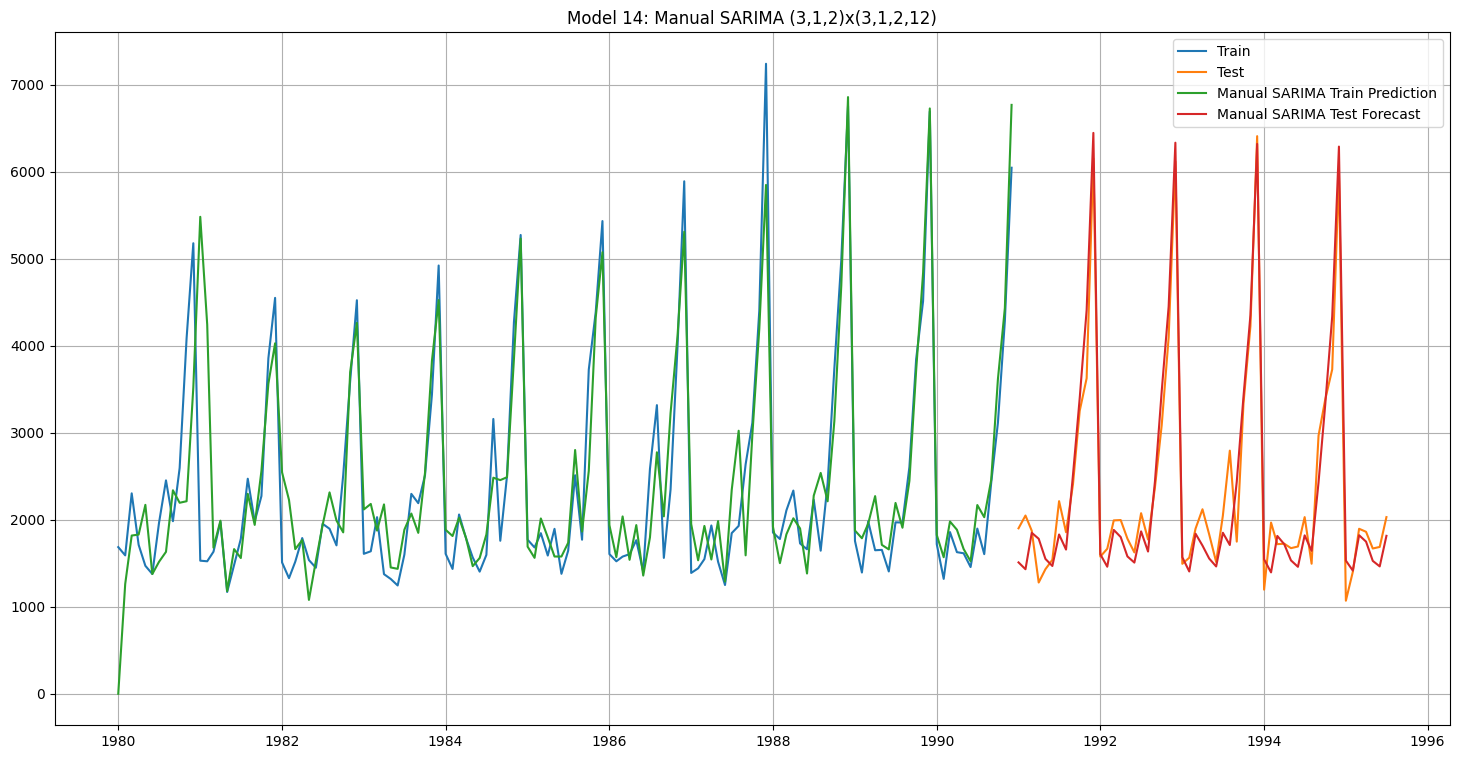

In [170]:
# Plotting
plt.figure(figsize=(18, 9))
plt.plot(train['Sparkling'], label='Train')
plt.plot(test['Sparkling'], label='Test')
plt.plot(train_preds_manual_sarima, label='Manual SARIMA Train Prediction')
plt.plot(test_preds_manual_sarima, label='Manual SARIMA Test Forecast')
plt.title('Model 14: Manual SARIMA (3,1,2)x(3,1,2,12)')
plt.legend()
plt.grid()
plt.show()

In [171]:
# Step 6: Metrics
rmse_train_manual_sarima = RMSE(train['Sparkling'], train_preds_manual_sarima)
mape_train_manual_sarima = MAPE(train['Sparkling'], train_preds_manual_sarima)

rmse_test_manual_sarima = RMSE(test['Sparkling'], test_preds_manual_sarima)
mape_test_manual_sarima = MAPE(test['Sparkling'], test_preds_manual_sarima)

print(f"Model 14 - Manual SARIMA Train → RMSE: {rmse_train_manual_sarima}, MAPE: {mape_train_manual_sarima}%")
print(f"Model 14 - Manual SARIMA Test  → RMSE: {rmse_test_manual_sarima}, MAPE: {mape_test_manual_sarima}%")

Model 14 - Manual SARIMA Train → RMSE: 641.92, MAPE: 16.27%
Model 14 - Manual SARIMA Test  → RMSE: 329.53, MAPE: 10.36%


In [172]:
# Step 7: Log Results
log_results(
    model="SARIMA_Manual_(3,1,2)(3,1,2,12)_Model14",
    train_rmse=rmse_train_manual_sarima,
    train_mape=mape_train_manual_sarima,
    test_rmse=rmse_test_manual_sarima,
    test_mape=mape_test_manual_sarima,
    data_source='original data | 1st diff model'
)

In [173]:
resultsDF

Model  Train RMSE  Train MAPE  \
0                           RegressionModel_Model1     1279.32       40.05   
1                                     Naive_Model2     3867.70      153.17   
2                           SimpleAveraging_Model3     1298.48       40.36   
3                       2-Point Trailing MA_Model4      689.16       18.01   
4                       4-Point Trailing MA_Model4     1106.40       34.28   
5                       6-Point Trailing MA_Model4     1261.79       42.11   
6                       9-Point Trailing MA_Model4     1372.84       45.99   
7                        SimpleExpSmoothing_Model5     1317.13       39.05   
8                       SES_FixedAlpha=0.02_Model6     1346.26       37.13   
9    DoubleExpSmoothing_Alpha=0.65_Beta=0.0_Model7     1337.48       39.11   
10        DES_GridSearch_Alpha=0.1_Beta=0.1_Model8     1363.47       44.26   
11         TES_Auto_AddTrend_AddSeasonality_Model9      371.02       10.88   
12  TES_Final_Alpha=0.5_Beta=0.3_Gamma=0.4_Model10      477.40       14.36   
13                         ARIMA_(2, 1, 2)_Model11     1082.42       32.88   
14        SARIMA_(1, 1, 2)_x_(1, 0, 2, 12)_Model12      592.29       15.04   
15                    Manual_ARIMA_(2,1,1)_Model13     1187.82       34.81   
16                    Manual_ARIMA_(1,1,2)_Model13     1192.36       35.10   
17         SARIMA_Manual_(3,1,2)(3,1,2,12)_Model14      641.92       16.27   

    Test RMSE  Test MAPE                        Data Source  
0     1275.87      39.16                           original  
1     3864.28     152.87                           original  
2     1275.08      38.90                           original  
3      813.40      19.70                           original  
4     1156.59      35.96                           original  
5     1283.93      43.86                           original  
6     1346.28      46.86                           original  
7     1304.93      44.48                           original  
8     1278.50      40.71                           original  
9     3851.44     152.08                           original  
10    1779.42      67.23                           original  
11     357.89      11.83                           original  
12     649.20      21.59                           original  
13    1299.98      43.20  original data | 1st diff in Model  
14     528.59      18.89     original data | 1st diff Model  
15    1274.94      38.65  original data | 1st diff in Model  
16    1274.37      38.55  original data | 1st diff in Model  
17     329.53      10.36     original data | 1st diff model

## Model 15: Prophet Implementation

In [174]:
from prophet import Prophet

# Reset the index and prepare the DataFrame for Prophet
prophet_df = df.copy().reset_index()
prophet_df = df.reset_index().rename(columns={'YearMonth': 'ds', 'Sparkling': 'y'})

prophet_df.head()

ds     y
0 1980-01-01  1686
1 1980-02-01  1591
2 1980-03-01  2304
3 1980-04-01  1712
4 1980-05-01  1471

In [175]:
# split the data into train and test
train_prophet = prophet_df[prophet_df['ds'].dt.year < 1991]
test_prophet = prophet_df[prophet_df['ds'].dt.year >= 1991]

In [176]:
# fit the model
model = Prophet()
model.fit(train_prophet)

19:01:26 - cmdstanpy - INFO - Chain [1] start processing
19:01:26 - cmdstanpy - INFO - Chain [1] done processing


In [177]:
# Create a future dataframe for the test period
future = model.make_future_dataframe(periods=len(test_prophet), freq='MS') 
future['ds'] = pd.to_datetime(future['ds']) 

future.tail()

ds
182 1995-03-01
183 1995-04-01
184 1995-05-01
185 1995-06-01
186 1995-07-01

In [178]:
forecast = model.predict(future)
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast.head()

ds        trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 1980-01-01  2314.369392  1109.204655  2014.639742  2314.369392  2314.369392   
1 1980-02-01  2313.449260  1073.616833  1969.476224  2313.449260  2313.449260   
2 1980-03-01  2312.588492  1377.129734  2291.099799  2312.588492  2312.588492   
3 1980-04-01  2311.668360  1249.861029  2165.814255  2311.668360  2311.668360   
4 1980-05-01  2310.777911   950.563450  1852.501296  2310.777911  2310.777911   

   additive_terms  additive_terms_lower  additive_terms_upper      yearly  \
0     -730.360162           -730.360162           -730.360162 -730.360162   
1     -785.398117           -785.398117           -785.398117 -785.398117   
2     -471.318648           -471.318648           -471.318648 -471.318648   
3     -635.742703           -635.742703           -635.742703 -635.742703   
4     -915.852675           -915.852675           -915.852675 -915.852675   

   yearly_lower  yearly_upper  multiplicative_terms  \
0   -730.360162   -730.360162                   0.0   
1   -785.398117   -785.398117                   0.0   
2   -471.318648   -471.318648                   0.0   
3   -635.742703   -635.742703                   0.0   
4   -915.852675   -915.852675                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper         yhat  
0                         0.0                         0.0  1584.009230  
1                         0.0                         0.0  1528.051144  
2                         0.0                         0.0  1841.269844  
3                         0.0                         0.0  1675.925657  
4                         0.0                         0.0  1394.925236

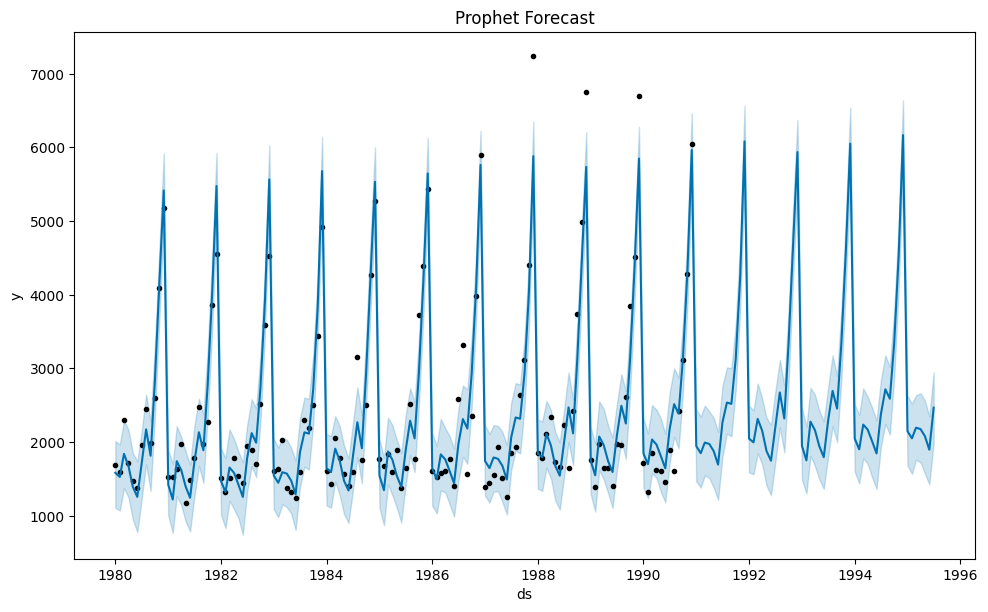

In [179]:
fig = model.plot(forecast)
plt.title("Prophet Forecast")
plt.grid()
plt.show()

In [180]:
## Evaluation
# Merge predictions with actuals
forecast['ds'] = pd.to_datetime(forecast['ds'])
test_prophet = test_prophet.copy()
test_prophet['ds'] = pd.to_datetime(test_prophet['ds'])

# Filter only matching test dates
forecast_test = forecast.set_index('ds').loc[test_prophet['ds']]
actuals_test = test_prophet.set_index('ds').loc[forecast_test.index]

# Compute Evaluation Metrics
rmse_prophet = RMSE(actuals_test['y'], forecast_test['yhat'])
mape_prophet = MAPE(actuals_test['y'], forecast_test['yhat'])

print(f"Model 13 (Prophet) - Test RMSE: {rmse_prophet}, MAPE: {mape_prophet}%")

Model 13 (Prophet) - Test RMSE: 440.63, MAPE: 14.35%


In [181]:
# STEP 5: Log Results
log_results(
    model="Prophet_Model15",
    train_rmse=None,
    train_mape=None,
    test_rmse=rmse_prophet,
    test_mape=mape_prophet,
    data_source="original | reindexed"
)

/tmp/ipykernel_16959/3891039026.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resultsDF = pd.concat([resultsDF, new_row], ignore_index=True)


In [182]:
resultsDF

Model  Train RMSE  Train MAPE  \
0                           RegressionModel_Model1     1279.32       40.05   
1                                     Naive_Model2     3867.70      153.17   
2                           SimpleAveraging_Model3     1298.48       40.36   
3                       2-Point Trailing MA_Model4      689.16       18.01   
4                       4-Point Trailing MA_Model4     1106.40       34.28   
5                       6-Point Trailing MA_Model4     1261.79       42.11   
6                       9-Point Trailing MA_Model4     1372.84       45.99   
7                        SimpleExpSmoothing_Model5     1317.13       39.05   
8                       SES_FixedAlpha=0.02_Model6     1346.26       37.13   
9    DoubleExpSmoothing_Alpha=0.65_Beta=0.0_Model7     1337.48       39.11   
10        DES_GridSearch_Alpha=0.1_Beta=0.1_Model8     1363.47       44.26   
11         TES_Auto_AddTrend_AddSeasonality_Model9      371.02       10.88   
12  TES_Final_Alpha=0.5_Beta=0.3_Gamma=0.4_Model10      477.40       14.36   
13                         ARIMA_(2, 1, 2)_Model11     1082.42       32.88   
14        SARIMA_(1, 1, 2)_x_(1, 0, 2, 12)_Model12      592.29       15.04   
15                    Manual_ARIMA_(2,1,1)_Model13     1187.82       34.81   
16                    Manual_ARIMA_(1,1,2)_Model13     1192.36       35.10   
17         SARIMA_Manual_(3,1,2)(3,1,2,12)_Model14      641.92       16.27   
18                                 Prophet_Model15         NaN         NaN   

    Test RMSE  Test MAPE                        Data Source  
0     1275.87      39.16                           original  
1     3864.28     152.87                           original  
2     1275.08      38.90                           original  
3      813.40      19.70                           original  
4     1156.59      35.96                           original  
5     1283.93      43.86                           original  
6     1346.28      46.86                           original  
7     1304.93      44.48                           original  
8     1278.50      40.71                           original  
9     3851.44     152.08                           original  
10    1779.42      67.23                           original  
11     357.89      11.83                           original  
12     649.20      21.59                           original  
13    1299.98      43.20  original data | 1st diff in Model  
14     528.59      18.89     original data | 1st diff Model  
15    1274.94      38.65  original data | 1st diff in Model  
16    1274.37      38.55  original data | 1st diff in Model  
17     329.53      10.36     original data | 1st diff model  
18     440.63      14.35               original | reindexed

## Model 16: XGBoost Regressor

In [183]:
xgb_df = df.copy()
for lag in range(1, 13):  # Use 12 months of history
    xgb_df[f'lag_{lag}'] = xgb_df['Sparkling'].shift(lag)

# Drop rows with NaNs caused by lagging
xgb_df = xgb_df.dropna()

In [184]:
train_xgb = xgb_df[xgb_df.index.year < 1991]
test_xgb = xgb_df[xgb_df.index.year >= 1991]

X_train = train_xgb.drop(columns=['Sparkling'])
y_train = train_xgb['Sparkling']

X_test = test_xgb.drop(columns=['Sparkling'])
y_test = test_xgb['Sparkling']

In [188]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [189]:
train_preds = xgb_model.predict(X_train)
test_preds = xgb_model.predict(X_test)

rmse_train = RMSE(y_train, train_preds)
mape_train = MAPE(y_train, train_preds)

rmse_test = RMSE(y_test, test_preds)
mape_test = MAPE(y_test, test_preds)

print(f"XGBoost - Train RMSE: {rmse_train}, MAPE: {mape_train}%")
print(f"XGBoost - Test RMSE: {rmse_test}, MAPE: {mape_test}%")


XGBoost - Train RMSE: 79.5, MAPE: 2.57%
XGBoost - Test RMSE: 441.33, MAPE: 13.19%


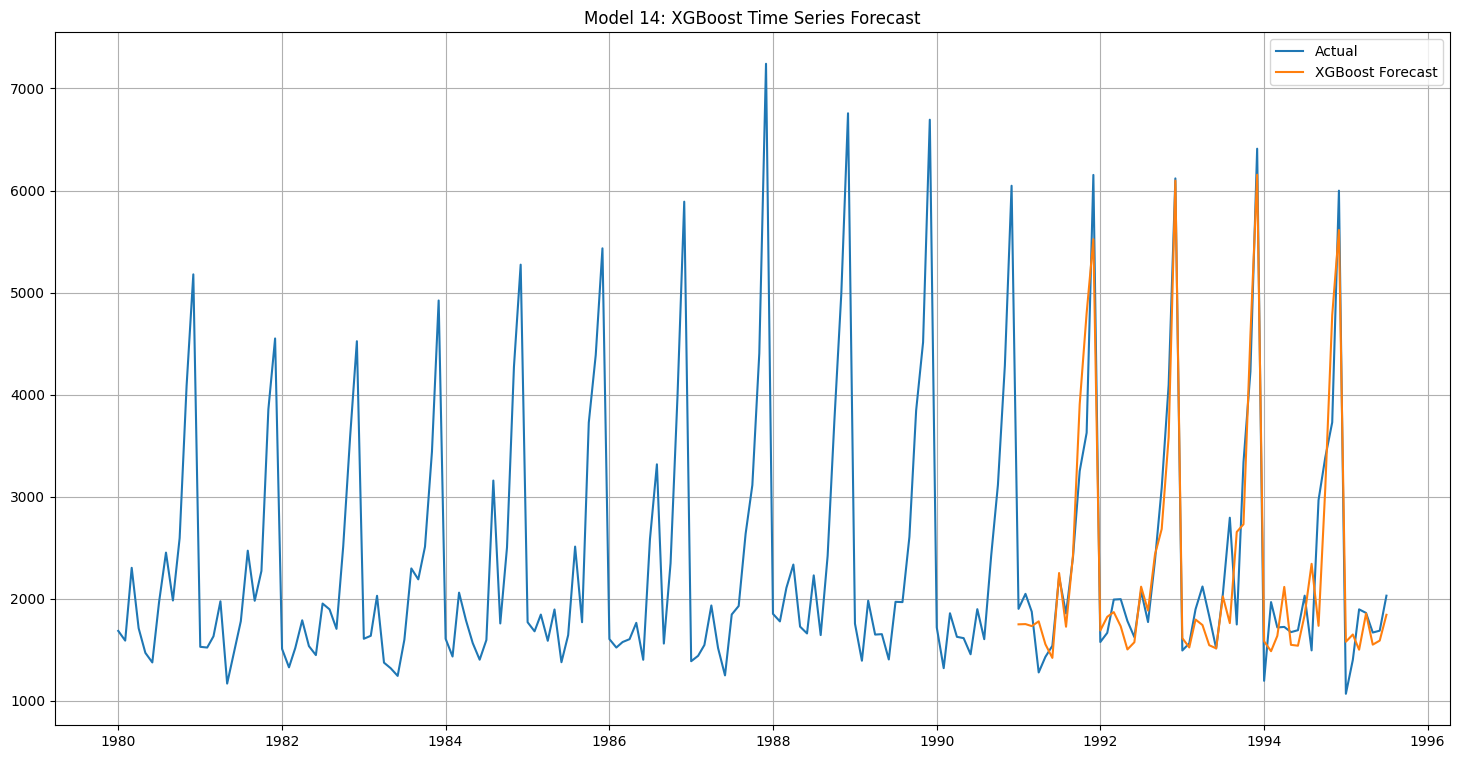

In [190]:
plt.figure(figsize=(18, 9))
plt.plot(df['Sparkling'], label='Actual')
plt.plot(test_xgb.index, test_preds, label='XGBoost Forecast')
plt.title('Model 14: XGBoost Time Series Forecast')
plt.legend()
plt.grid()
plt.show()

In [191]:
log_results(
    model='XGBoost_Model16',
    train_rmse=rmse_train,
    train_mape=mape_train,
    test_rmse=rmse_test,
    test_mape=mape_test,
    data_source='original | lag features'
)

## Model 17: Neural Network

In [204]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [205]:
data = df[['Sparkling']].copy()

# Scaling
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [206]:
# Create Sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 12  # 12 months
X, y = create_sequences(data_scaled, window_size)

In [207]:
train_size = int(len(X) * 0.7)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Reshape for CNN-LSTM: (samples, timesteps, features)
# Here timesteps == window_size, features == 1
X_train = X_train.reshape((X_train.shape[0], window_size, 1))
X_test = X_test.reshape((X_test.shape[0], window_size, 1))

In [208]:
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(50, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

/home/anmol/miniconda3/envs/timeseries/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1744503624.717127   16959 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1744503624.717859   16959 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 11, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,243 (90.79 KB)

 Trainable params: 23,243 (90.79 KB)

 Non-trainable params: 0 (0.00 B)

In [209]:
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1)

# ----- STEP 6: Predict & Inverse Scale -----
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_preds_inv = scaler.inverse_transform(train_preds)
y_train_inv = scaler.inverse_transform(y_train)

test_preds_inv = scaler.inverse_transform(test_preds)
y_test_inv = scaler.inverse_transform(y_test)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0630 - val_loss: 0.0640
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0427 - val_loss: 0.0636
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0404 - val_loss: 0.0607
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0440 - val_loss: 0.0594
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0420 - val_loss: 0.0581
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0445 - val_loss: 0.0606
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0404 - val_loss: 0.0542
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0369 - val_loss: 0.0521
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0398 - val_loss: 0.0498
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0331 - val_loss: 0.0483
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0382 - val_loss: 0.0453
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0322 - val_loss: 0.0426
Ep

In [215]:
# TRAIN METRICS
rmse_train = RMSE(y_train_inv, train_preds_inv)
mape_train = MAPE(y_train_inv, train_preds_inv)

In [216]:
# TEST METRICS
rmse_test = RMSE(y_test_inv, test_preds_inv)
mape_test = MAPE(y_test_inv, test_preds_inv)

print(f"CNN-LSTM Train RMSE: {rmse_train:.2f}, MAPE: {mape_train:.2f}%")
print(f"CNN-LSTM Test RMSE: {rmse_test:.2f}, MAPE: {mape_test:.2f}%")

CNN-LSTM Train RMSE: 407.05, MAPE: 12.63%
CNN-LSTM Test RMSE: 404.43, MAPE: 12.93%


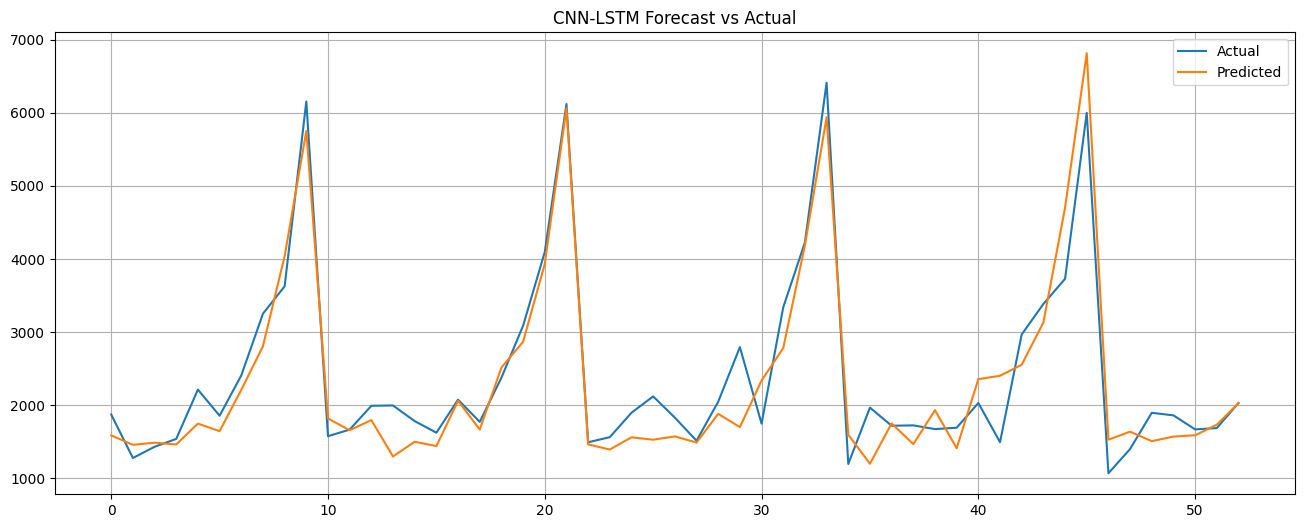

In [213]:
plt.figure(figsize=(16, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(test_preds_inv, label='Predicted')
plt.title("CNN-LSTM Forecast vs Actual")
plt.legend()
plt.grid(True)
plt.show()

In [217]:
log_results(
    model="CNN_LSTM_Model17",
    train_rmse=rmse_train,
    train_mape=mape_train,
    test_rmse=rmse_test,
    test_mape=mape_test,
    data_source="scaled + inverse"
)

In [218]:
resultsDF

Model  Train RMSE  Train MAPE  \
0                           RegressionModel_Model1     1279.32       40.05   
1                                     Naive_Model2     3867.70      153.17   
2                           SimpleAveraging_Model3     1298.48       40.36   
3                       2-Point Trailing MA_Model4      689.16       18.01   
4                       4-Point Trailing MA_Model4     1106.40       34.28   
5                       6-Point Trailing MA_Model4     1261.79       42.11   
6                       9-Point Trailing MA_Model4     1372.84       45.99   
7                        SimpleExpSmoothing_Model5     1317.13       39.05   
8                       SES_FixedAlpha=0.02_Model6     1346.26       37.13   
9    DoubleExpSmoothing_Alpha=0.65_Beta=0.0_Model7     1337.48       39.11   
10        DES_GridSearch_Alpha=0.1_Beta=0.1_Model8     1363.47       44.26   
11         TES_Auto_AddTrend_AddSeasonality_Model9      371.02       10.88   
12  TES_Final_Alpha=0.5_Beta=0.3_Gamma=0.4_Model10      477.40       14.36   
13                         ARIMA_(2, 1, 2)_Model11     1082.42       32.88   
14        SARIMA_(1, 1, 2)_x_(1, 0, 2, 12)_Model12      592.29       15.04   
15                    Manual_ARIMA_(2,1,1)_Model13     1187.82       34.81   
16                    Manual_ARIMA_(1,1,2)_Model13     1192.36       35.10   
17         SARIMA_Manual_(3,1,2)(3,1,2,12)_Model14      641.92       16.27   
18                                 Prophet_Model15         NaN         NaN   
19                                 XGBoost_Model16       79.50        2.57   
20                                CNN_LSTM_Model17      407.05       12.63   

    Test RMSE  Test MAPE                        Data Source  
0     1275.87      39.16                           original  
1     3864.28     152.87                           original  
2     1275.08      38.90                           original  
3      813.40      19.70                           original  
4     1156.59      35.96                           original  
5     1283.93      43.86                           original  
6     1346.28      46.86                           original  
7     1304.93      44.48                           original  
8     1278.50      40.71                           original  
9     3851.44     152.08                           original  
10    1779.42      67.23                           original  
11     357.89      11.83                           original  
12     649.20      21.59                           original  
13    1299.98      43.20  original data | 1st diff in Model  
14     528.59      18.89     original data | 1st diff Model  
15    1274.94      38.65  original data | 1st diff in Model  
16    1274.37      38.55  original data | 1st diff in Model  
17     329.53      10.36     original data | 1st diff model  
18     440.63      14.35               original | reindexed  
19     441.33      13.19            original | lag features  
20     404.43      12.93                   scaled + inverse

In [219]:
# Export the ResultsDF to csv
resultsDF.to_csv("sparkling_modelling_results.csv")

## Results

In [222]:
resultsDF.sort_values(by='Test RMSE').style.highlight_min(color='lightgreen', subset=['Test RMSE'])

In [225]:
best_model = resultsDF.loc[resultsDF['Test RMSE'].idxmin()]
print(best_model)

Model          SARIMA_Manual_(3,1,2)(3,1,2,12)_Model14
Train RMSE                                      641.92
Train MAPE                                       16.27
Test RMSE                                       329.53
Test MAPE                                        10.36
Data Source             original data | 1st diff model
Name: 17, dtype: object


## Best Model on Complete Data And Forecast for the Next 12 months

In [238]:
order = (3, 1, 2)
seasonal_order = (3, 1, 2, 12)

full_data_model = sm.tsa.statespace.SARIMAX(df['Sparkling'],
                                order=(3,1,2),
                                seasonal_order=(3, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_full_data_model = full_data_model.fit(maxiter=1000)

In [239]:
print(results_full_data_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Sparkling   No. Observations:                  187
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 12)   Log Likelihood               -1000.243
Date:                            Sat, 12 Apr 2025   AIC                           2022.487
Time:                                    19:37:14   BIC                           2054.445
Sample:                                01-01-1980   HQIC                          2035.473
                                     - 07-01-1995                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8611      0.090     -9.548      0.000      -1.038      -0.684
ar.L2          0.0118      0.129   

In [240]:
print(results_full_data_model.params)

ar.L1           -0.861073
ar.L2            0.011778
ar.L3           -0.076663
ma.L1            0.032247
ma.L2           -0.967749
ar.S.L12        -0.609843
ar.S.L24        -0.497977
ar.S.L36        -0.247116
ma.S.L12         0.122640
ma.S.L24         0.248835
sigma2      156196.756221
dtype: float64


### Forecasting

In [245]:
predicted_manual_SARIMA_full_data = results_full_data_model.get_forecast(steps=12)

In [246]:
predicted_manual_SARIMA_full_data.summary_frame(alpha=0.05).head()

Sparkling          mean     mean_se  mean_ci_lower  mean_ci_upper
1995-08-01  1868.655499  396.448731    1091.630264    2645.680735
1995-09-01  2511.392976  401.799937    1723.879571    3298.906382
1995-10-01  3272.640421  402.645369    2483.470000    4061.810843
1995-11-01  3874.395107  403.060750    3084.410553    4664.379660
1995-12-01  6098.936257  403.080390    5308.913210    6888.959305

In [243]:
# Step 4: Evaluate model on full data (in-sample fit)
rmse_full = RMSE(df['Sparkling'], results_full_data_model.fittedvalues)
print(f"In-sample RMSE on full data: {rmse_full}")

In-sample RMSE on full data: 578.96


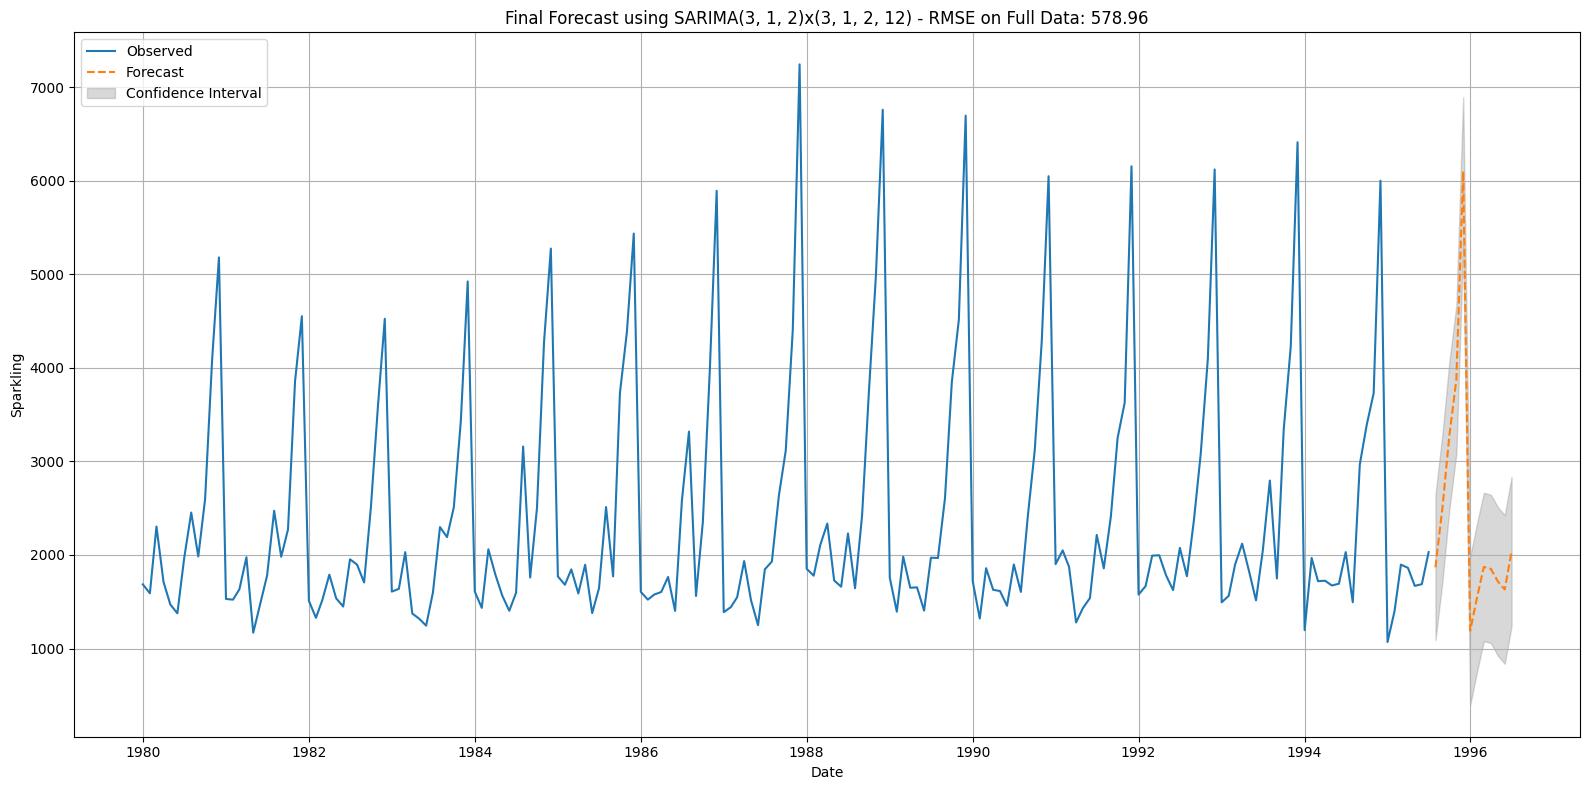

In [244]:
plt.figure(figsize=(16, 8))
plt.plot(df['Sparkling'], label='Observed')
plt.plot(forecast_df['mean'], label='Forecast', linestyle='--')
plt.fill_between(forecast_df.index, 
                 forecast_df['mean_ci_lower'], 
                 forecast_df['mean_ci_upper'], 
                 color='gray', alpha=0.3, label='Confidence Interval')
plt.title(f'Final Forecast using SARIMA{order}x{seasonal_order} - RMSE on Full Data: {rmse_full:.2f}')
plt.xlabel('Date')
plt.ylabel('Sparkling')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()